In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
import os

# 3D CNN Model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv0 = nn.Conv3d(in_channels=23, out_channels=64, kernel_size=1, stride=1, padding=0) # play around with output channels
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)

        #self.dropout_conv = nn.Dropout3d(p=0.05)
        
        # After two pooling layers, spatial dimensions reduce from 40x40x40 -> 5x5x5
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 256)  # Try increasing over 256
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 1 output for docking status/position

        #self.dropout_fc = nn.Dropout(p=0.15)
        
    def forward(self, x):
        # Forward pass through Conv layers
        x = self.pool(torch.relu(self.conv0(x)))  # Conv0 -> ReLU -> Pooling
        #x = self.dropout_conv(x)
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pooling
        x = self.pool2(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pooling

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 3 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x)) #use tanh activation
        #x = self.dropout_fc(x)
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.softmax(self.fc3(x), dim=1)  # Final layer (output layer)
        #x = torch.clamp(x, min=1e-7, max=1 - 1e-7)  # Clamp outputs to avoid extreme values
        
        return x

In [2]:
class GridDataset(Dataset):
    def __init__(self, data_dict):
        self.data = list(data_dict.values())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        grid = sample['grid_tensor']
        label = sample['label']
        return grid, label

In [3]:
# Training function
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0)

        total_grad_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                total_grad_norm += param.grad.norm().item()
        optimizer.step()
        
        running_loss += loss.item()
    return (running_loss / len(dataloader)), total_grad_norm

# Validation function
def validate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    validation_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return validation_loss, accuracy

In [4]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp5/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp5/Validation_Set/*.npy')
file_data = {} # format is filename as key, label and grid tensor are values

for file in positive_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    file_data[file] = {'label': 1, 'grid_tensor': grid_tensor}
positive_grids = file_data
print(len(positive_grids), "is length of positive")

file_data = {} # format is filename as key, label and grid tensor are values

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Load the numpy array and convert it to a PyTorch tensor
    grid = np.load(file)
    grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
    else:
        label = 1
        positive_validation_count += 1

    file_data[file] = {'label': label, 'grid_tensor': grid_tensor}
print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")
validation_grids = file_data
print(len(validation_grids), "is length of validation grids")

1925 is length of positive
In validation directory there are 385 positives and 1385 fragments
1770 is length of validation grids


In [5]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

1925 is length of subset grid
Training on bin 1
Bin 1, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6869, Validation Accuracy: 0.7825, Grad Norm: 0.0417, LR: 0.000050
Bin 1, Epoch 11/150, Train Loss: 0.5823, Validation Loss: 0.5325, Validation Accuracy: 0.8599, Grad Norm: 1.0106, LR: 0.000050
Bin 1, Epoch 21/150, Train Loss: 0.4669, Validation Loss: 0.4564, Validation Accuracy: 0.8655, Grad Norm: 6.1508, LR: 0.000050
Bin 1, Epoch 31/150, Train Loss: 0.4568, Validation Loss: 0.4365, Validation Accuracy: 0.8814, Grad Norm: 4.0779, LR: 0.000050
Bin 1, Epoch 41/150, Train Loss: 0.4467, Validation Loss: 0.4383, Validation Accuracy: 0.8774, Grad Norm: 1.1247, LR: 0.000050
Bin 1, Epoch 51/150, Train Loss: 0.4455, Validation Loss: 0.4343, Validation Accuracy: 0.8831, Grad Norm: 3.6590, LR: 0.000025
Bin 1, Epoch 61/150, Train Loss: 0.4425, Validation Loss: 0.4477, Validation Accuracy: 0.8621, Grad Norm: 1.4083, LR: 0.000025
Bin 1, Epoch 71/150, Train Loss: 0.4430, Validation Loss: 0.4324

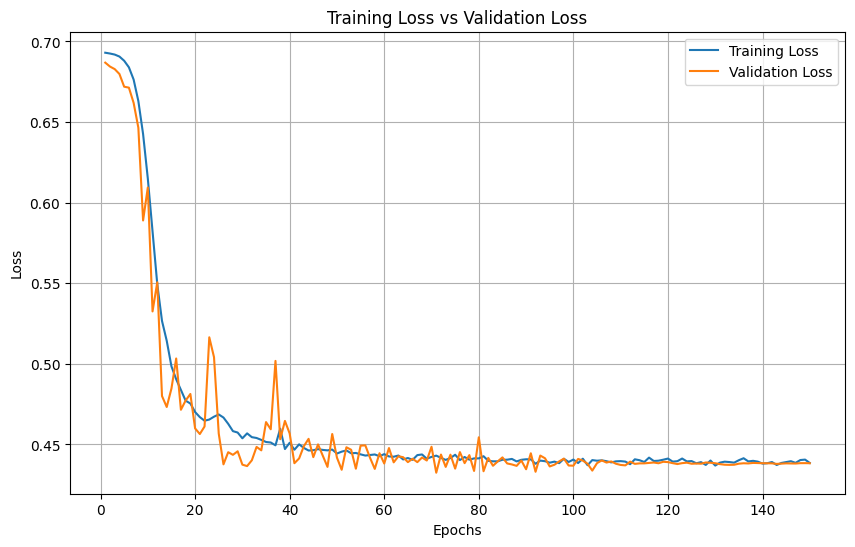

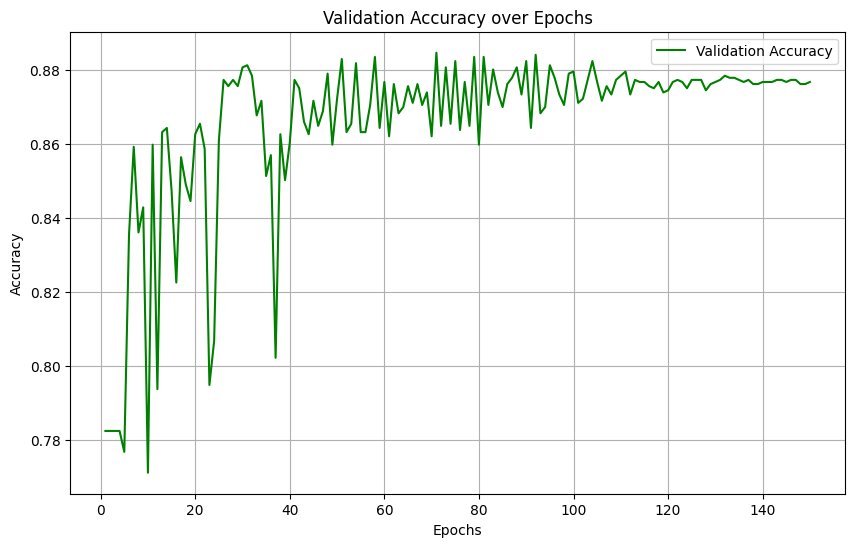

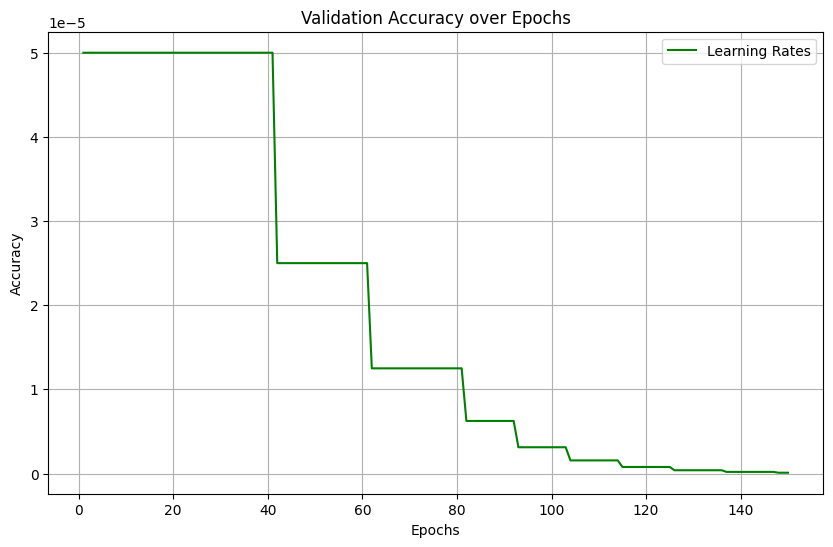

Model for bin 1 saved to 3DCholesterolModels-5A_exp5/model_bin_1.pth
1925 is length of subset grid
Training on bin 2
Bin 2, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6867, Validation Accuracy: 0.7825, Grad Norm: 0.0389, LR: 0.000050
Bin 2, Epoch 11/150, Train Loss: 0.6038, Validation Loss: 0.5706, Validation Accuracy: 0.8435, Grad Norm: 5.7407, LR: 0.000050
Bin 2, Epoch 21/150, Train Loss: 0.4803, Validation Loss: 0.4958, Validation Accuracy: 0.8203, Grad Norm: 6.0134, LR: 0.000050
Bin 2, Epoch 31/150, Train Loss: 0.4581, Validation Loss: 0.4428, Validation Accuracy: 0.8774, Grad Norm: 0.3696, LR: 0.000050
Bin 2, Epoch 41/150, Train Loss: 0.4499, Validation Loss: 0.4339, Validation Accuracy: 0.8870, Grad Norm: 0.5624, LR: 0.000050
Bin 2, Epoch 51/150, Train Loss: 0.4459, Validation Loss: 0.4227, Validation Accuracy: 0.8932, Grad Norm: 1.8710, LR: 0.000050
Bin 2, Epoch 61/150, Train Loss: 0.4442, Validation Loss: 0.4202, Validation Accuracy: 0.8944, Grad Norm: 5.9843, LR: 0.00

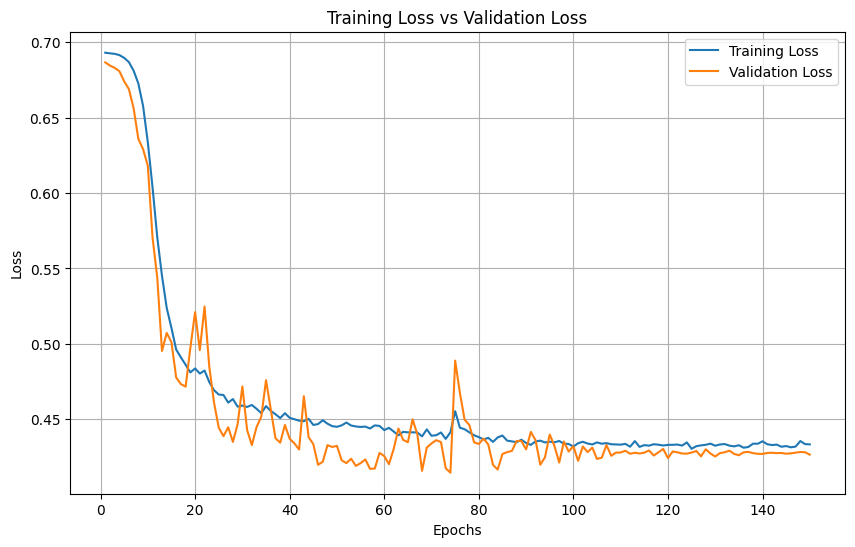

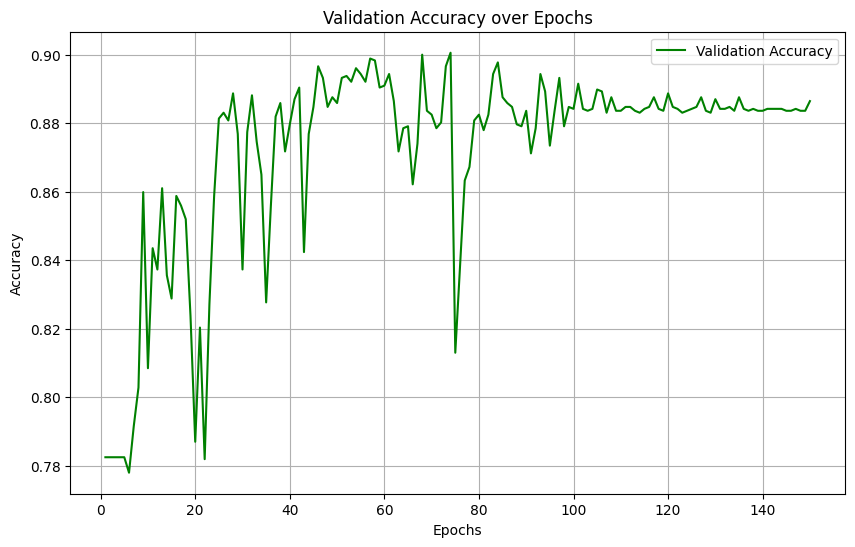

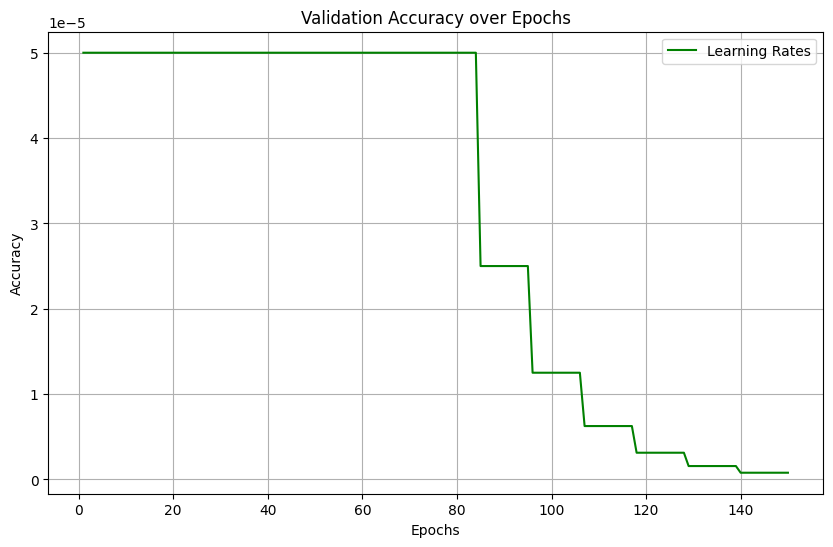

Model for bin 2 saved to 3DCholesterolModels-5A_exp5/model_bin_2.pth
1925 is length of subset grid
Training on bin 3
Bin 3, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6832, Validation Accuracy: 0.7825, Grad Norm: 0.0270, LR: 0.000050
Bin 3, Epoch 11/150, Train Loss: 0.6138, Validation Loss: 0.5881, Validation Accuracy: 0.8164, Grad Norm: 2.4376, LR: 0.000050
Bin 3, Epoch 21/150, Train Loss: 0.4753, Validation Loss: 0.4463, Validation Accuracy: 0.8808, Grad Norm: 3.7849, LR: 0.000050
Bin 3, Epoch 31/150, Train Loss: 0.4631, Validation Loss: 0.4276, Validation Accuracy: 0.8887, Grad Norm: 3.8130, LR: 0.000050
Bin 3, Epoch 41/150, Train Loss: 0.4564, Validation Loss: 0.4227, Validation Accuracy: 0.8921, Grad Norm: 6.2493, LR: 0.000050
Bin 3, Epoch 51/150, Train Loss: 0.4489, Validation Loss: 0.4283, Validation Accuracy: 0.8870, Grad Norm: 5.1698, LR: 0.000050
Bin 3, Epoch 61/150, Train Loss: 0.4450, Validation Loss: 0.4233, Validation Accuracy: 0.8915, Grad Norm: 4.9822, LR: 0.00

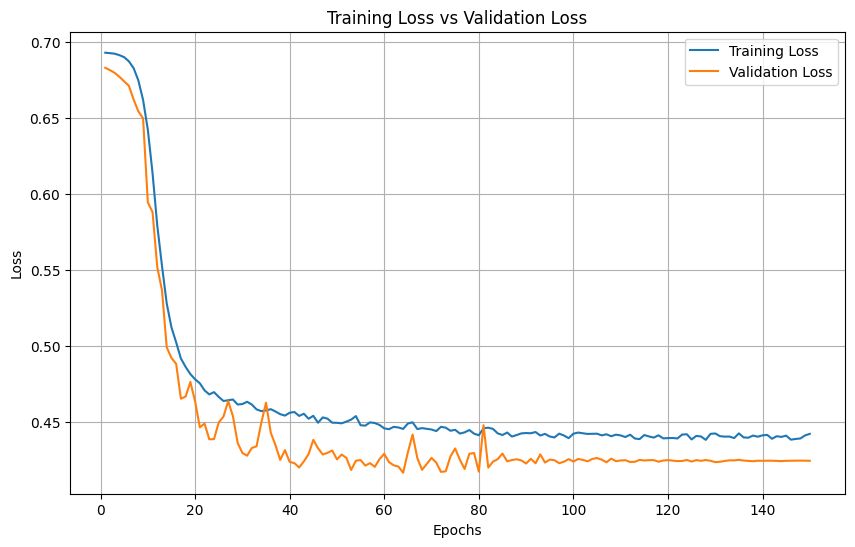

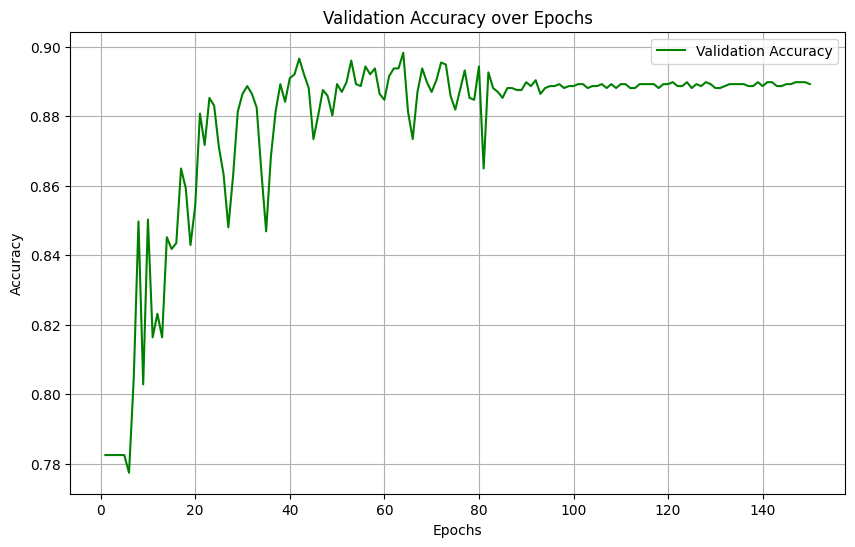

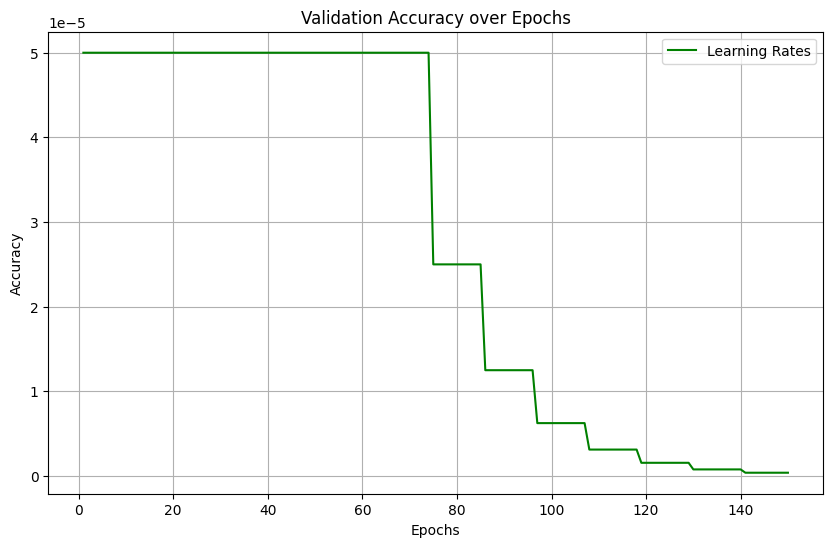

Model for bin 3 saved to 3DCholesterolModels-5A_exp5/model_bin_3.pth
1925 is length of subset grid
Training on bin 4
Bin 4, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6871, Validation Accuracy: 0.7825, Grad Norm: 0.0143, LR: 0.000050
Bin 4, Epoch 11/150, Train Loss: 0.5769, Validation Loss: 0.5367, Validation Accuracy: 0.8548, Grad Norm: 1.2570, LR: 0.000050
Bin 4, Epoch 21/150, Train Loss: 0.4616, Validation Loss: 0.4642, Validation Accuracy: 0.8514, Grad Norm: 6.4884, LR: 0.000050
Bin 4, Epoch 31/150, Train Loss: 0.4480, Validation Loss: 0.4378, Validation Accuracy: 0.8751, Grad Norm: 5.1826, LR: 0.000050
Bin 4, Epoch 41/150, Train Loss: 0.4423, Validation Loss: 0.4382, Validation Accuracy: 0.8751, Grad Norm: 2.5896, LR: 0.000025
Bin 4, Epoch 51/150, Train Loss: 0.4403, Validation Loss: 0.4320, Validation Accuracy: 0.8819, Grad Norm: 1.5724, LR: 0.000025
Bin 4, Epoch 61/150, Train Loss: 0.4373, Validation Loss: 0.4357, Validation Accuracy: 0.8780, Grad Norm: 0.4779, LR: 0.00

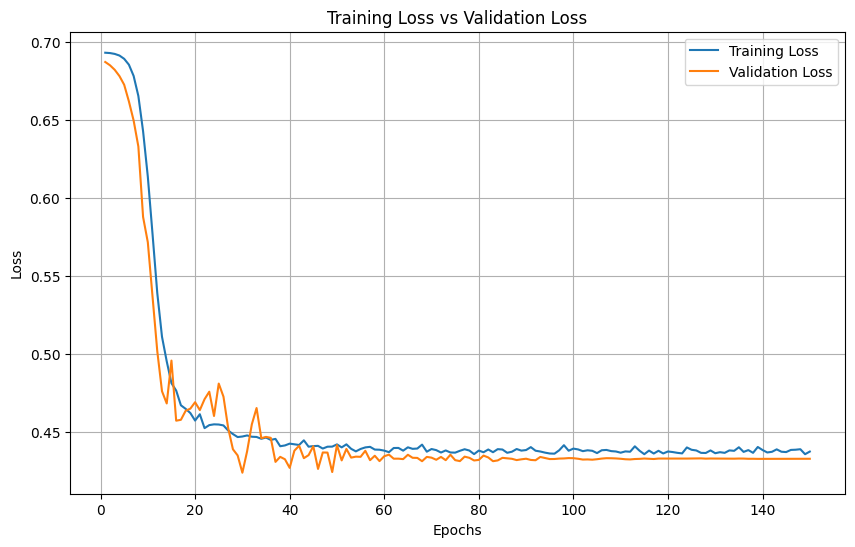

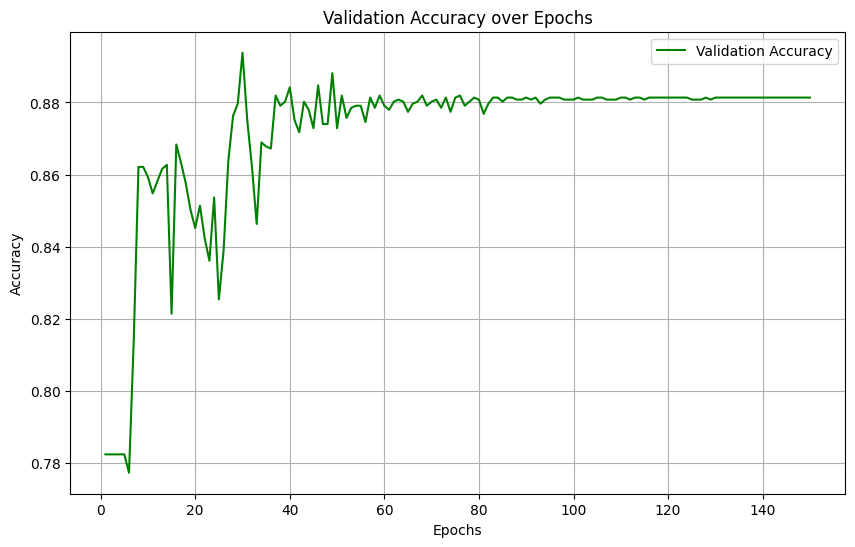

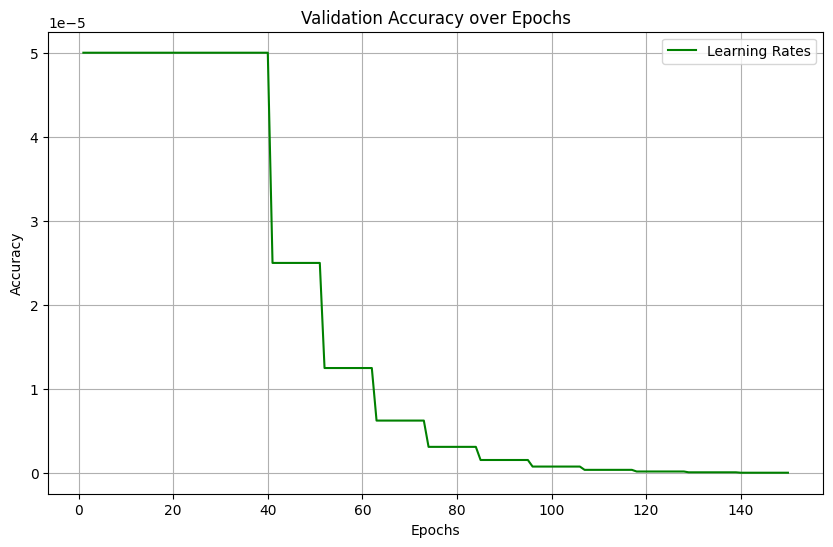

Model for bin 4 saved to 3DCholesterolModels-5A_exp5/model_bin_4.pth
1925 is length of subset grid
Training on bin 5
Bin 5, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6935, Validation Accuracy: 0.2554, Grad Norm: 0.0279, LR: 0.000050
Bin 5, Epoch 11/150, Train Loss: 0.5848, Validation Loss: 0.5656, Validation Accuracy: 0.8102, Grad Norm: 4.2208, LR: 0.000050
Bin 5, Epoch 21/150, Train Loss: 0.4730, Validation Loss: 0.4537, Validation Accuracy: 0.8678, Grad Norm: 1.8760, LR: 0.000050
Bin 5, Epoch 31/150, Train Loss: 0.4617, Validation Loss: 0.4463, Validation Accuracy: 0.8701, Grad Norm: 3.7083, LR: 0.000050
Bin 5, Epoch 41/150, Train Loss: 0.4555, Validation Loss: 0.4291, Validation Accuracy: 0.8876, Grad Norm: 5.6833, LR: 0.000050
Bin 5, Epoch 51/150, Train Loss: 0.4529, Validation Loss: 0.4290, Validation Accuracy: 0.8876, Grad Norm: 0.2339, LR: 0.000025
Bin 5, Epoch 61/150, Train Loss: 0.4507, Validation Loss: 0.4396, Validation Accuracy: 0.8734, Grad Norm: 2.1865, LR: 0.00

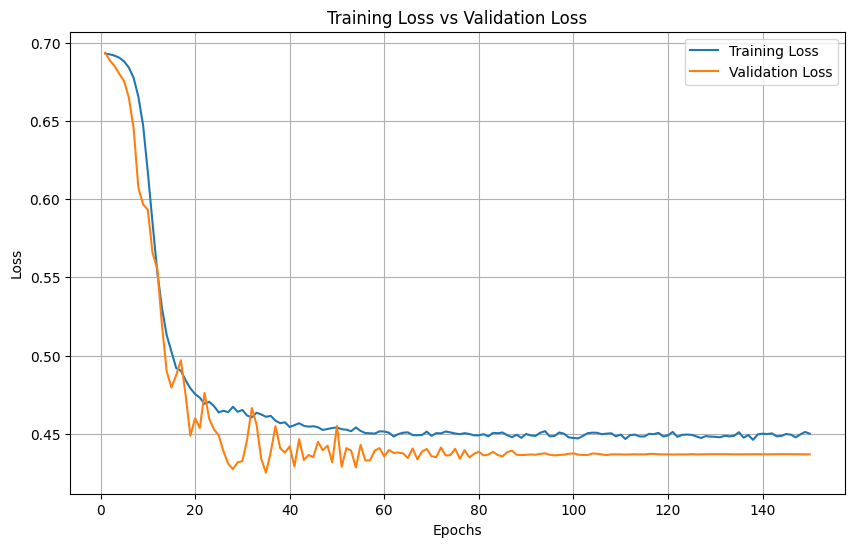

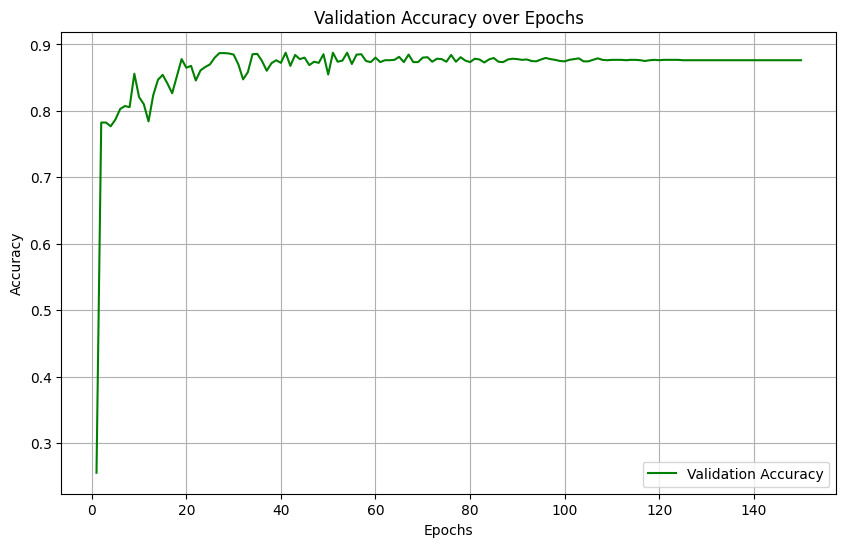

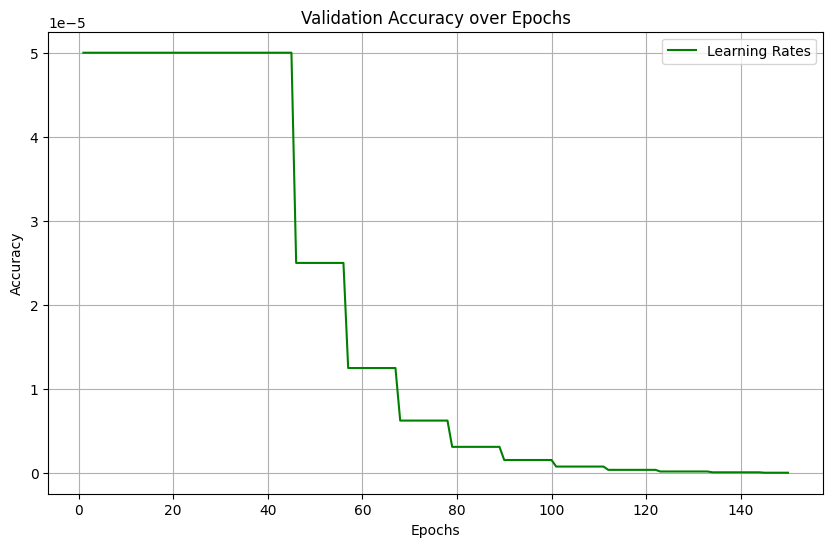

Model for bin 5 saved to 3DCholesterolModels-5A_exp5/model_bin_5.pth
1925 is length of subset grid
Training on bin 6
Bin 6, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6945, Validation Accuracy: 0.2175, Grad Norm: 0.0644, LR: 0.000050
Bin 6, Epoch 11/150, Train Loss: 0.6609, Validation Loss: 0.6200, Validation Accuracy: 0.8599, Grad Norm: 0.8209, LR: 0.000050
Bin 6, Epoch 21/150, Train Loss: 0.4800, Validation Loss: 0.4577, Validation Accuracy: 0.8678, Grad Norm: 1.8482, LR: 0.000050
Bin 6, Epoch 31/150, Train Loss: 0.4687, Validation Loss: 0.4265, Validation Accuracy: 0.8944, Grad Norm: 5.6419, LR: 0.000050
Bin 6, Epoch 41/150, Train Loss: 0.4616, Validation Loss: 0.4303, Validation Accuracy: 0.8887, Grad Norm: 0.3385, LR: 0.000025
Bin 6, Epoch 51/150, Train Loss: 0.4592, Validation Loss: 0.4248, Validation Accuracy: 0.8938, Grad Norm: 1.5148, LR: 0.000025
Bin 6, Epoch 61/150, Train Loss: 0.4573, Validation Loss: 0.4333, Validation Accuracy: 0.8836, Grad Norm: 5.5404, LR: 0.00

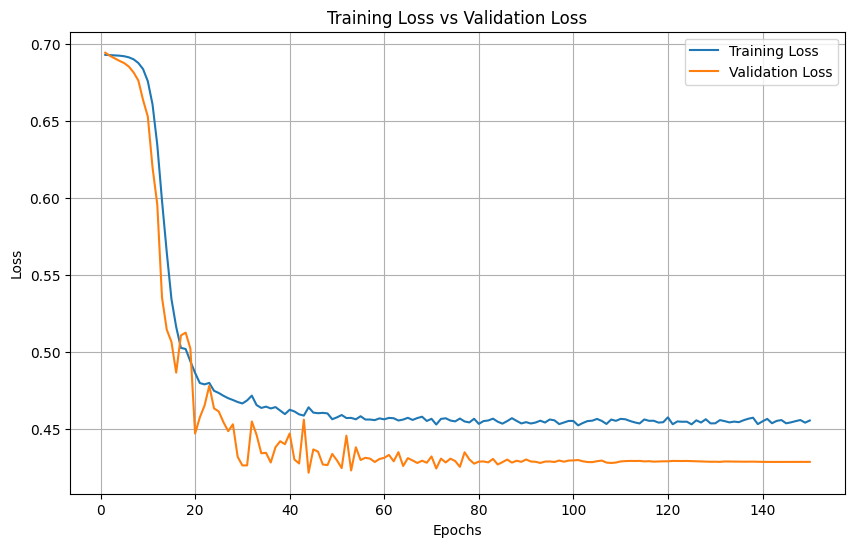

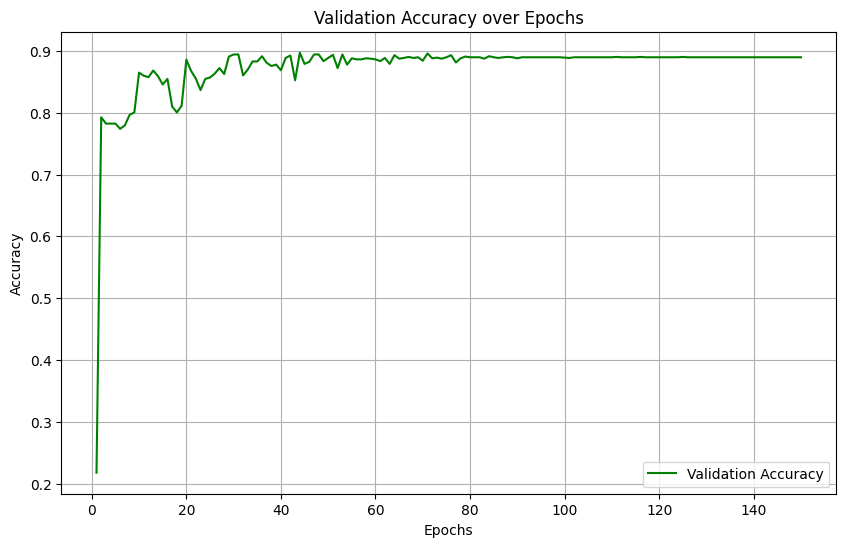

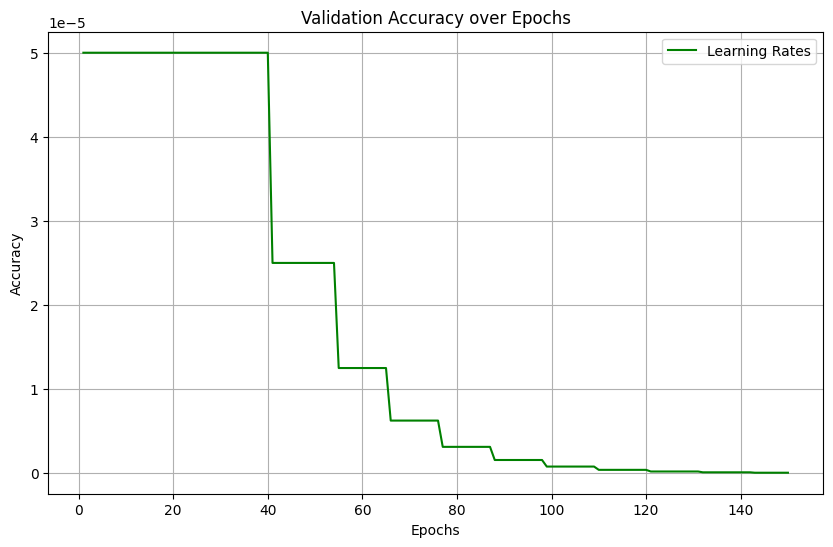

Model for bin 6 saved to 3DCholesterolModels-5A_exp5/model_bin_6.pth
1925 is length of subset grid
Training on bin 7
Bin 7, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6818, Validation Accuracy: 0.7825, Grad Norm: 0.0440, LR: 0.000050
Bin 7, Epoch 11/150, Train Loss: 0.5758, Validation Loss: 0.5531, Validation Accuracy: 0.8169, Grad Norm: 1.8292, LR: 0.000050
Bin 7, Epoch 21/150, Train Loss: 0.4683, Validation Loss: 0.4629, Validation Accuracy: 0.8571, Grad Norm: 2.6810, LR: 0.000050
Bin 7, Epoch 31/150, Train Loss: 0.4549, Validation Loss: 0.4530, Validation Accuracy: 0.8605, Grad Norm: 4.7525, LR: 0.000050
Bin 7, Epoch 41/150, Train Loss: 0.4499, Validation Loss: 0.4399, Validation Accuracy: 0.8780, Grad Norm: 5.0650, LR: 0.000025
Bin 7, Epoch 51/150, Train Loss: 0.4481, Validation Loss: 0.4316, Validation Accuracy: 0.8870, Grad Norm: 1.2046, LR: 0.000025
Bin 7, Epoch 61/150, Train Loss: 0.4484, Validation Loss: 0.4347, Validation Accuracy: 0.8847, Grad Norm: 1.3244, LR: 0.00

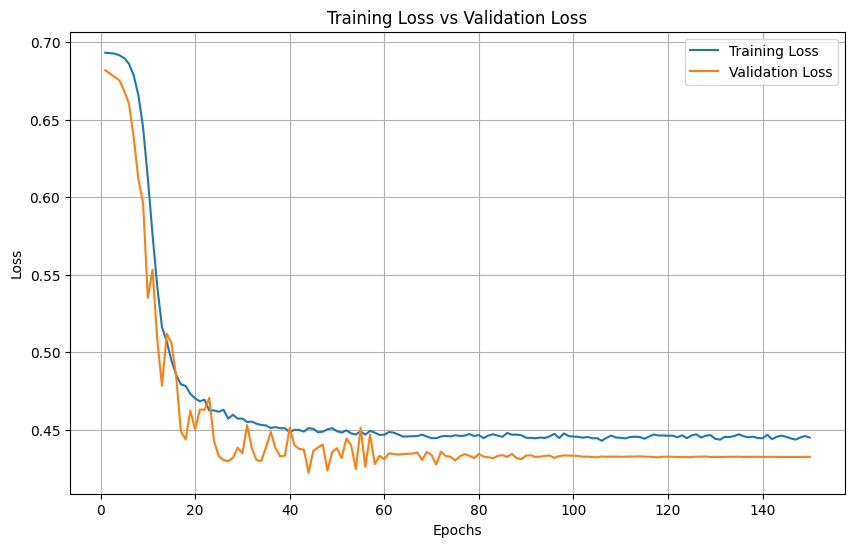

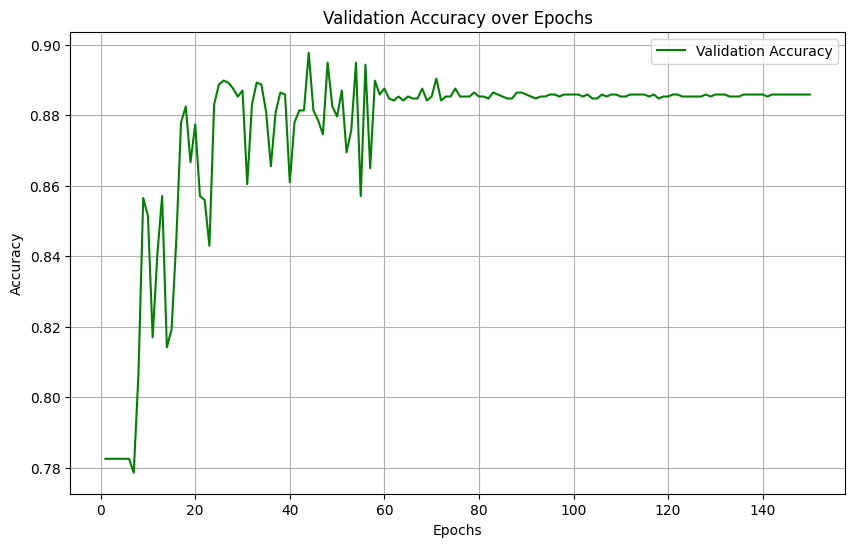

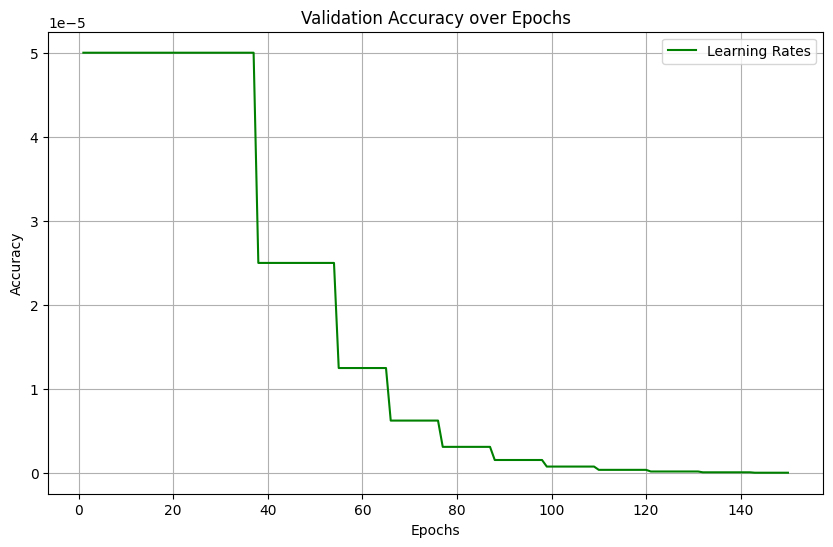

Model for bin 7 saved to 3DCholesterolModels-5A_exp5/model_bin_7.pth
1925 is length of subset grid
Training on bin 8
Bin 8, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6919, Validation Accuracy: 0.7740, Grad Norm: 0.0376, LR: 0.000050
Bin 8, Epoch 11/150, Train Loss: 0.6156, Validation Loss: 0.5653, Validation Accuracy: 0.8571, Grad Norm: 2.0624, LR: 0.000050
Bin 8, Epoch 21/150, Train Loss: 0.4744, Validation Loss: 0.4436, Validation Accuracy: 0.8746, Grad Norm: 3.4082, LR: 0.000050
Bin 8, Epoch 31/150, Train Loss: 0.4542, Validation Loss: 0.4453, Validation Accuracy: 0.8701, Grad Norm: 4.6381, LR: 0.000025
Bin 8, Epoch 41/150, Train Loss: 0.4489, Validation Loss: 0.4335, Validation Accuracy: 0.8808, Grad Norm: 2.2602, LR: 0.000025
Bin 8, Epoch 51/150, Train Loss: 0.4488, Validation Loss: 0.4388, Validation Accuracy: 0.8774, Grad Norm: 0.3078, LR: 0.000013
Bin 8, Epoch 61/150, Train Loss: 0.4458, Validation Loss: 0.4355, Validation Accuracy: 0.8785, Grad Norm: 4.7945, LR: 0.00

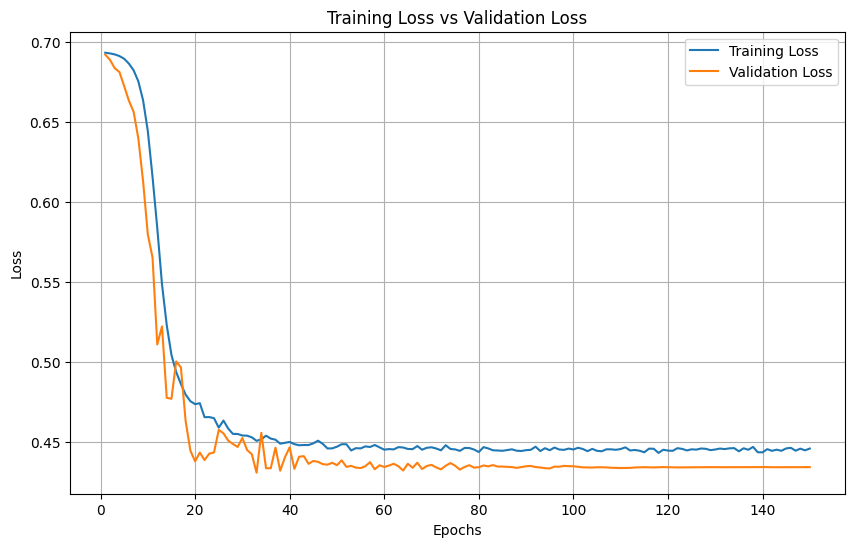

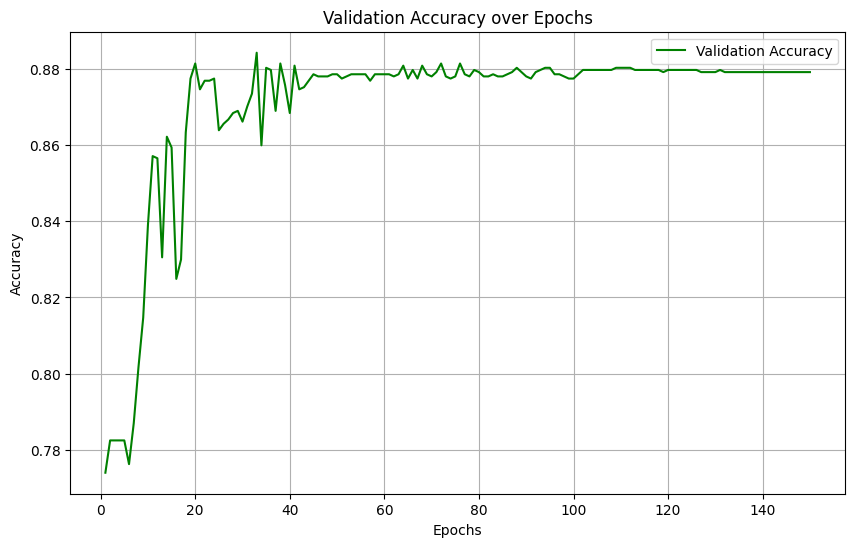

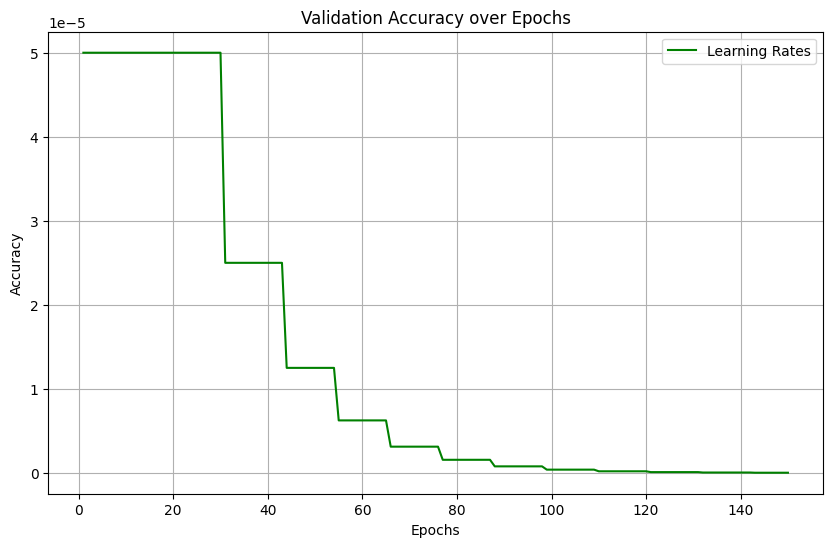

Model for bin 8 saved to 3DCholesterolModels-5A_exp5/model_bin_8.pth
1925 is length of subset grid
Training on bin 9
Bin 9, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6797, Validation Accuracy: 0.7825, Grad Norm: 0.0711, LR: 0.000050
Bin 9, Epoch 11/150, Train Loss: 0.5663, Validation Loss: 0.5174, Validation Accuracy: 0.8407, Grad Norm: 3.0625, LR: 0.000050
Bin 9, Epoch 21/150, Train Loss: 0.4803, Validation Loss: 0.4438, Validation Accuracy: 0.8780, Grad Norm: 4.8156, LR: 0.000050
Bin 9, Epoch 31/150, Train Loss: 0.4608, Validation Loss: 0.4442, Validation Accuracy: 0.8718, Grad Norm: 2.1971, LR: 0.000050
Bin 9, Epoch 41/150, Train Loss: 0.4545, Validation Loss: 0.4603, Validation Accuracy: 0.8508, Grad Norm: 1.9602, LR: 0.000025
Bin 9, Epoch 51/150, Train Loss: 0.4546, Validation Loss: 0.4444, Validation Accuracy: 0.8695, Grad Norm: 4.0703, LR: 0.000025
Bin 9, Epoch 61/150, Train Loss: 0.4515, Validation Loss: 0.4302, Validation Accuracy: 0.8904, Grad Norm: 2.2462, LR: 0.00

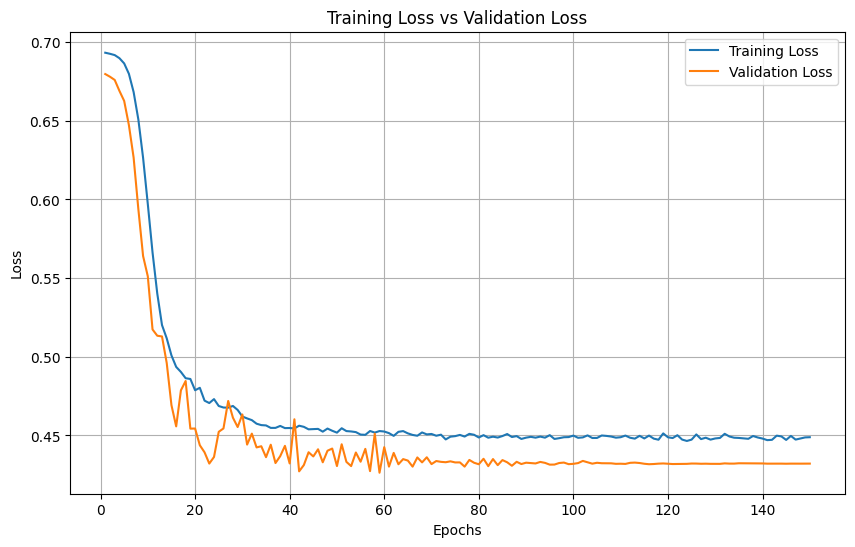

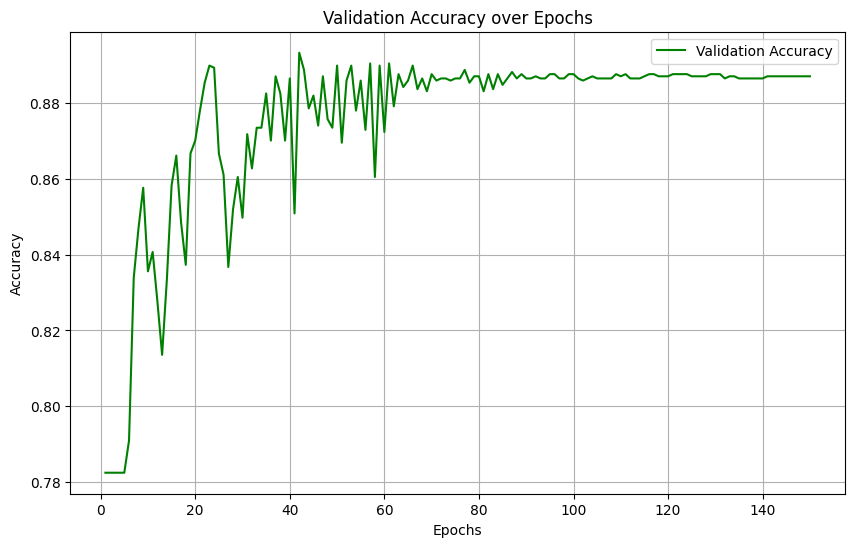

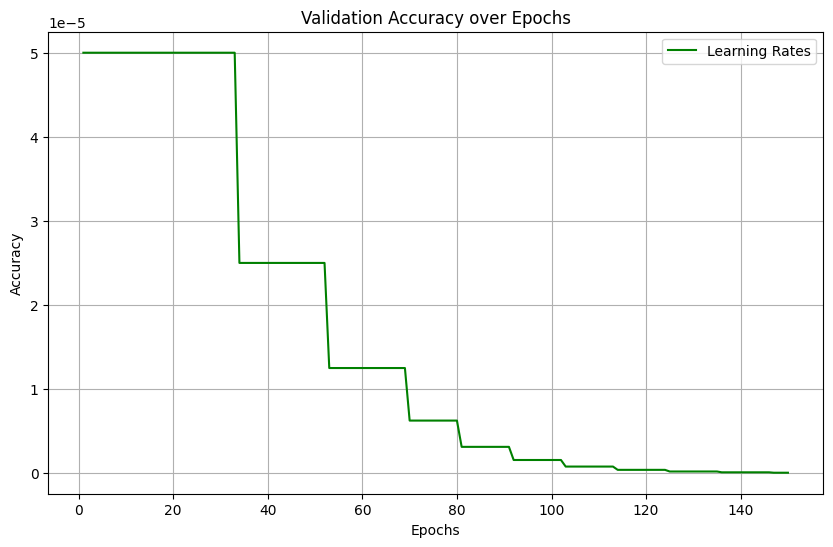

Model for bin 9 saved to 3DCholesterolModels-5A_exp5/model_bin_9.pth
1925 is length of subset grid
Training on bin 10
Bin 10, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6971, Validation Accuracy: 0.2175, Grad Norm: 0.0344, LR: 0.000050
Bin 10, Epoch 11/150, Train Loss: 0.6282, Validation Loss: 0.5642, Validation Accuracy: 0.8503, Grad Norm: 0.8373, LR: 0.000050
Bin 10, Epoch 21/150, Train Loss: 0.4665, Validation Loss: 0.4442, Validation Accuracy: 0.8768, Grad Norm: 0.4126, LR: 0.000050
Bin 10, Epoch 31/150, Train Loss: 0.4517, Validation Loss: 0.4298, Validation Accuracy: 0.8870, Grad Norm: 0.3566, LR: 0.000050
Bin 10, Epoch 41/150, Train Loss: 0.4502, Validation Loss: 0.4471, Validation Accuracy: 0.8650, Grad Norm: 4.5133, LR: 0.000050
Bin 10, Epoch 51/150, Train Loss: 0.4435, Validation Loss: 0.4228, Validation Accuracy: 0.8932, Grad Norm: 4.3202, LR: 0.000025
Bin 10, Epoch 61/150, Train Loss: 0.4445, Validation Loss: 0.4382, Validation Accuracy: 0.8751, Grad Norm: 5.2317, 

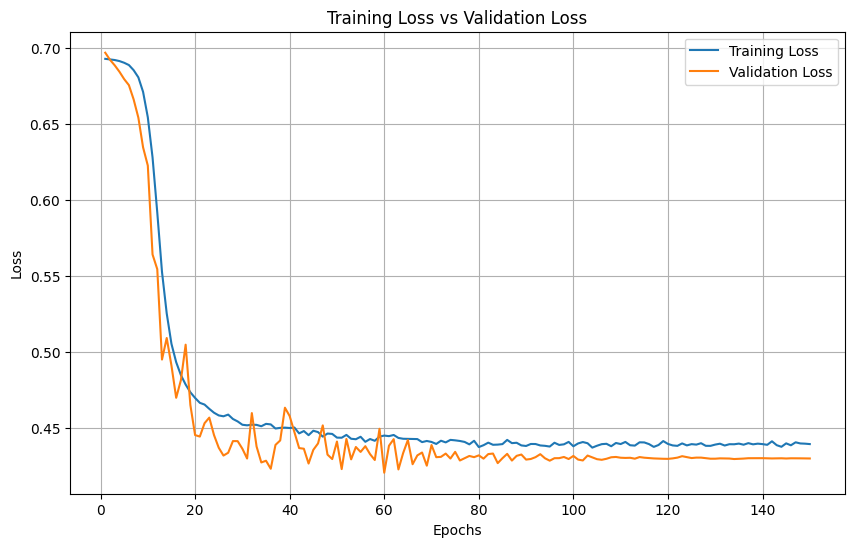

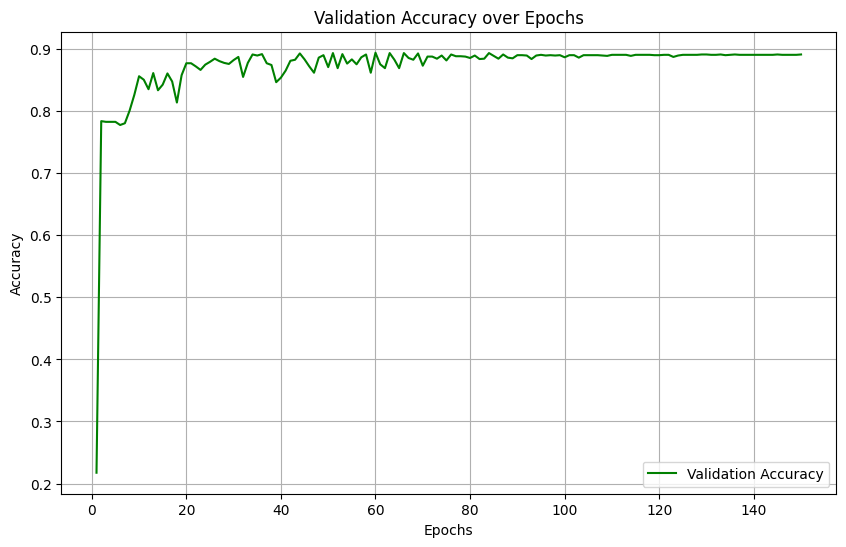

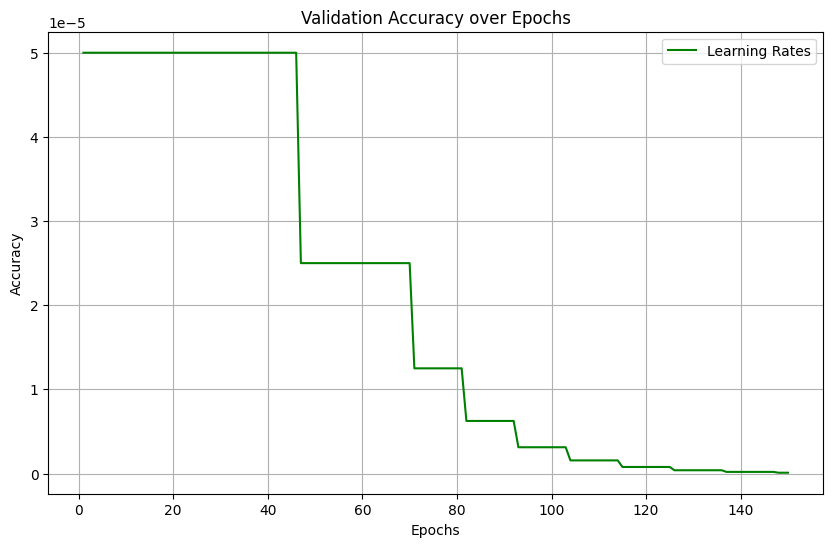

Model for bin 10 saved to 3DCholesterolModels-5A_exp5/model_bin_10.pth
1925 is length of subset grid
Training on bin 11
Bin 11, Epoch 1/150, Train Loss: 0.6929, Validation Loss: 0.6895, Validation Accuracy: 0.7825, Grad Norm: 0.0509, LR: 0.000050
Bin 11, Epoch 11/150, Train Loss: 0.5775, Validation Loss: 0.5165, Validation Accuracy: 0.8542, Grad Norm: 1.0056, LR: 0.000050
Bin 11, Epoch 21/150, Train Loss: 0.4651, Validation Loss: 0.4480, Validation Accuracy: 0.8740, Grad Norm: 0.6369, LR: 0.000050
Bin 11, Epoch 31/150, Train Loss: 0.4544, Validation Loss: 0.4622, Validation Accuracy: 0.8480, Grad Norm: 1.7091, LR: 0.000050
Bin 11, Epoch 41/150, Train Loss: 0.4498, Validation Loss: 0.4703, Validation Accuracy: 0.8367, Grad Norm: 1.2408, LR: 0.000050
Bin 11, Epoch 51/150, Train Loss: 0.4442, Validation Loss: 0.4389, Validation Accuracy: 0.8757, Grad Norm: 3.2762, LR: 0.000050
Bin 11, Epoch 61/150, Train Loss: 0.4423, Validation Loss: 0.4258, Validation Accuracy: 0.8915, Grad Norm: 1.7895

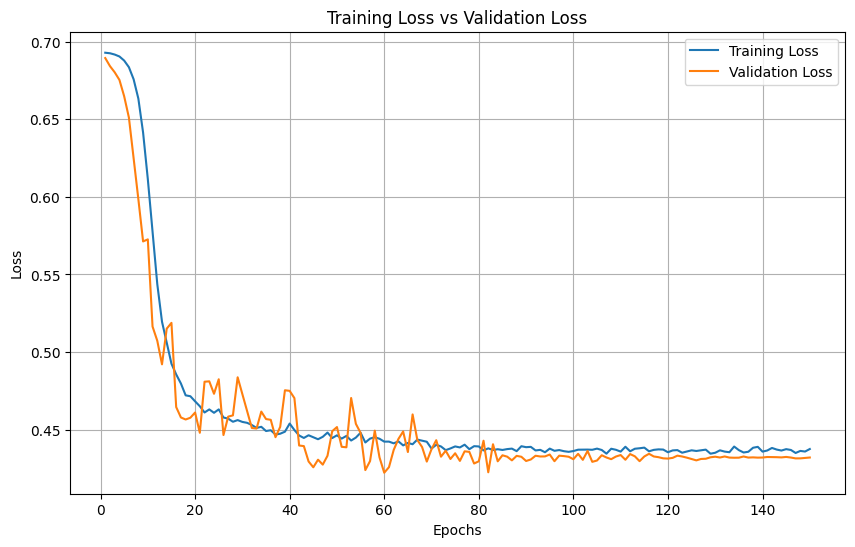

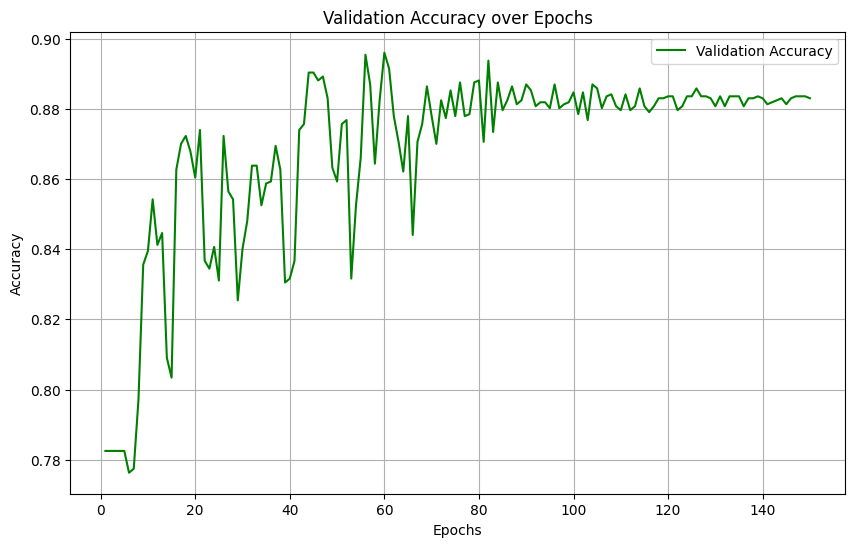

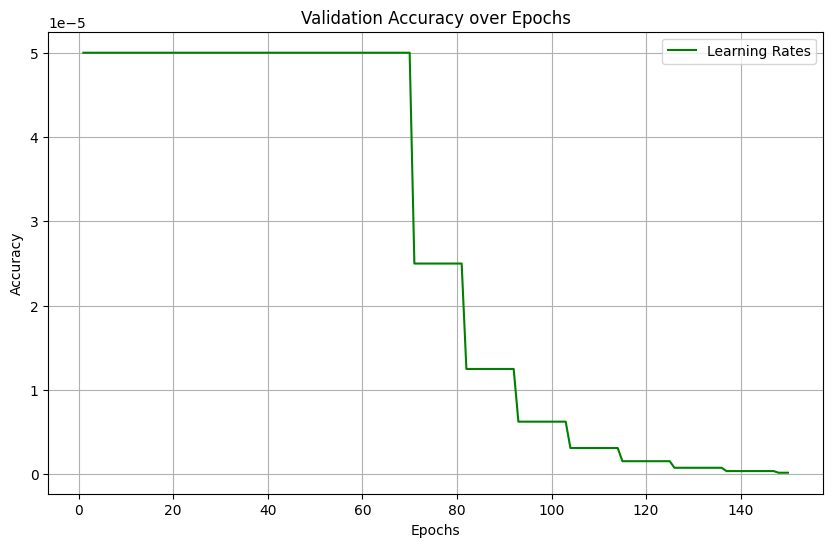

Model for bin 11 saved to 3DCholesterolModels-5A_exp5/model_bin_11.pth
1925 is length of subset grid
Training on bin 12
Bin 12, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6951, Validation Accuracy: 0.2175, Grad Norm: 0.0436, LR: 0.000050
Bin 12, Epoch 11/150, Train Loss: 0.5925, Validation Loss: 0.5242, Validation Accuracy: 0.8565, Grad Norm: 1.6501, LR: 0.000050
Bin 12, Epoch 21/150, Train Loss: 0.4677, Validation Loss: 0.4400, Validation Accuracy: 0.8876, Grad Norm: 0.7686, LR: 0.000050
Bin 12, Epoch 31/150, Train Loss: 0.4548, Validation Loss: 0.4367, Validation Accuracy: 0.8780, Grad Norm: 2.5763, LR: 0.000050
Bin 12, Epoch 41/150, Train Loss: 0.4488, Validation Loss: 0.4609, Validation Accuracy: 0.8508, Grad Norm: 0.6481, LR: 0.000050
Bin 12, Epoch 51/150, Train Loss: 0.4473, Validation Loss: 0.4309, Validation Accuracy: 0.8836, Grad Norm: 1.5070, LR: 0.000025
Bin 12, Epoch 61/150, Train Loss: 0.4421, Validation Loss: 0.4378, Validation Accuracy: 0.8780, Grad Norm: 1.7791

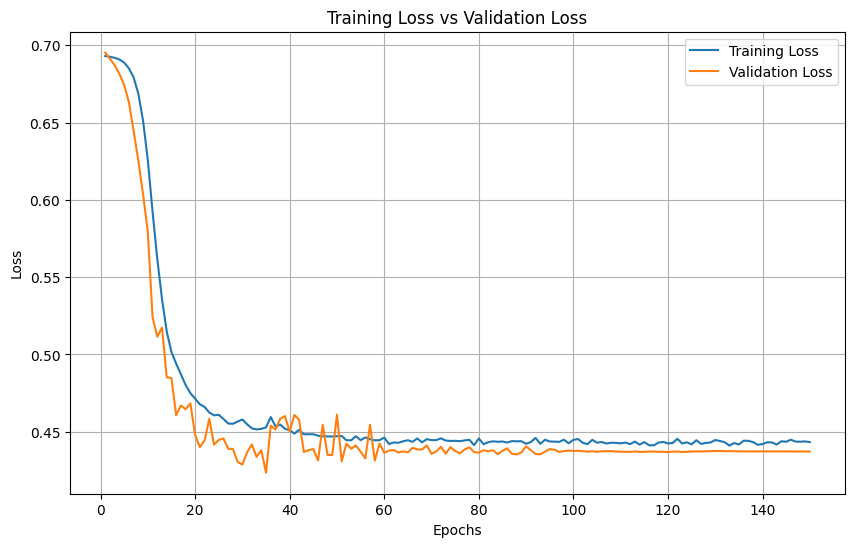

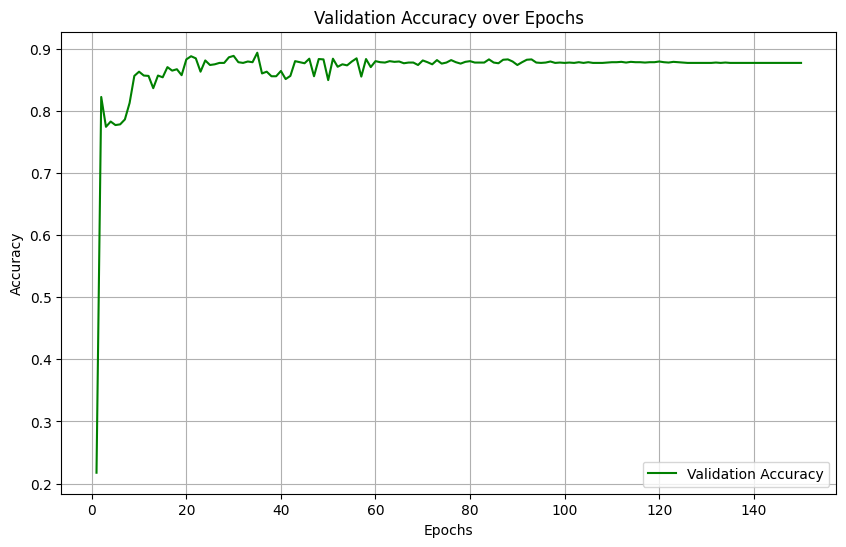

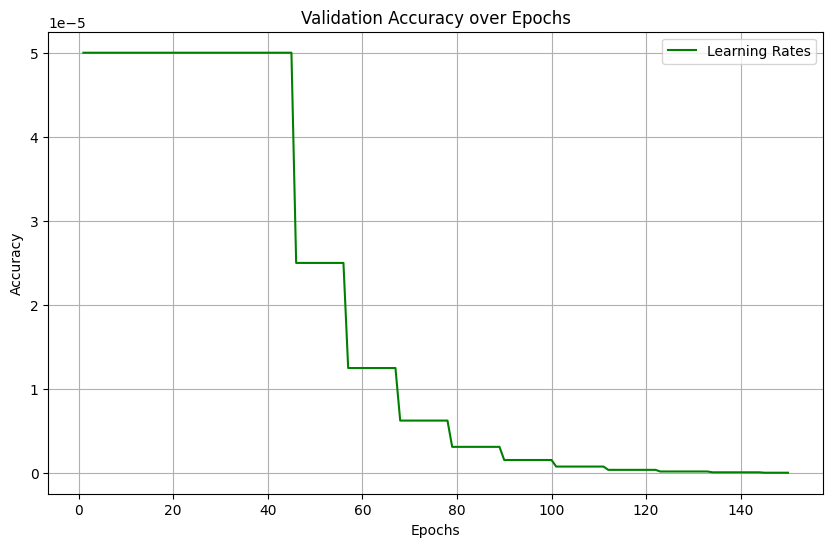

Model for bin 12 saved to 3DCholesterolModels-5A_exp5/model_bin_12.pth
1925 is length of subset grid
Training on bin 13
Bin 13, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6936, Validation Accuracy: 0.2175, Grad Norm: 0.0646, LR: 0.000050
Bin 13, Epoch 11/150, Train Loss: 0.6329, Validation Loss: 0.5857, Validation Accuracy: 0.8565, Grad Norm: 3.3560, LR: 0.000050
Bin 13, Epoch 21/150, Train Loss: 0.4863, Validation Loss: 0.5124, Validation Accuracy: 0.8000, Grad Norm: 6.1366, LR: 0.000050
Bin 13, Epoch 31/150, Train Loss: 0.4637, Validation Loss: 0.4546, Validation Accuracy: 0.8599, Grad Norm: 0.3960, LR: 0.000050
Bin 13, Epoch 41/150, Train Loss: 0.4541, Validation Loss: 0.4312, Validation Accuracy: 0.8881, Grad Norm: 3.7640, LR: 0.000050
Bin 13, Epoch 51/150, Train Loss: 0.4485, Validation Loss: 0.4316, Validation Accuracy: 0.8842, Grad Norm: 0.3002, LR: 0.000050
Bin 13, Epoch 61/150, Train Loss: 0.4451, Validation Loss: 0.4577, Validation Accuracy: 0.8508, Grad Norm: 5.6331

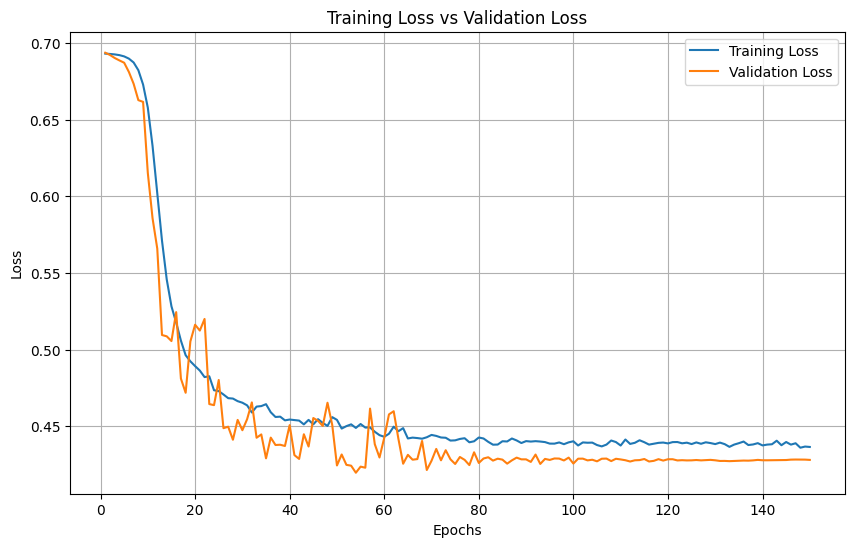

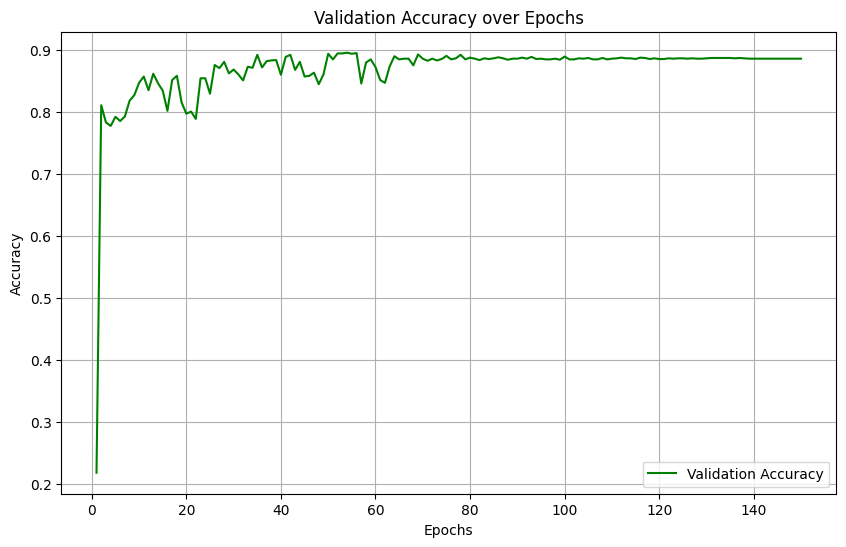

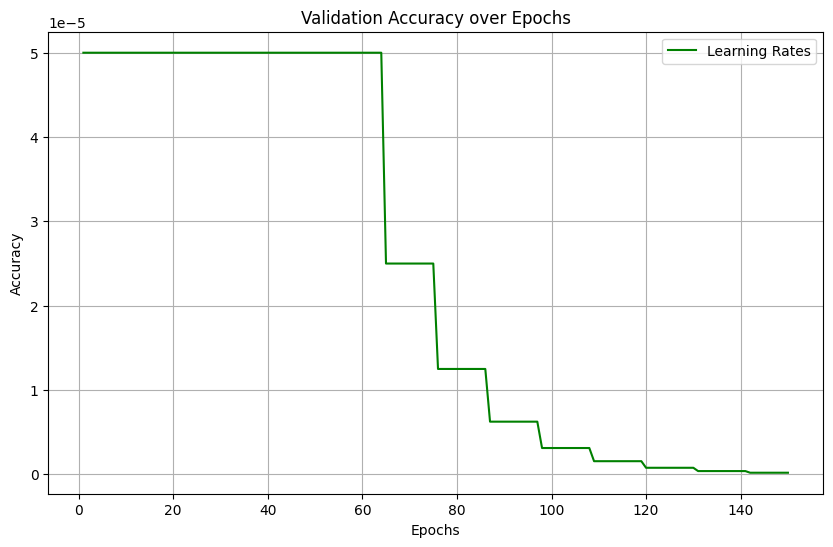

Model for bin 13 saved to 3DCholesterolModels-5A_exp5/model_bin_13.pth
1925 is length of subset grid
Training on bin 14
Bin 14, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6836, Validation Accuracy: 0.7825, Grad Norm: 0.0699, LR: 0.000050
Bin 14, Epoch 11/150, Train Loss: 0.5943, Validation Loss: 0.5350, Validation Accuracy: 0.8582, Grad Norm: 3.3659, LR: 0.000050
Bin 14, Epoch 21/150, Train Loss: 0.4777, Validation Loss: 0.4987, Validation Accuracy: 0.8226, Grad Norm: 1.3741, LR: 0.000050
Bin 14, Epoch 31/150, Train Loss: 0.4602, Validation Loss: 0.4480, Validation Accuracy: 0.8695, Grad Norm: 1.2578, LR: 0.000050
Bin 14, Epoch 41/150, Train Loss: 0.4552, Validation Loss: 0.4342, Validation Accuracy: 0.8802, Grad Norm: 2.5114, LR: 0.000025
Bin 14, Epoch 51/150, Train Loss: 0.4539, Validation Loss: 0.4330, Validation Accuracy: 0.8819, Grad Norm: 5.0809, LR: 0.000025
Bin 14, Epoch 61/150, Train Loss: 0.4507, Validation Loss: 0.4377, Validation Accuracy: 0.8780, Grad Norm: 6.4121

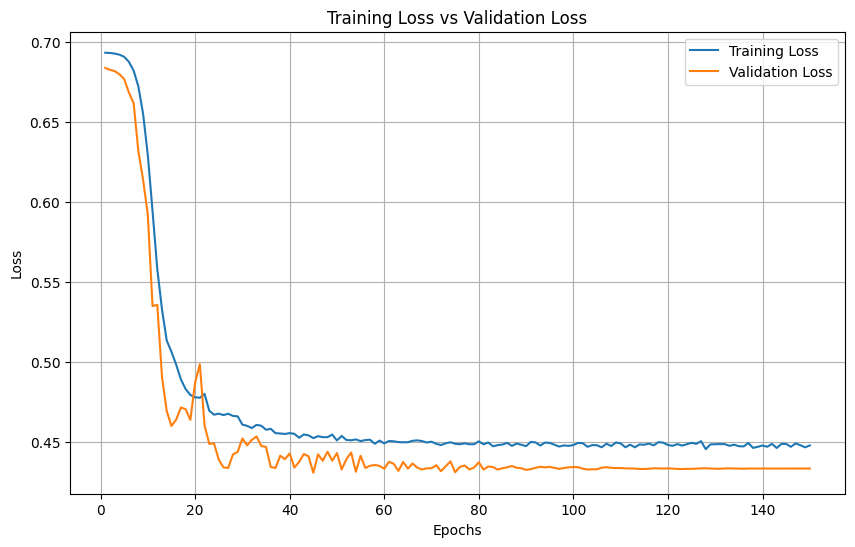

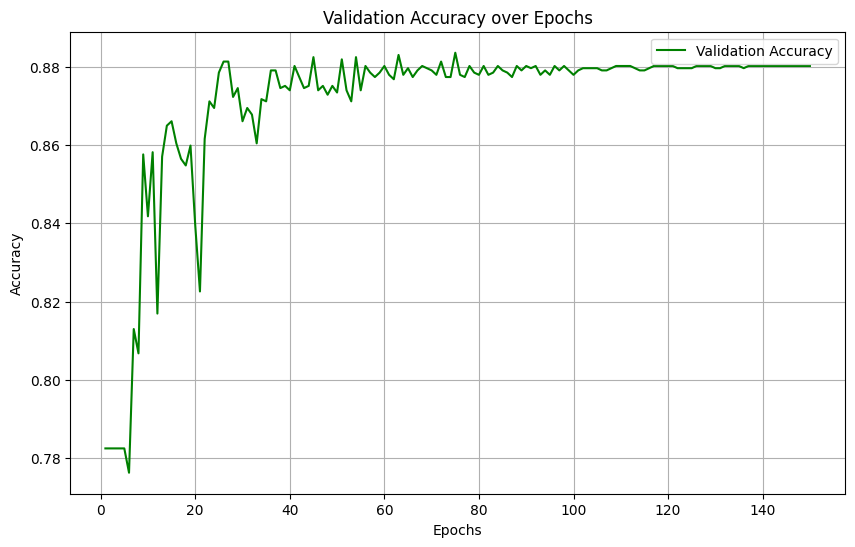

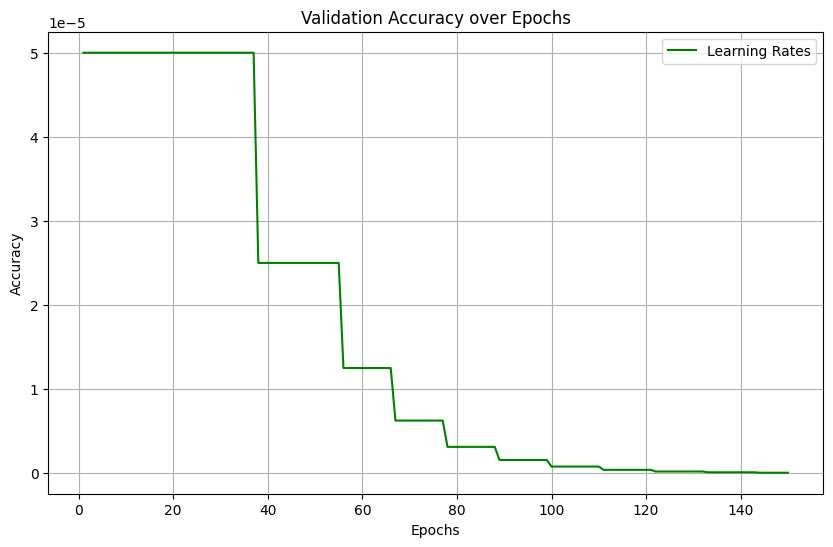

Model for bin 14 saved to 3DCholesterolModels-5A_exp5/model_bin_14.pth
1925 is length of subset grid
Training on bin 15
Bin 15, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7026, Validation Accuracy: 0.2175, Grad Norm: 0.0525, LR: 0.000050
Bin 15, Epoch 11/150, Train Loss: 0.6249, Validation Loss: 0.5401, Validation Accuracy: 0.8441, Grad Norm: 2.5145, LR: 0.000050
Bin 15, Epoch 21/150, Train Loss: 0.4576, Validation Loss: 0.4398, Validation Accuracy: 0.8842, Grad Norm: 3.1243, LR: 0.000050
Bin 15, Epoch 31/150, Train Loss: 0.4466, Validation Loss: 0.4358, Validation Accuracy: 0.8808, Grad Norm: 0.3313, LR: 0.000050
Bin 15, Epoch 41/150, Train Loss: 0.4424, Validation Loss: 0.4258, Validation Accuracy: 0.8887, Grad Norm: 3.6859, LR: 0.000050
Bin 15, Epoch 51/150, Train Loss: 0.4420, Validation Loss: 0.4248, Validation Accuracy: 0.8904, Grad Norm: 3.8387, LR: 0.000050
Bin 15, Epoch 61/150, Train Loss: 0.4386, Validation Loss: 0.4218, Validation Accuracy: 0.8932, Grad Norm: 6.5124

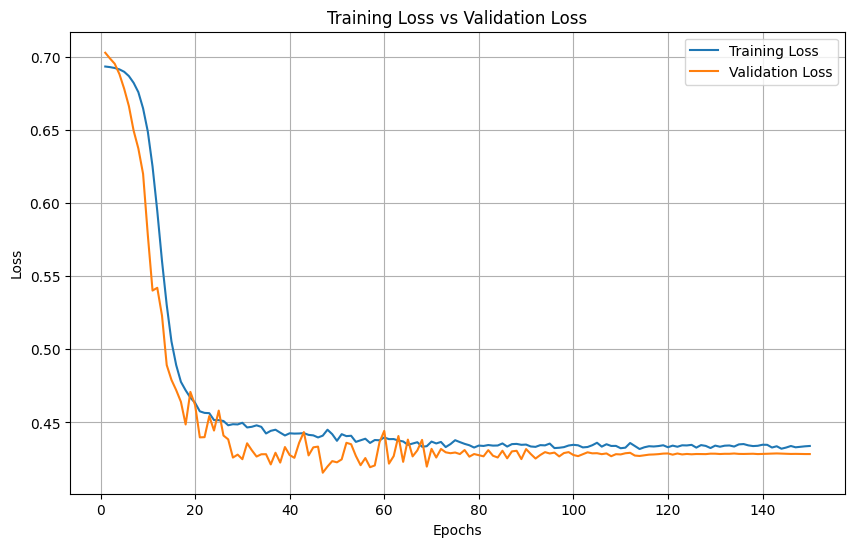

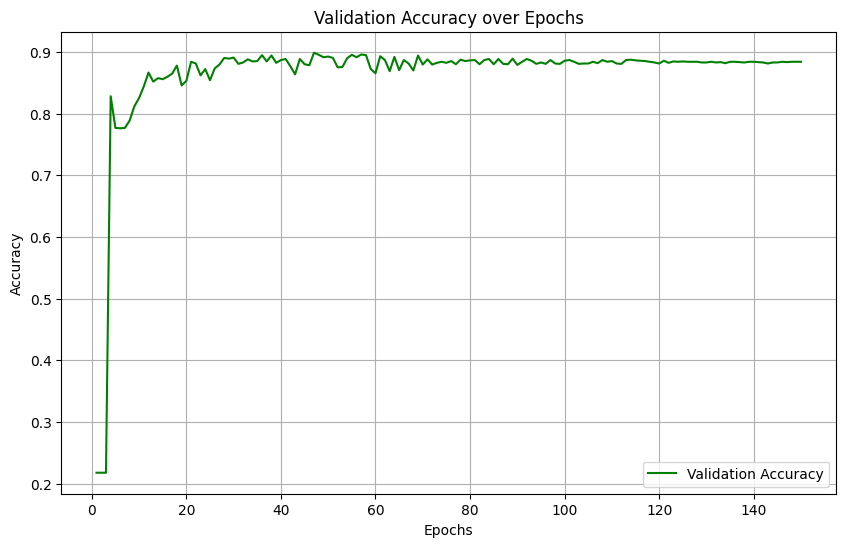

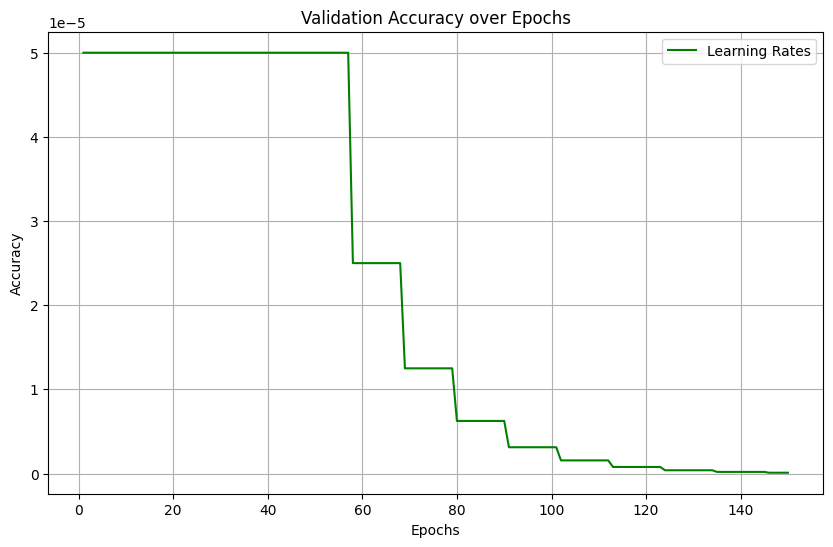

Model for bin 15 saved to 3DCholesterolModels-5A_exp5/model_bin_15.pth
1925 is length of subset grid
Training on bin 16
Bin 16, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6879, Validation Accuracy: 0.7825, Grad Norm: 0.0324, LR: 0.000050
Bin 16, Epoch 11/150, Train Loss: 0.5875, Validation Loss: 0.5642, Validation Accuracy: 0.8192, Grad Norm: 1.5284, LR: 0.000050
Bin 16, Epoch 21/150, Train Loss: 0.4741, Validation Loss: 0.4576, Validation Accuracy: 0.8655, Grad Norm: 5.4828, LR: 0.000050
Bin 16, Epoch 31/150, Train Loss: 0.4623, Validation Loss: 0.4524, Validation Accuracy: 0.8661, Grad Norm: 0.2893, LR: 0.000050
Bin 16, Epoch 41/150, Train Loss: 0.4559, Validation Loss: 0.4443, Validation Accuracy: 0.8734, Grad Norm: 2.5713, LR: 0.000050
Bin 16, Epoch 51/150, Train Loss: 0.4496, Validation Loss: 0.4445, Validation Accuracy: 0.8701, Grad Norm: 1.8567, LR: 0.000050
Bin 16, Epoch 61/150, Train Loss: 0.4484, Validation Loss: 0.4278, Validation Accuracy: 0.8898, Grad Norm: 4.4939

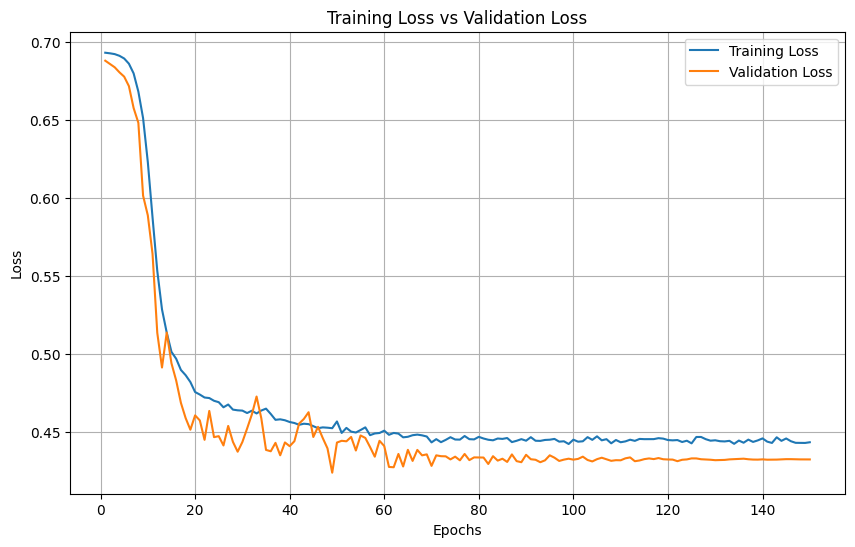

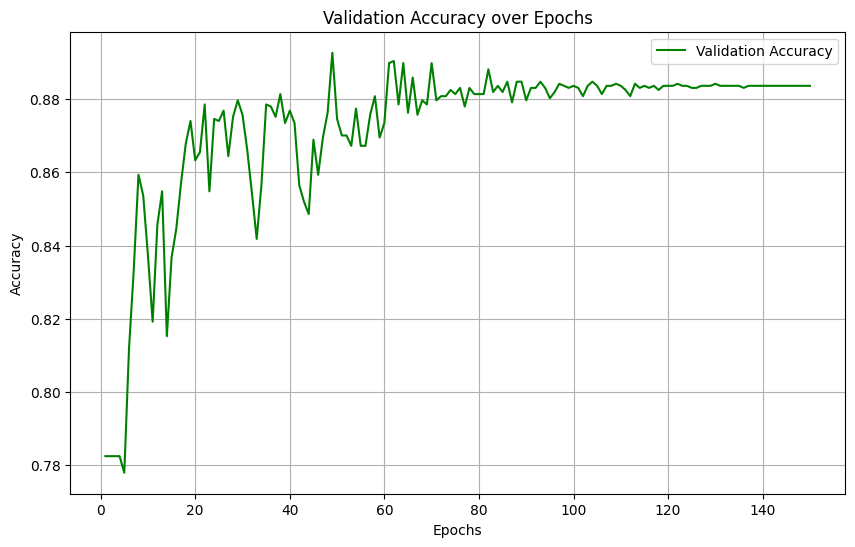

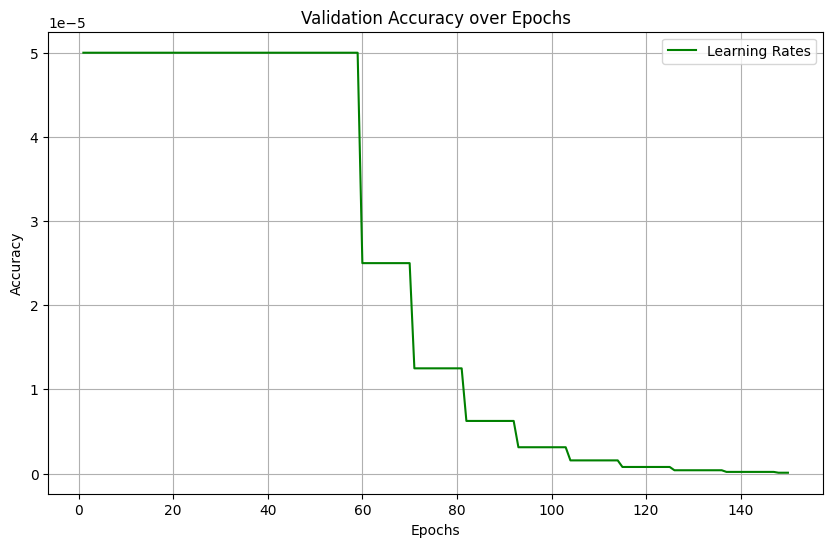

Model for bin 16 saved to 3DCholesterolModels-5A_exp5/model_bin_16.pth
1925 is length of subset grid
Training on bin 17
Bin 17, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6831, Validation Accuracy: 0.7825, Grad Norm: 0.1167, LR: 0.000050
Bin 17, Epoch 11/150, Train Loss: 0.5560, Validation Loss: 0.5331, Validation Accuracy: 0.8260, Grad Norm: 1.1451, LR: 0.000050
Bin 17, Epoch 21/150, Train Loss: 0.4637, Validation Loss: 0.4681, Validation Accuracy: 0.8469, Grad Norm: 3.5218, LR: 0.000050
Bin 17, Epoch 31/150, Train Loss: 0.4531, Validation Loss: 0.4349, Validation Accuracy: 0.8831, Grad Norm: 4.1656, LR: 0.000050
Bin 17, Epoch 41/150, Train Loss: 0.4509, Validation Loss: 0.4424, Validation Accuracy: 0.8689, Grad Norm: 1.6018, LR: 0.000050
Bin 17, Epoch 51/150, Train Loss: 0.4472, Validation Loss: 0.4281, Validation Accuracy: 0.8904, Grad Norm: 0.4306, LR: 0.000025
Bin 17, Epoch 61/150, Train Loss: 0.4457, Validation Loss: 0.4292, Validation Accuracy: 0.8893, Grad Norm: 2.9329

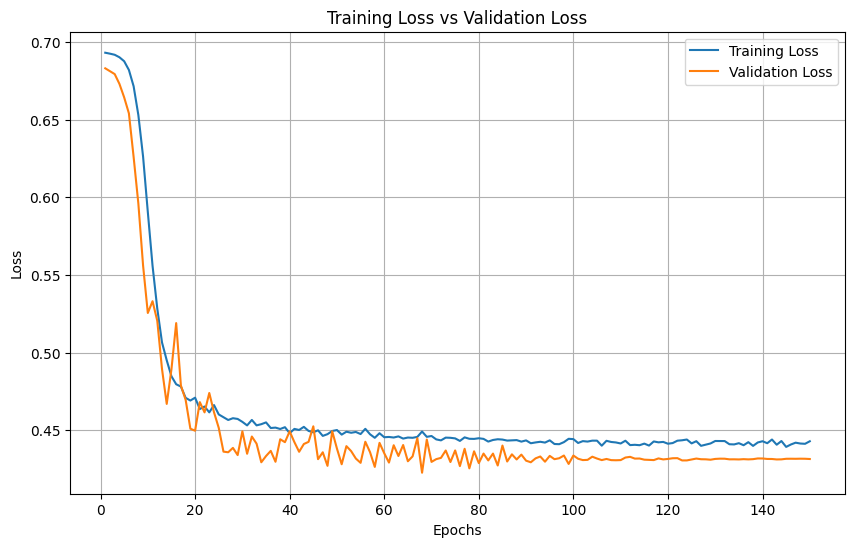

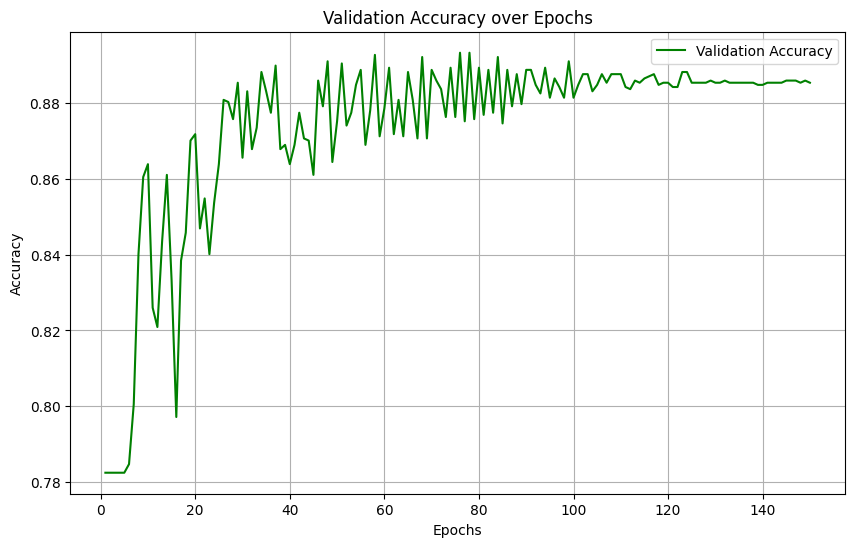

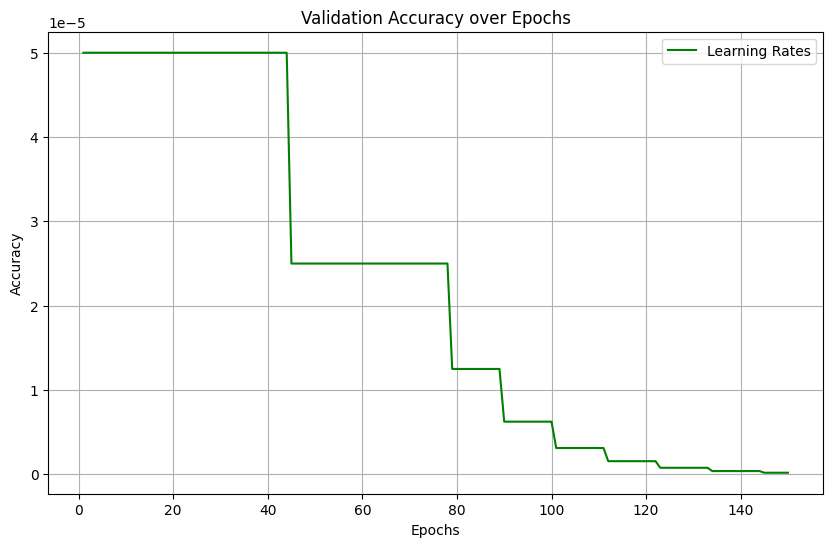

Model for bin 17 saved to 3DCholesterolModels-5A_exp5/model_bin_17.pth
1925 is length of subset grid
Training on bin 18
Bin 18, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6843, Validation Accuracy: 0.7825, Grad Norm: 0.0513, LR: 0.000050
Bin 18, Epoch 11/150, Train Loss: 0.5962, Validation Loss: 0.5701, Validation Accuracy: 0.8169, Grad Norm: 2.1936, LR: 0.000050
Bin 18, Epoch 21/150, Train Loss: 0.4710, Validation Loss: 0.4665, Validation Accuracy: 0.8542, Grad Norm: 4.5348, LR: 0.000050
Bin 18, Epoch 31/150, Train Loss: 0.4590, Validation Loss: 0.4752, Validation Accuracy: 0.8339, Grad Norm: 2.1315, LR: 0.000050
Bin 18, Epoch 41/150, Train Loss: 0.4526, Validation Loss: 0.4250, Validation Accuracy: 0.8927, Grad Norm: 0.7157, LR: 0.000025
Bin 18, Epoch 51/150, Train Loss: 0.4489, Validation Loss: 0.4439, Validation Accuracy: 0.8718, Grad Norm: 2.2070, LR: 0.000025
Bin 18, Epoch 61/150, Train Loss: 0.4510, Validation Loss: 0.4425, Validation Accuracy: 0.8723, Grad Norm: 1.5148

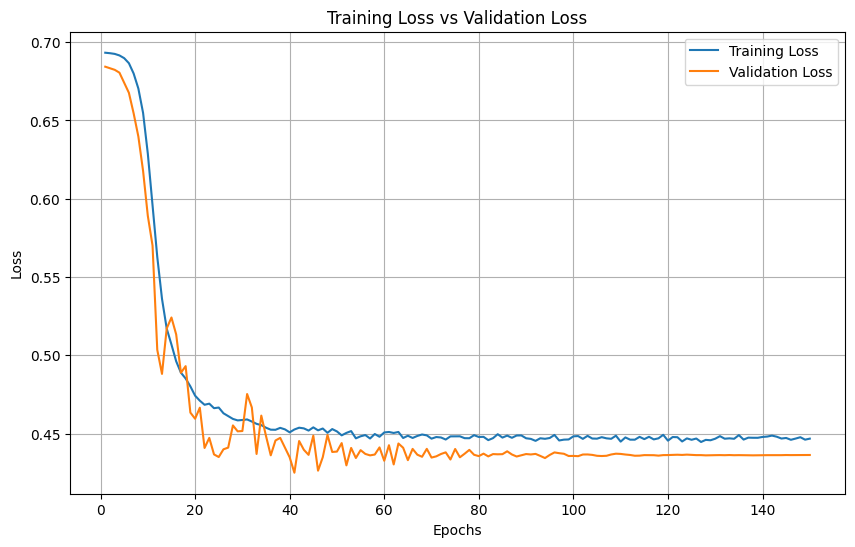

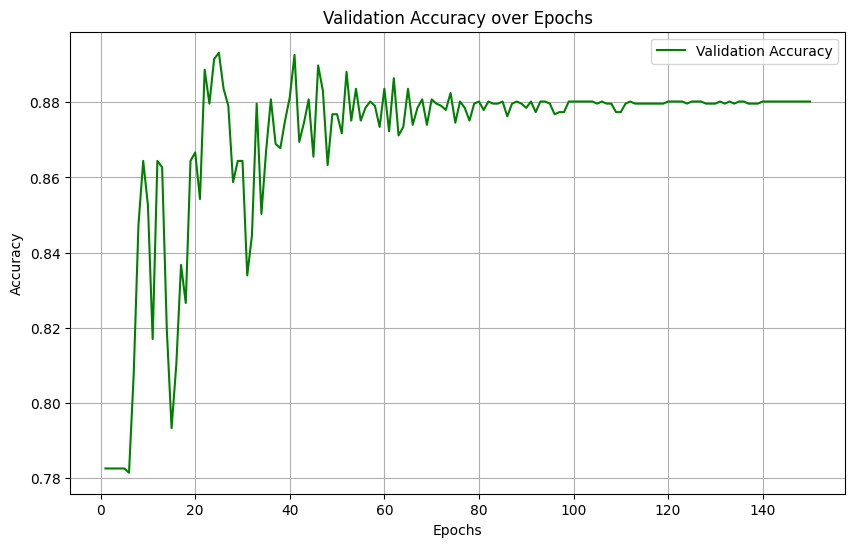

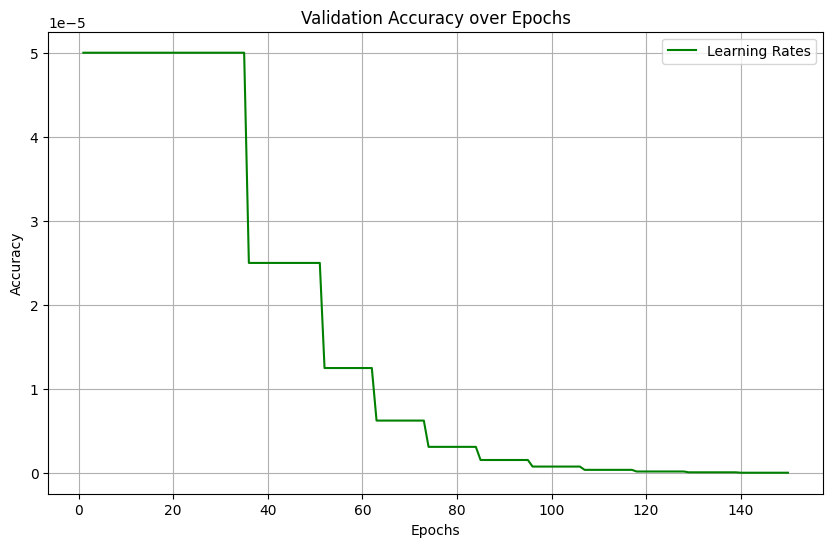

Model for bin 18 saved to 3DCholesterolModels-5A_exp5/model_bin_18.pth
1925 is length of subset grid
Training on bin 19
Bin 19, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6907, Validation Accuracy: 0.7825, Grad Norm: 0.0223, LR: 0.000050
Bin 19, Epoch 11/150, Train Loss: 0.6088, Validation Loss: 0.5660, Validation Accuracy: 0.8435, Grad Norm: 2.7714, LR: 0.000050
Bin 19, Epoch 21/150, Train Loss: 0.4754, Validation Loss: 0.4607, Validation Accuracy: 0.8605, Grad Norm: 3.5807, LR: 0.000050
Bin 19, Epoch 31/150, Train Loss: 0.4603, Validation Loss: 0.4525, Validation Accuracy: 0.8650, Grad Norm: 0.7160, LR: 0.000050
Bin 19, Epoch 41/150, Train Loss: 0.4542, Validation Loss: 0.4631, Validation Accuracy: 0.8480, Grad Norm: 1.9815, LR: 0.000050
Bin 19, Epoch 51/150, Train Loss: 0.4509, Validation Loss: 0.4366, Validation Accuracy: 0.8780, Grad Norm: 1.2774, LR: 0.000025
Bin 19, Epoch 61/150, Train Loss: 0.4488, Validation Loss: 0.4249, Validation Accuracy: 0.8876, Grad Norm: 6.3364

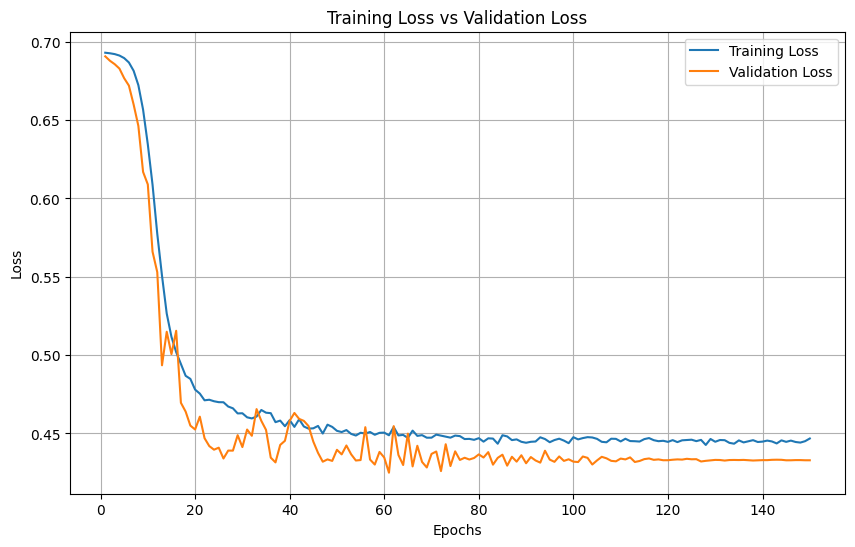

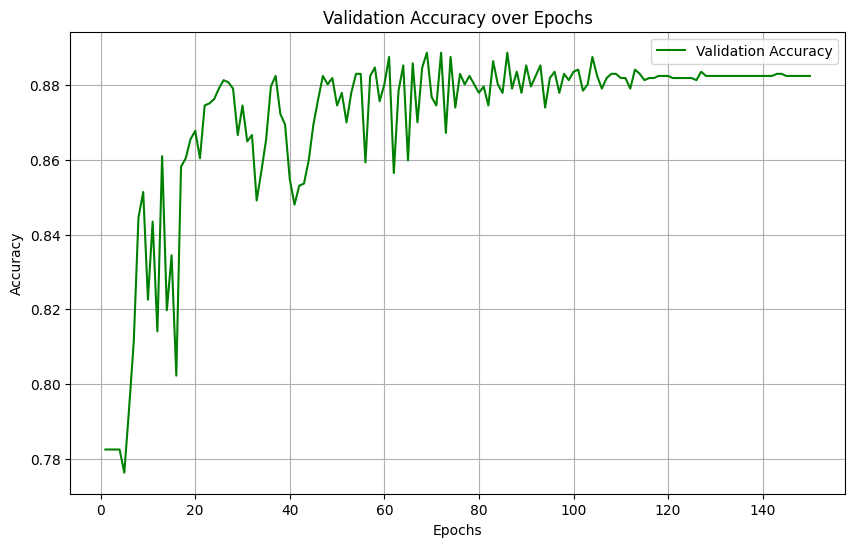

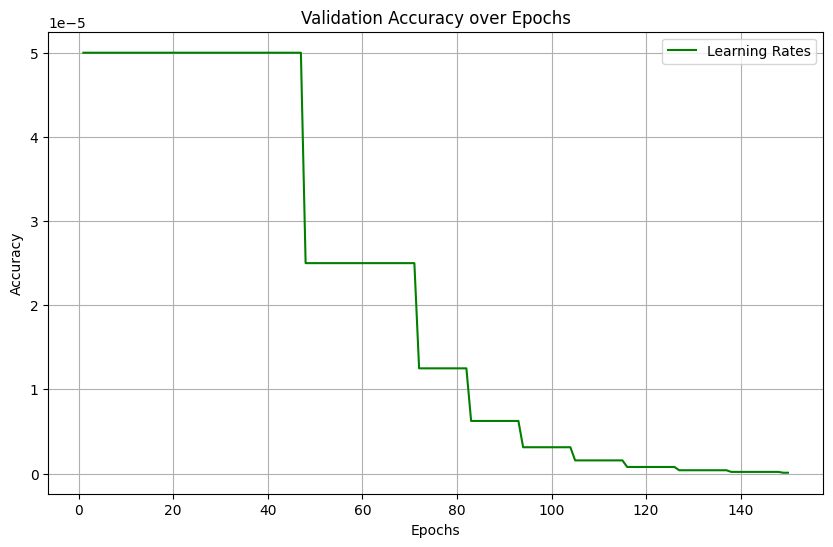

Model for bin 19 saved to 3DCholesterolModels-5A_exp5/model_bin_19.pth
1925 is length of subset grid
Training on bin 20
Bin 20, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6912, Validation Accuracy: 0.7825, Grad Norm: 0.0641, LR: 0.000050
Bin 20, Epoch 11/150, Train Loss: 0.6043, Validation Loss: 0.5506, Validation Accuracy: 0.8542, Grad Norm: 1.4924, LR: 0.000050
Bin 20, Epoch 21/150, Train Loss: 0.4803, Validation Loss: 0.4520, Validation Accuracy: 0.8734, Grad Norm: 5.3846, LR: 0.000050
Bin 20, Epoch 31/150, Train Loss: 0.4733, Validation Loss: 0.4657, Validation Accuracy: 0.8480, Grad Norm: 5.5256, LR: 0.000050
Bin 20, Epoch 41/150, Train Loss: 0.4582, Validation Loss: 0.4380, Validation Accuracy: 0.8746, Grad Norm: 1.6972, LR: 0.000050
Bin 20, Epoch 51/150, Train Loss: 0.4553, Validation Loss: 0.4397, Validation Accuracy: 0.8757, Grad Norm: 0.3533, LR: 0.000025
Bin 20, Epoch 61/150, Train Loss: 0.4549, Validation Loss: 0.4345, Validation Accuracy: 0.8814, Grad Norm: 4.2755

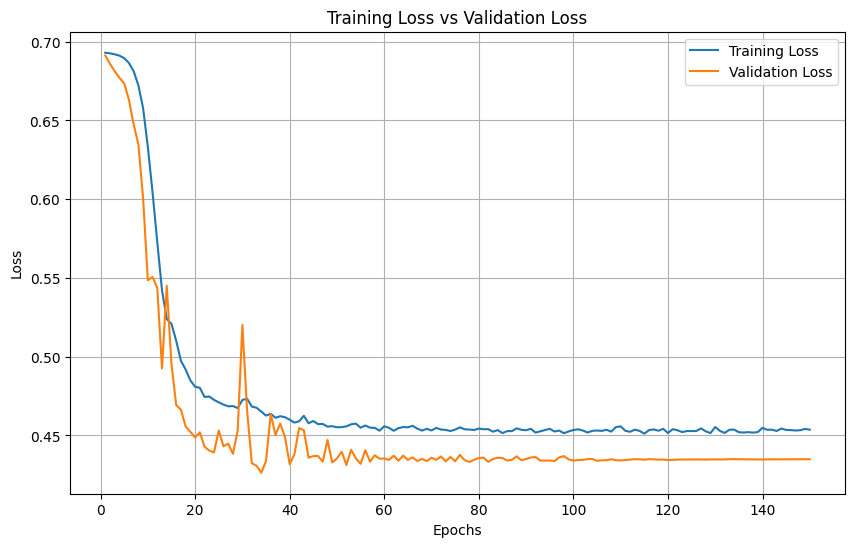

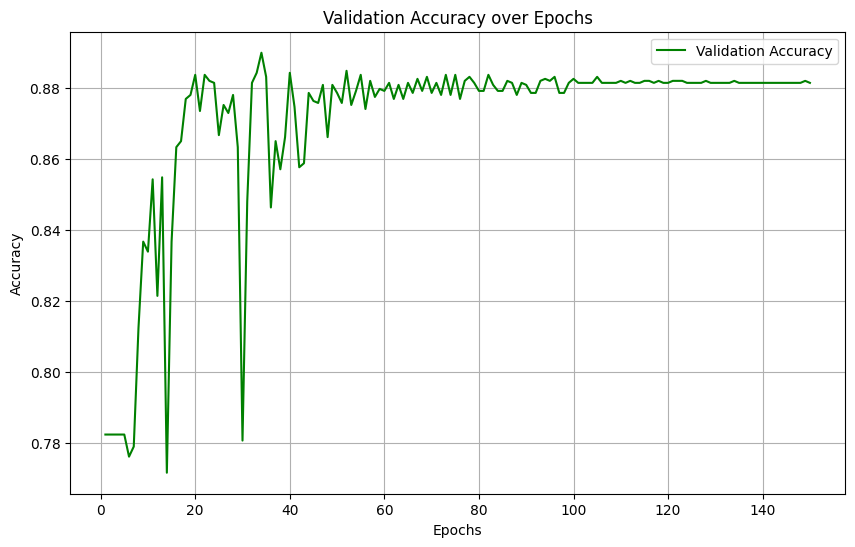

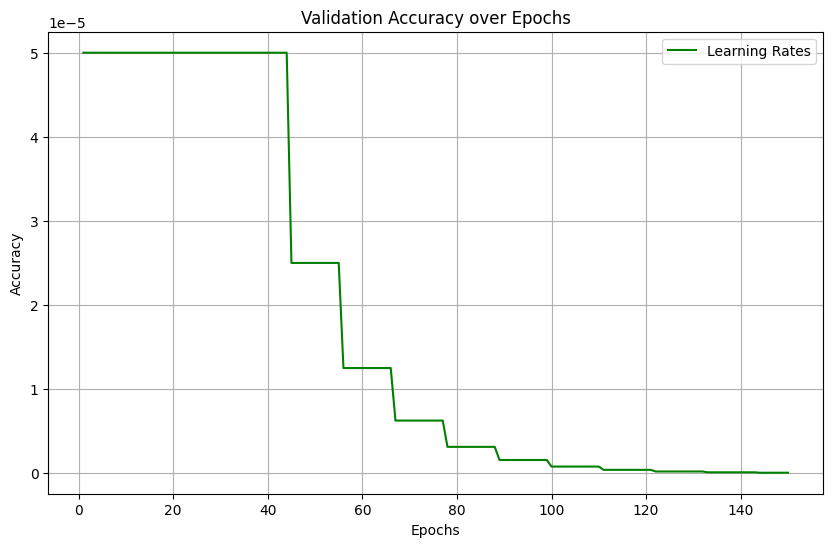

Model for bin 20 saved to 3DCholesterolModels-5A_exp5/model_bin_20.pth
1925 is length of subset grid
Training on bin 21
Bin 21, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6900, Validation Accuracy: 0.7825, Grad Norm: 0.0304, LR: 0.000050
Bin 21, Epoch 11/150, Train Loss: 0.5846, Validation Loss: 0.5341, Validation Accuracy: 0.8463, Grad Norm: 1.7066, LR: 0.000050
Bin 21, Epoch 21/150, Train Loss: 0.4694, Validation Loss: 0.4625, Validation Accuracy: 0.8554, Grad Norm: 6.4606, LR: 0.000050
Bin 21, Epoch 31/150, Train Loss: 0.4566, Validation Loss: 0.4594, Validation Accuracy: 0.8548, Grad Norm: 4.1533, LR: 0.000050
Bin 21, Epoch 41/150, Train Loss: 0.4504, Validation Loss: 0.4375, Validation Accuracy: 0.8774, Grad Norm: 3.9311, LR: 0.000025
Bin 21, Epoch 51/150, Train Loss: 0.4508, Validation Loss: 0.4319, Validation Accuracy: 0.8870, Grad Norm: 3.5217, LR: 0.000013
Bin 21, Epoch 61/150, Train Loss: 0.4494, Validation Loss: 0.4346, Validation Accuracy: 0.8836, Grad Norm: 2.3634

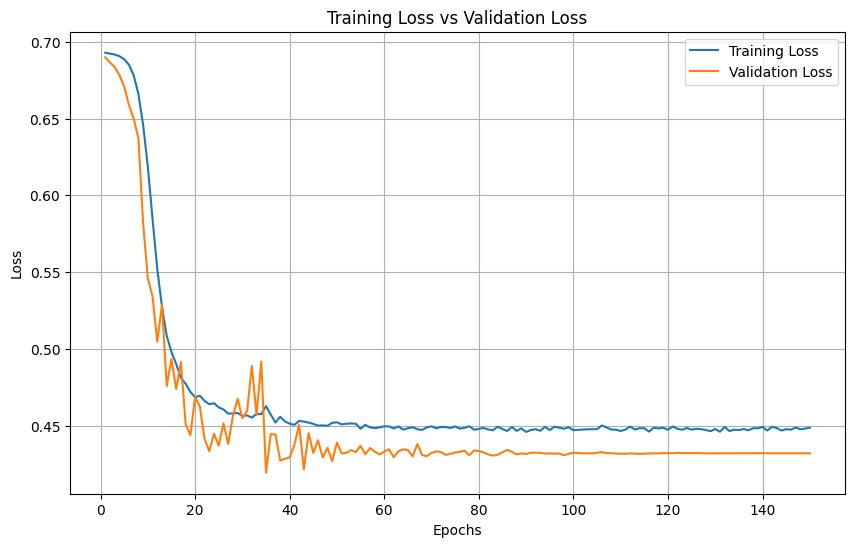

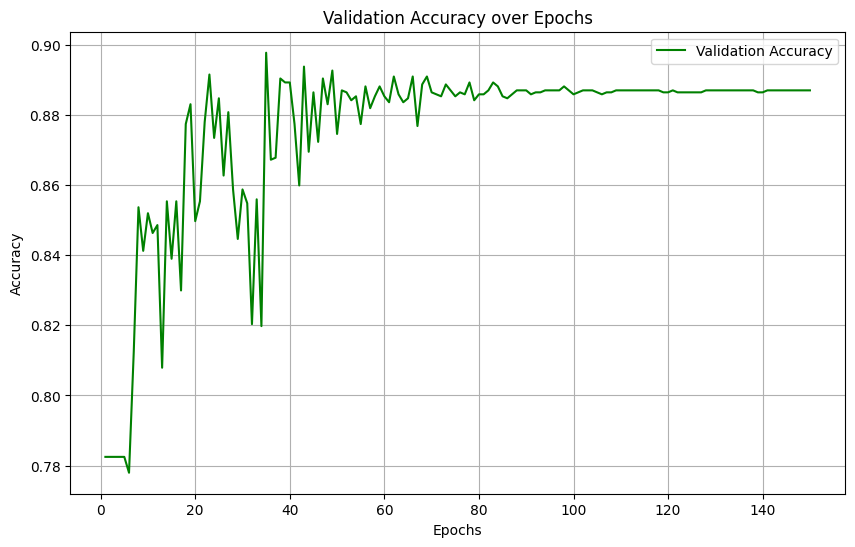

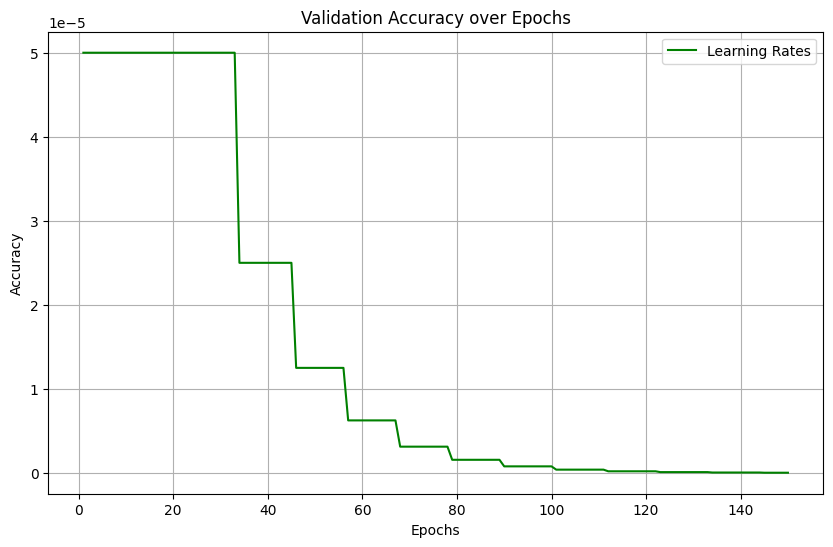

Model for bin 21 saved to 3DCholesterolModels-5A_exp5/model_bin_21.pth
1925 is length of subset grid
Training on bin 22
Bin 22, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6869, Validation Accuracy: 0.7825, Grad Norm: 0.0271, LR: 0.000050
Bin 22, Epoch 11/150, Train Loss: 0.5681, Validation Loss: 0.5340, Validation Accuracy: 0.8333, Grad Norm: 2.1709, LR: 0.000050
Bin 22, Epoch 21/150, Train Loss: 0.4628, Validation Loss: 0.4577, Validation Accuracy: 0.8638, Grad Norm: 2.1046, LR: 0.000050
Bin 22, Epoch 31/150, Train Loss: 0.4473, Validation Loss: 0.4299, Validation Accuracy: 0.8870, Grad Norm: 2.9682, LR: 0.000050
Bin 22, Epoch 41/150, Train Loss: 0.4451, Validation Loss: 0.4529, Validation Accuracy: 0.8593, Grad Norm: 1.8279, LR: 0.000050
Bin 22, Epoch 51/150, Train Loss: 0.4401, Validation Loss: 0.4434, Validation Accuracy: 0.8740, Grad Norm: 4.2155, LR: 0.000050
Bin 22, Epoch 61/150, Train Loss: 0.4338, Validation Loss: 0.4359, Validation Accuracy: 0.8774, Grad Norm: 3.5766

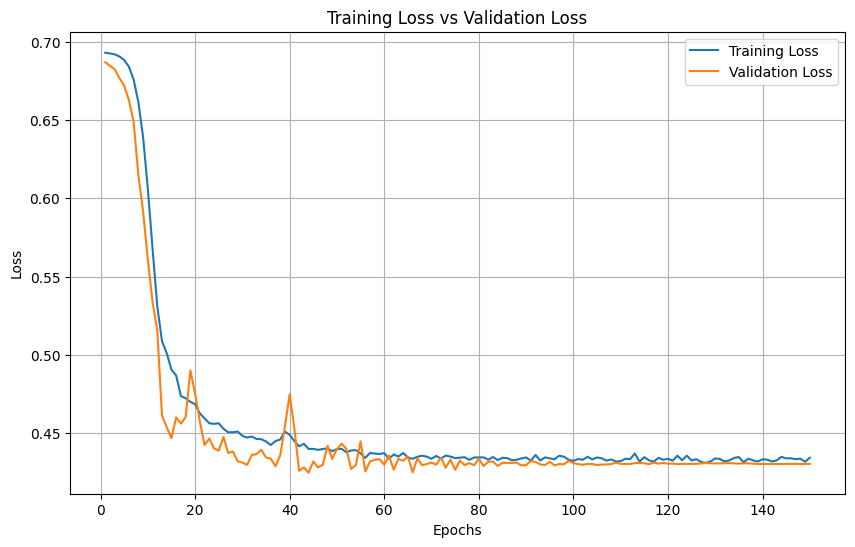

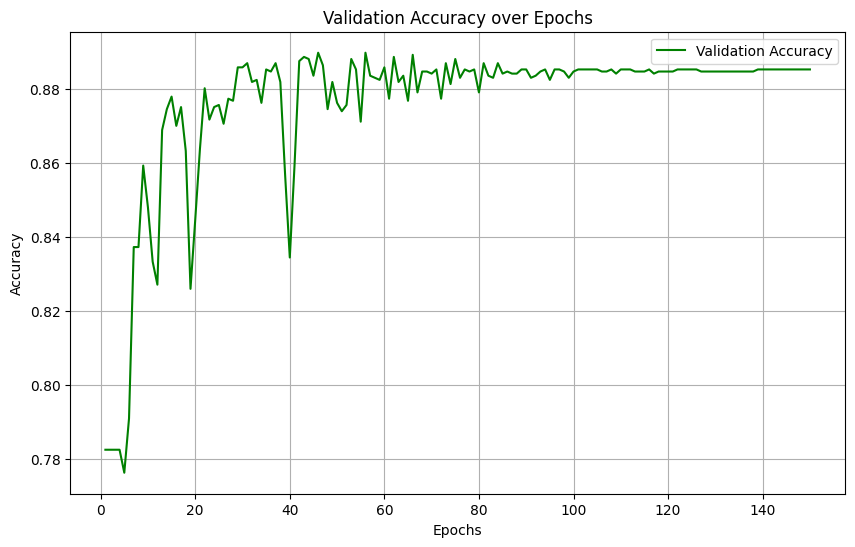

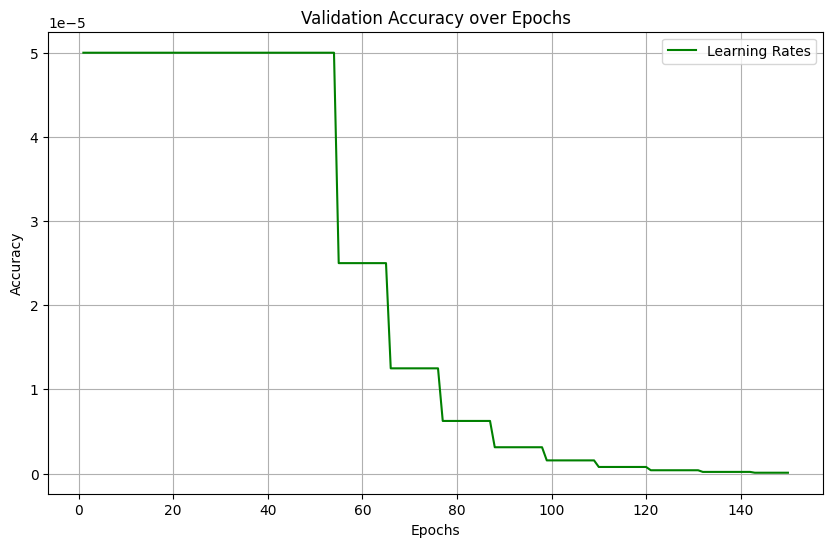

Model for bin 22 saved to 3DCholesterolModels-5A_exp5/model_bin_22.pth
1925 is length of subset grid
Training on bin 23
Bin 23, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6899, Validation Accuracy: 0.7825, Grad Norm: 0.0204, LR: 0.000050
Bin 23, Epoch 11/150, Train Loss: 0.6225, Validation Loss: 0.5888, Validation Accuracy: 0.8407, Grad Norm: 4.1086, LR: 0.000050
Bin 23, Epoch 21/150, Train Loss: 0.4692, Validation Loss: 0.4473, Validation Accuracy: 0.8763, Grad Norm: 2.2898, LR: 0.000050
Bin 23, Epoch 31/150, Train Loss: 0.4599, Validation Loss: 0.4612, Validation Accuracy: 0.8531, Grad Norm: 6.4670, LR: 0.000050
Bin 23, Epoch 41/150, Train Loss: 0.4525, Validation Loss: 0.4569, Validation Accuracy: 0.8548, Grad Norm: 0.6838, LR: 0.000050
Bin 23, Epoch 51/150, Train Loss: 0.4468, Validation Loss: 0.4338, Validation Accuracy: 0.8814, Grad Norm: 3.5181, LR: 0.000050
Bin 23, Epoch 61/150, Train Loss: 0.4472, Validation Loss: 0.4355, Validation Accuracy: 0.8785, Grad Norm: 3.0013

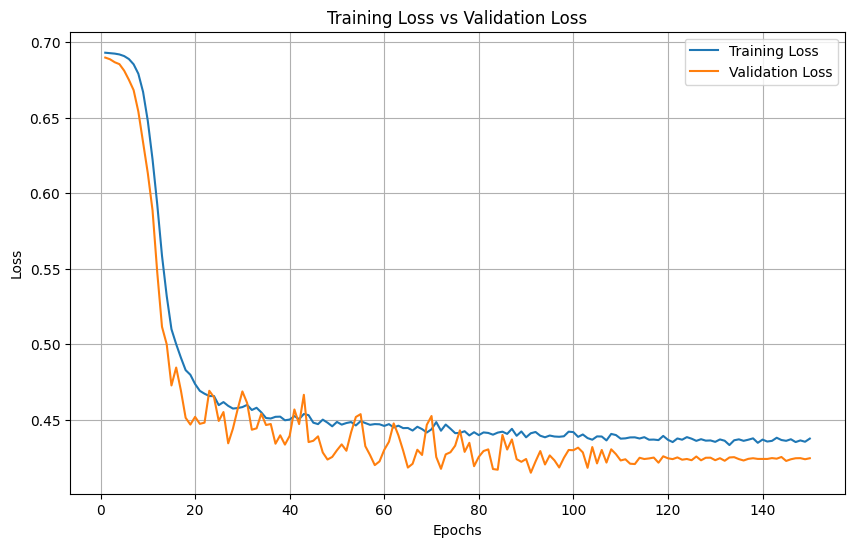

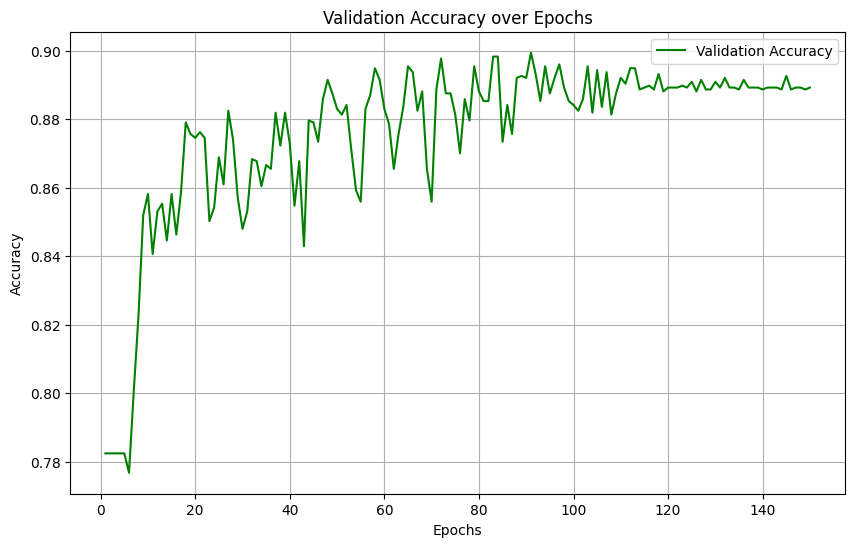

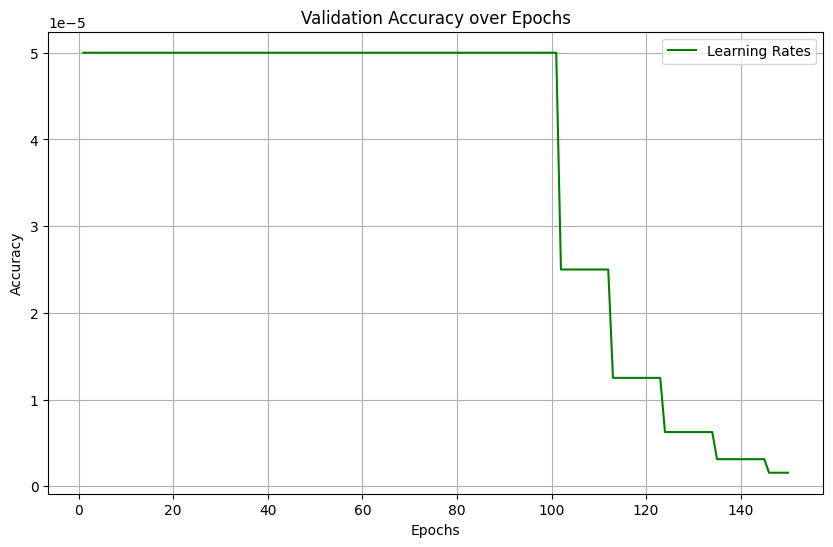

Model for bin 23 saved to 3DCholesterolModels-5A_exp5/model_bin_23.pth
1925 is length of subset grid
Training on bin 24
Bin 24, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7025, Validation Accuracy: 0.2175, Grad Norm: 0.1144, LR: 0.000050
Bin 24, Epoch 11/150, Train Loss: 0.6043, Validation Loss: 0.5562, Validation Accuracy: 0.8480, Grad Norm: 3.1950, LR: 0.000050
Bin 24, Epoch 21/150, Train Loss: 0.4701, Validation Loss: 0.4571, Validation Accuracy: 0.8751, Grad Norm: 3.5220, LR: 0.000050
Bin 24, Epoch 31/150, Train Loss: 0.4565, Validation Loss: 0.4397, Validation Accuracy: 0.8814, Grad Norm: 6.3881, LR: 0.000050
Bin 24, Epoch 41/150, Train Loss: 0.4468, Validation Loss: 0.4231, Validation Accuracy: 0.8955, Grad Norm: 1.1877, LR: 0.000050
Bin 24, Epoch 51/150, Train Loss: 0.4474, Validation Loss: 0.4529, Validation Accuracy: 0.8559, Grad Norm: 6.5197, LR: 0.000050
Bin 24, Epoch 61/150, Train Loss: 0.4435, Validation Loss: 0.4292, Validation Accuracy: 0.8870, Grad Norm: 2.3639

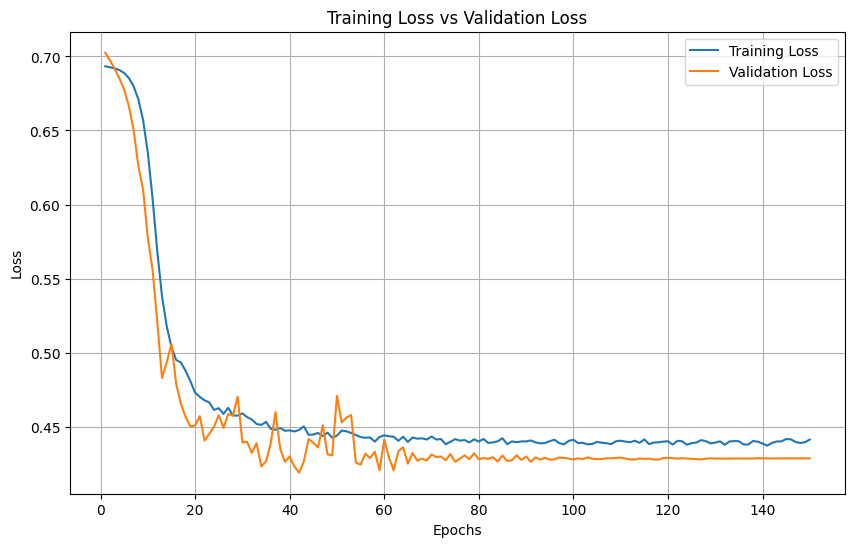

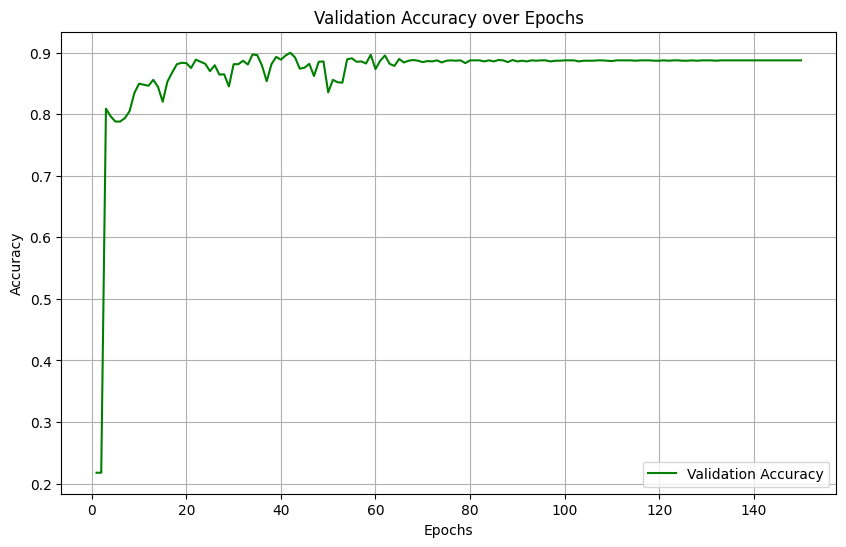

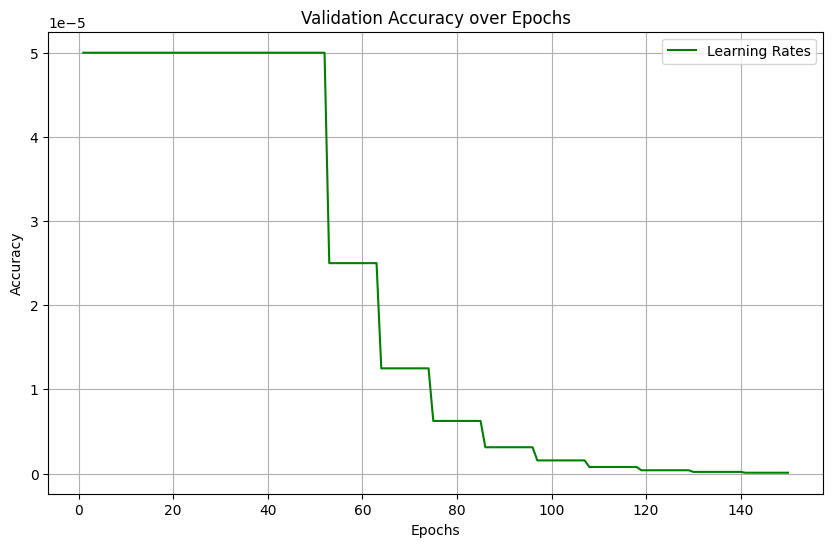

Model for bin 24 saved to 3DCholesterolModels-5A_exp5/model_bin_24.pth
1925 is length of subset grid
Training on bin 25
Bin 25, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6806, Validation Accuracy: 0.7825, Grad Norm: 0.0189, LR: 0.000050
Bin 25, Epoch 11/150, Train Loss: 0.5995, Validation Loss: 0.5566, Validation Accuracy: 0.8537, Grad Norm: 2.7083, LR: 0.000050
Bin 25, Epoch 21/150, Train Loss: 0.4740, Validation Loss: 0.4467, Validation Accuracy: 0.8768, Grad Norm: 2.5962, LR: 0.000050
Bin 25, Epoch 31/150, Train Loss: 0.4604, Validation Loss: 0.4538, Validation Accuracy: 0.8621, Grad Norm: 4.3296, LR: 0.000050
Bin 25, Epoch 41/150, Train Loss: 0.4575, Validation Loss: 0.4387, Validation Accuracy: 0.8746, Grad Norm: 0.8155, LR: 0.000025
Bin 25, Epoch 51/150, Train Loss: 0.4549, Validation Loss: 0.4453, Validation Accuracy: 0.8689, Grad Norm: 4.5339, LR: 0.000025
Bin 25, Epoch 61/150, Train Loss: 0.4480, Validation Loss: 0.4396, Validation Accuracy: 0.8718, Grad Norm: 1.1623

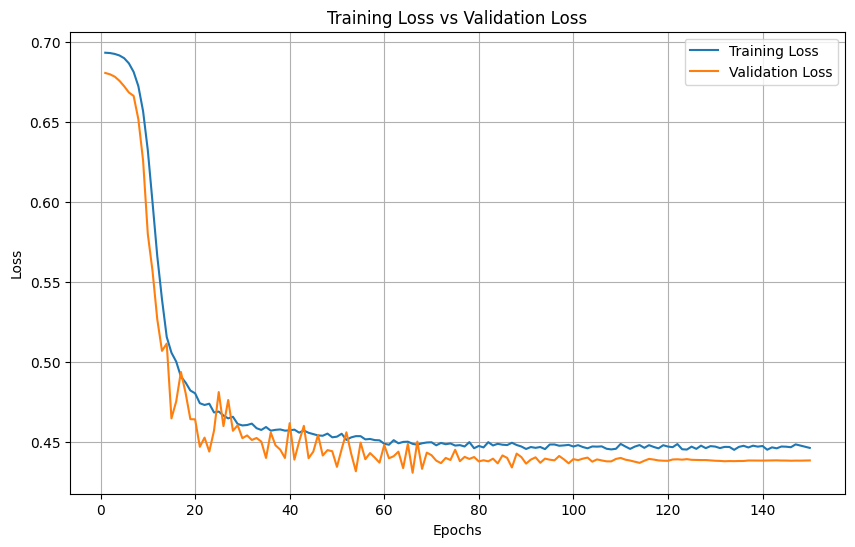

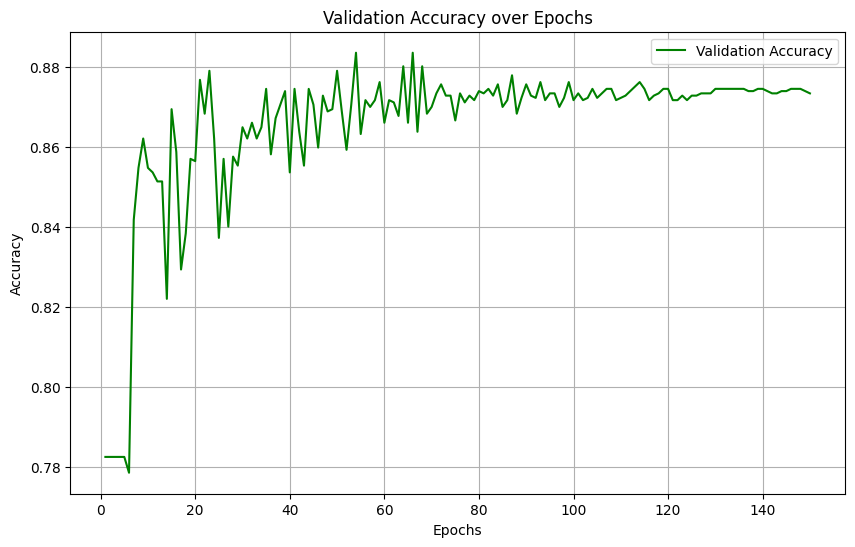

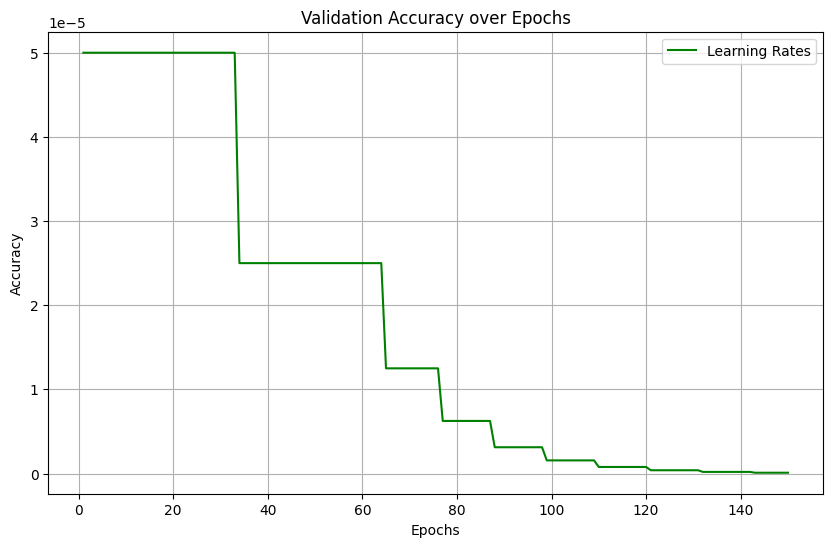

Model for bin 25 saved to 3DCholesterolModels-5A_exp5/model_bin_25.pth
1925 is length of subset grid
Training on bin 26
Bin 26, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6936, Validation Accuracy: 0.2181, Grad Norm: 0.0726, LR: 0.000050
Bin 26, Epoch 11/150, Train Loss: 0.5931, Validation Loss: 0.5214, Validation Accuracy: 0.8508, Grad Norm: 0.7793, LR: 0.000050
Bin 26, Epoch 21/150, Train Loss: 0.4772, Validation Loss: 0.4694, Validation Accuracy: 0.8588, Grad Norm: 3.0340, LR: 0.000050
Bin 26, Epoch 31/150, Train Loss: 0.4579, Validation Loss: 0.4380, Validation Accuracy: 0.8819, Grad Norm: 3.9071, LR: 0.000050
Bin 26, Epoch 41/150, Train Loss: 0.4576, Validation Loss: 0.4233, Validation Accuracy: 0.8932, Grad Norm: 6.3434, LR: 0.000050
Bin 26, Epoch 51/150, Train Loss: 0.4524, Validation Loss: 0.4269, Validation Accuracy: 0.8898, Grad Norm: 4.4245, LR: 0.000025
Bin 26, Epoch 61/150, Train Loss: 0.4508, Validation Loss: 0.4316, Validation Accuracy: 0.8864, Grad Norm: 2.1195

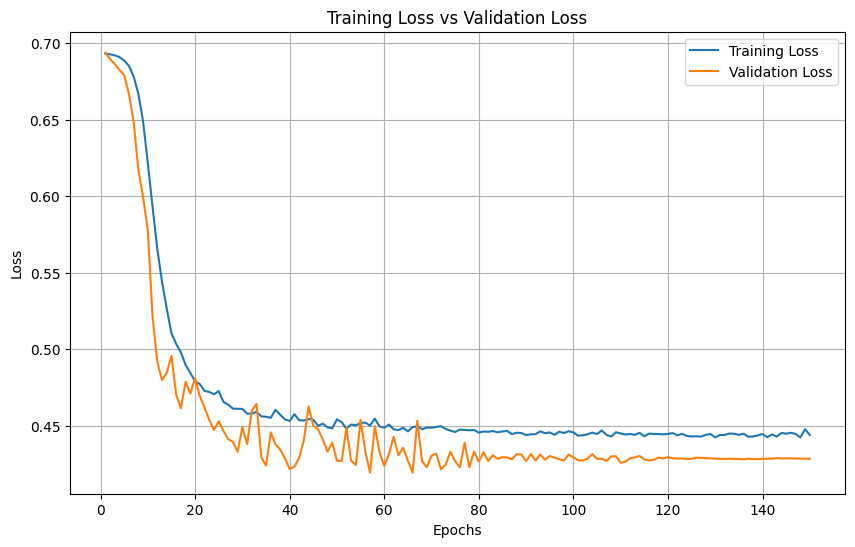

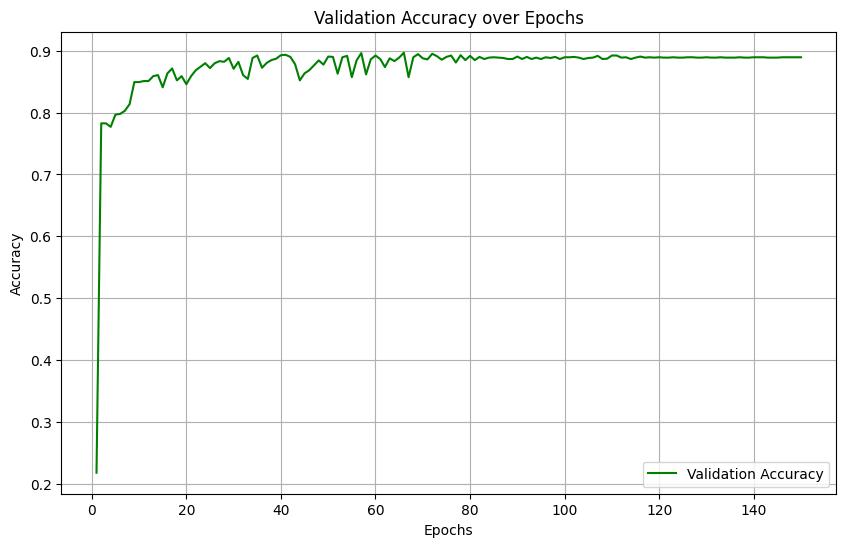

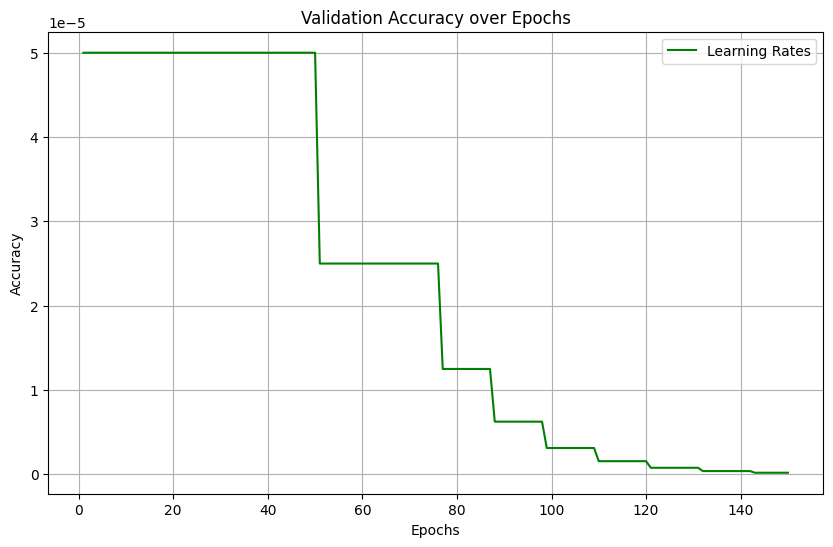

Model for bin 26 saved to 3DCholesterolModels-5A_exp5/model_bin_26.pth
1925 is length of subset grid
Training on bin 27
Bin 27, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6800, Validation Accuracy: 0.7825, Grad Norm: 0.0264, LR: 0.000050
Bin 27, Epoch 11/150, Train Loss: 0.5772, Validation Loss: 0.5310, Validation Accuracy: 0.8452, Grad Norm: 3.9125, LR: 0.000050
Bin 27, Epoch 21/150, Train Loss: 0.4698, Validation Loss: 0.4616, Validation Accuracy: 0.8655, Grad Norm: 0.7816, LR: 0.000050
Bin 27, Epoch 31/150, Train Loss: 0.4575, Validation Loss: 0.4438, Validation Accuracy: 0.8763, Grad Norm: 3.3895, LR: 0.000050
Bin 27, Epoch 41/150, Train Loss: 0.4563, Validation Loss: 0.4387, Validation Accuracy: 0.8774, Grad Norm: 3.9186, LR: 0.000050
Bin 27, Epoch 51/150, Train Loss: 0.4485, Validation Loss: 0.4481, Validation Accuracy: 0.8627, Grad Norm: 1.5878, LR: 0.000050
Bin 27, Epoch 61/150, Train Loss: 0.4498, Validation Loss: 0.4259, Validation Accuracy: 0.8910, Grad Norm: 6.2909

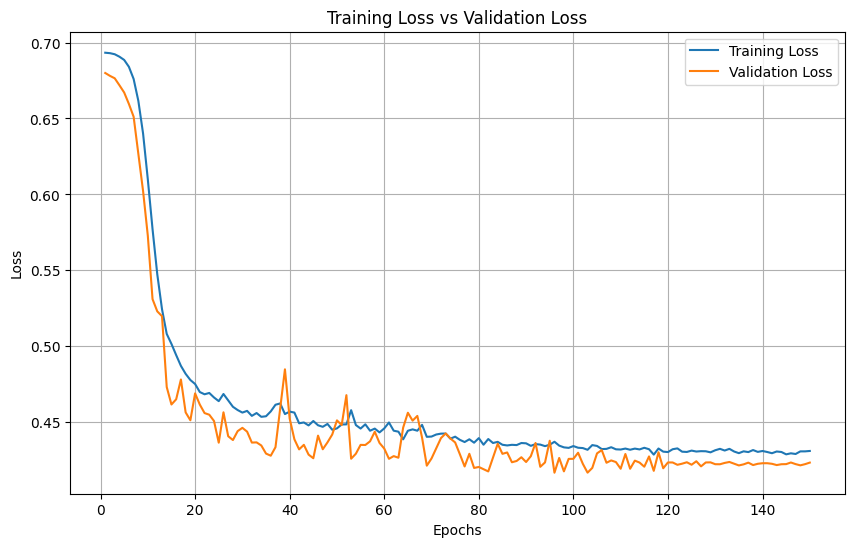

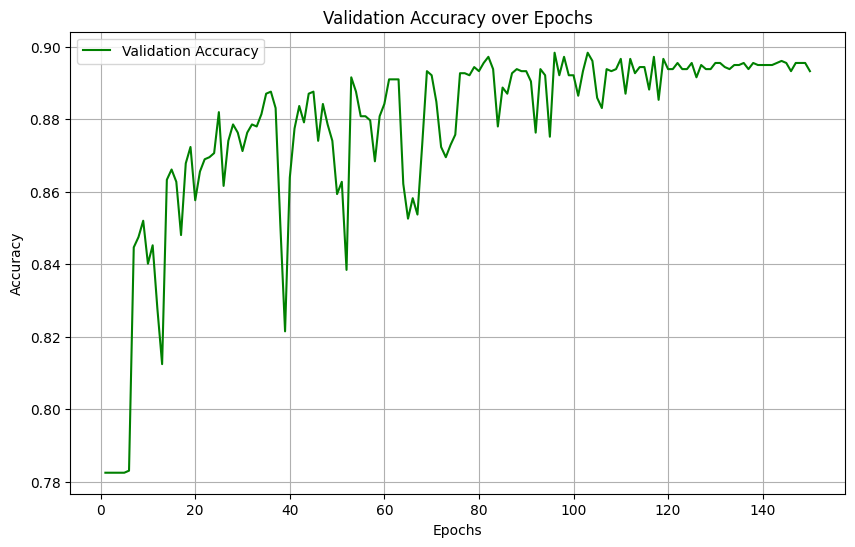

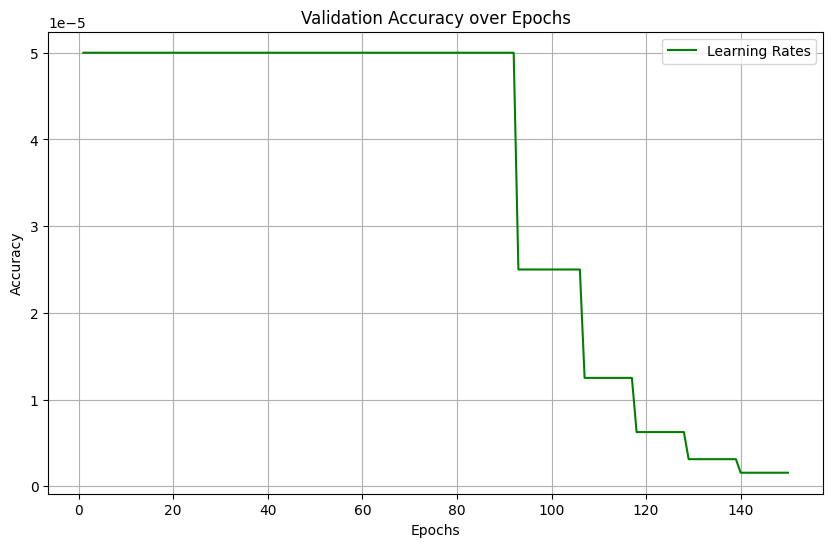

Model for bin 27 saved to 3DCholesterolModels-5A_exp5/model_bin_27.pth
1925 is length of subset grid
Training on bin 28
Bin 28, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6989, Validation Accuracy: 0.2175, Grad Norm: 0.0244, LR: 0.000050
Bin 28, Epoch 11/150, Train Loss: 0.6380, Validation Loss: 0.5803, Validation Accuracy: 0.8486, Grad Norm: 1.0681, LR: 0.000050
Bin 28, Epoch 21/150, Train Loss: 0.4665, Validation Loss: 0.4389, Validation Accuracy: 0.8881, Grad Norm: 5.7400, LR: 0.000050
Bin 28, Epoch 31/150, Train Loss: 0.4507, Validation Loss: 0.4569, Validation Accuracy: 0.8599, Grad Norm: 2.6065, LR: 0.000050
Bin 28, Epoch 41/150, Train Loss: 0.4445, Validation Loss: 0.4318, Validation Accuracy: 0.8808, Grad Norm: 1.2625, LR: 0.000025
Bin 28, Epoch 51/150, Train Loss: 0.4423, Validation Loss: 0.4338, Validation Accuracy: 0.8802, Grad Norm: 0.7755, LR: 0.000013
Bin 28, Epoch 61/150, Train Loss: 0.4406, Validation Loss: 0.4385, Validation Accuracy: 0.8791, Grad Norm: 1.6120

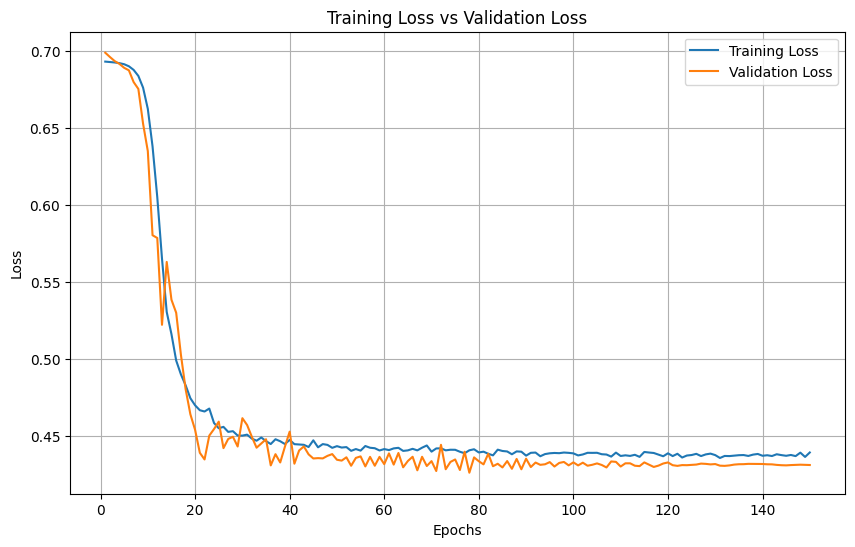

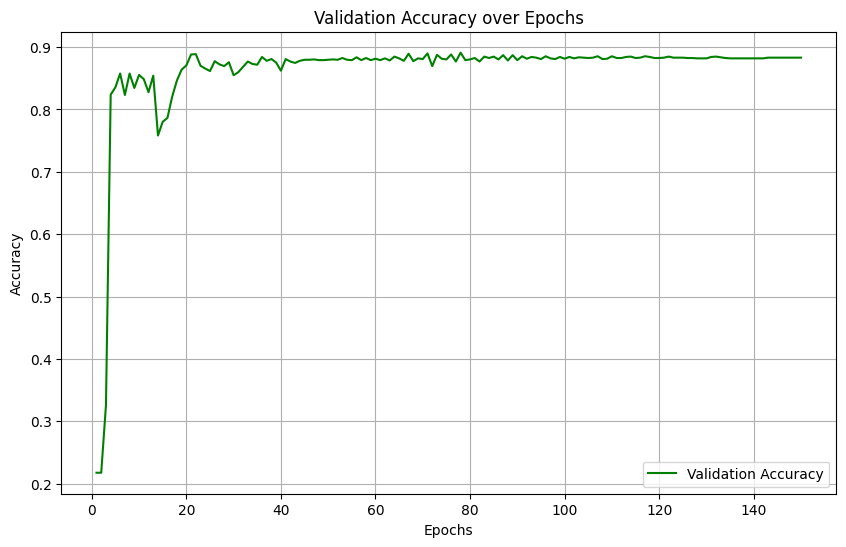

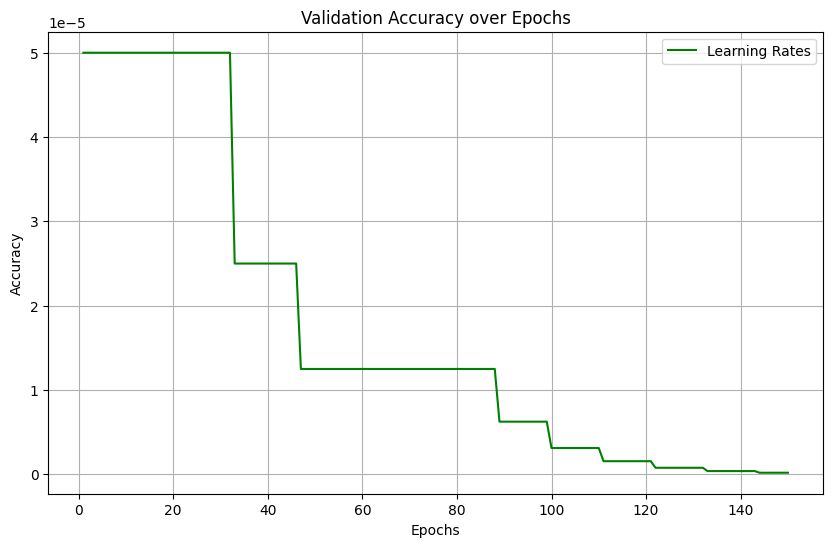

Model for bin 28 saved to 3DCholesterolModels-5A_exp5/model_bin_28.pth
1925 is length of subset grid
Training on bin 29
Bin 29, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7036, Validation Accuracy: 0.2175, Grad Norm: 0.0300, LR: 0.000050
Bin 29, Epoch 11/150, Train Loss: 0.6553, Validation Loss: 0.6119, Validation Accuracy: 0.8621, Grad Norm: 0.5622, LR: 0.000050
Bin 29, Epoch 21/150, Train Loss: 0.4731, Validation Loss: 0.4423, Validation Accuracy: 0.8831, Grad Norm: 1.7261, LR: 0.000050
Bin 29, Epoch 31/150, Train Loss: 0.4566, Validation Loss: 0.4683, Validation Accuracy: 0.8475, Grad Norm: 0.2498, LR: 0.000050
Bin 29, Epoch 41/150, Train Loss: 0.4522, Validation Loss: 0.4461, Validation Accuracy: 0.8672, Grad Norm: 0.2965, LR: 0.000050
Bin 29, Epoch 51/150, Train Loss: 0.4467, Validation Loss: 0.4477, Validation Accuracy: 0.8638, Grad Norm: 2.8353, LR: 0.000025
Bin 29, Epoch 61/150, Train Loss: 0.4471, Validation Loss: 0.4382, Validation Accuracy: 0.8740, Grad Norm: 1.6262

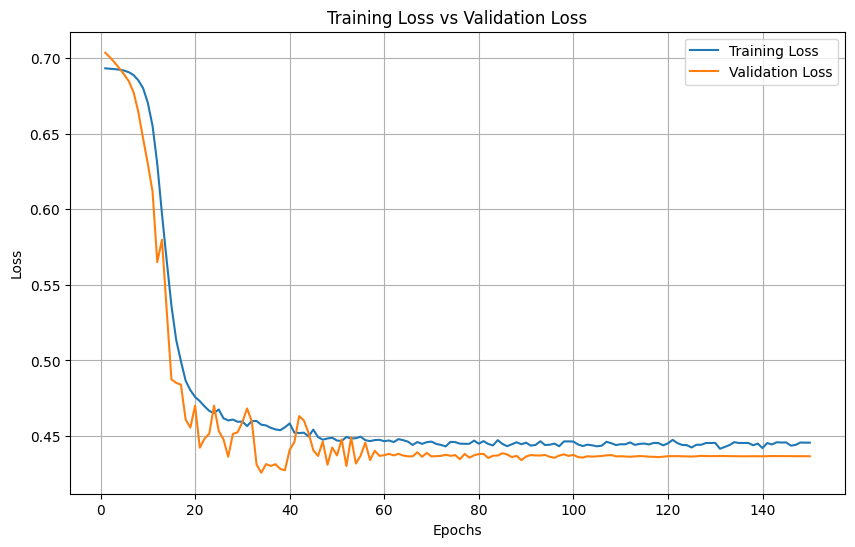

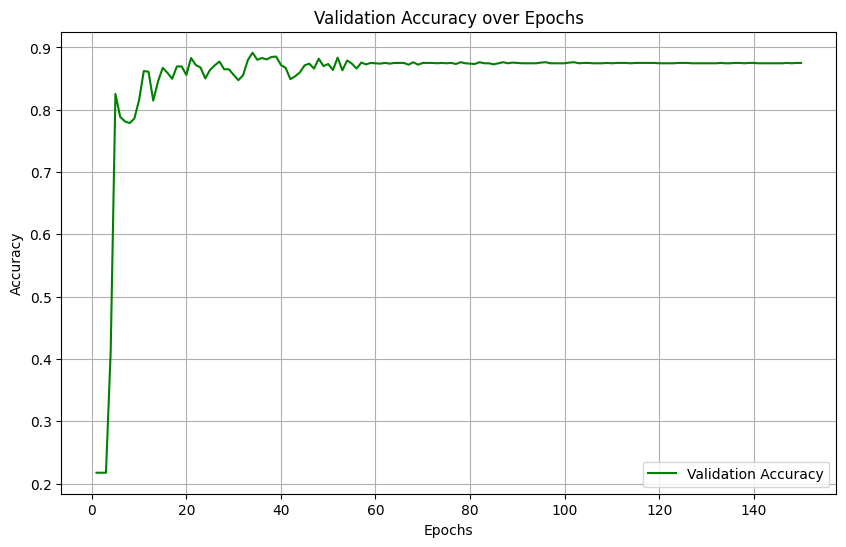

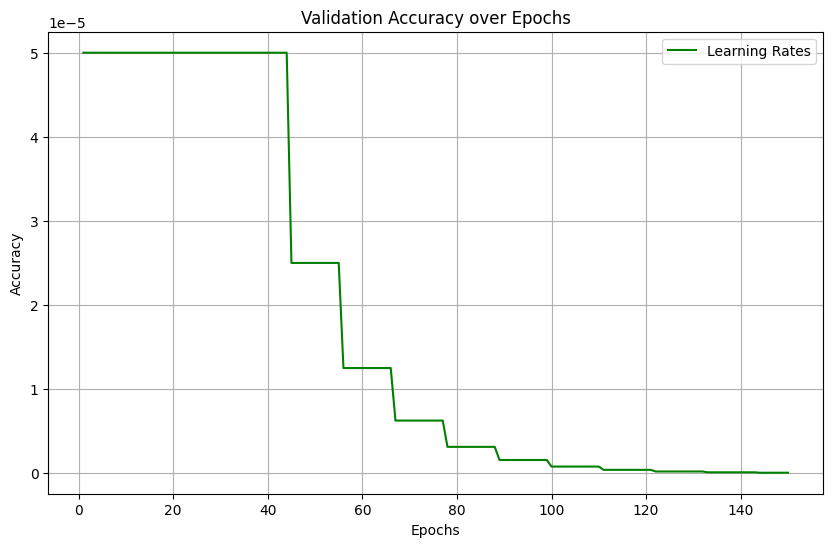

Model for bin 29 saved to 3DCholesterolModels-5A_exp5/model_bin_29.pth
1925 is length of subset grid
Training on bin 30
Bin 30, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6913, Validation Accuracy: 0.7825, Grad Norm: 0.0386, LR: 0.000050
Bin 30, Epoch 11/150, Train Loss: 0.6126, Validation Loss: 0.5603, Validation Accuracy: 0.8537, Grad Norm: 3.2300, LR: 0.000050
Bin 30, Epoch 21/150, Train Loss: 0.4762, Validation Loss: 0.4408, Validation Accuracy: 0.8797, Grad Norm: 1.2455, LR: 0.000050
Bin 30, Epoch 31/150, Train Loss: 0.4693, Validation Loss: 0.4556, Validation Accuracy: 0.8633, Grad Norm: 6.2014, LR: 0.000050
Bin 30, Epoch 41/150, Train Loss: 0.4557, Validation Loss: 0.4379, Validation Accuracy: 0.8746, Grad Norm: 2.9217, LR: 0.000025
Bin 30, Epoch 51/150, Train Loss: 0.4521, Validation Loss: 0.4393, Validation Accuracy: 0.8746, Grad Norm: 2.7067, LR: 0.000013
Bin 30, Epoch 61/150, Train Loss: 0.4534, Validation Loss: 0.4381, Validation Accuracy: 0.8763, Grad Norm: 1.7630

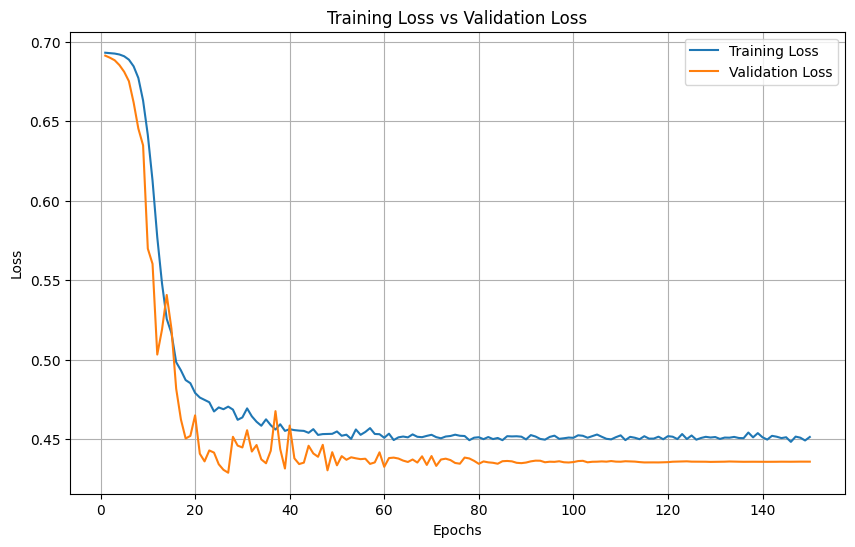

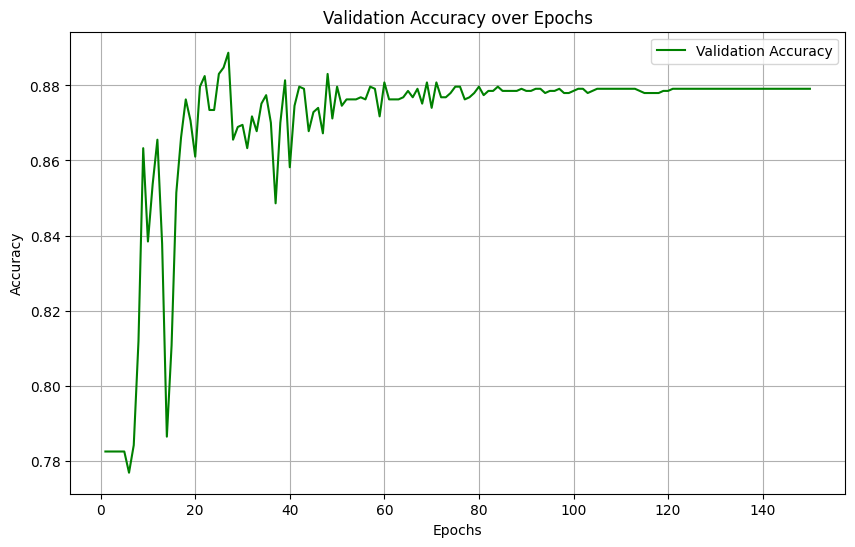

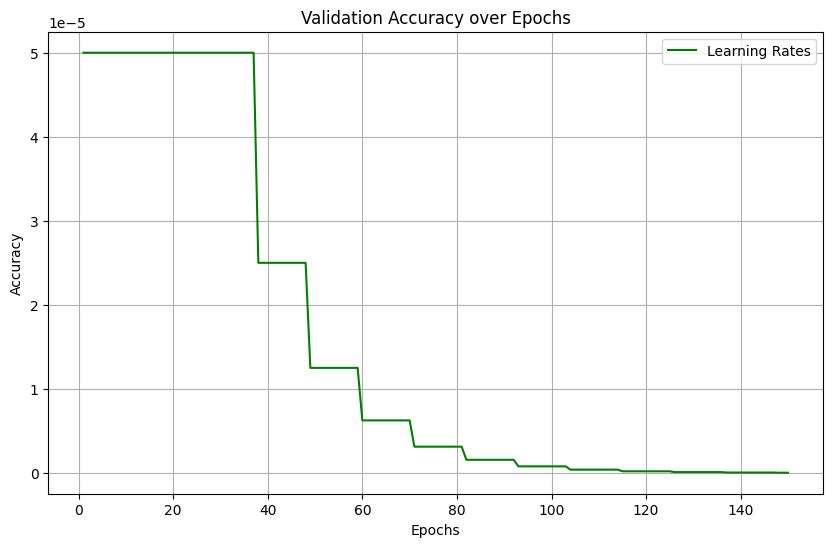

Model for bin 30 saved to 3DCholesterolModels-5A_exp5/model_bin_30.pth
1925 is length of subset grid
Training on bin 31
Bin 31, Epoch 1/150, Train Loss: 0.6937, Validation Loss: 0.6748, Validation Accuracy: 0.7825, Grad Norm: 0.0242, LR: 0.000050
Bin 31, Epoch 11/150, Train Loss: 0.6353, Validation Loss: 0.6304, Validation Accuracy: 0.7644, Grad Norm: 1.2999, LR: 0.000050
Bin 31, Epoch 21/150, Train Loss: 0.4798, Validation Loss: 0.4570, Validation Accuracy: 0.8712, Grad Norm: 1.9939, LR: 0.000050
Bin 31, Epoch 31/150, Train Loss: 0.4575, Validation Loss: 0.4371, Validation Accuracy: 0.8819, Grad Norm: 0.6101, LR: 0.000050
Bin 31, Epoch 41/150, Train Loss: 0.4541, Validation Loss: 0.4338, Validation Accuracy: 0.8819, Grad Norm: 6.3458, LR: 0.000050
Bin 31, Epoch 51/150, Train Loss: 0.4487, Validation Loss: 0.4212, Validation Accuracy: 0.8938, Grad Norm: 1.8933, LR: 0.000050
Bin 31, Epoch 61/150, Train Loss: 0.4434, Validation Loss: 0.4324, Validation Accuracy: 0.8876, Grad Norm: 3.1272

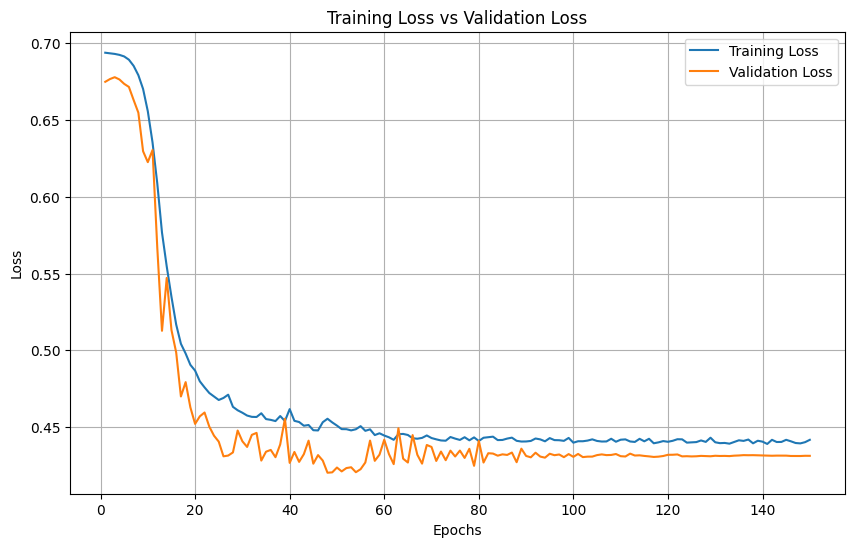

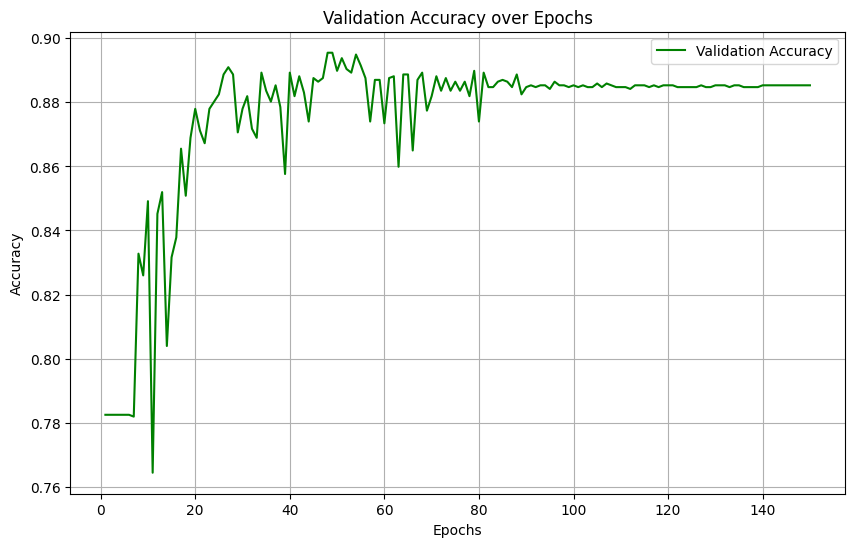

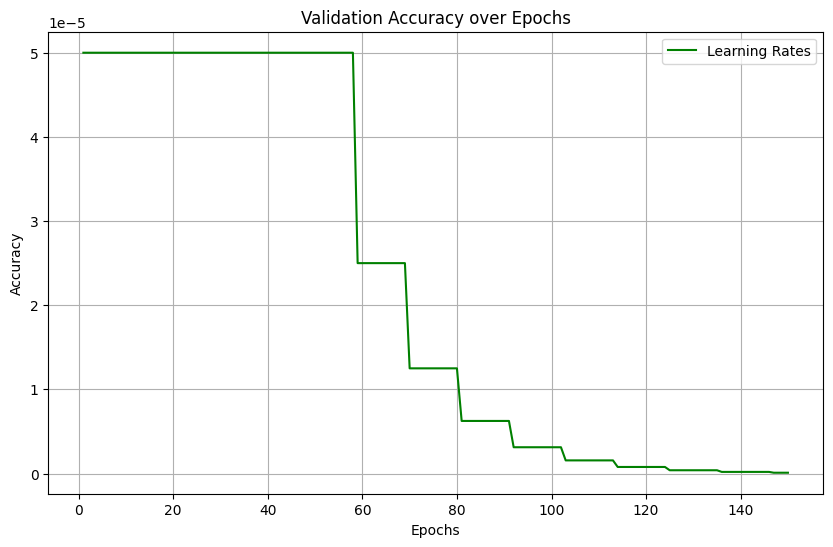

Model for bin 31 saved to 3DCholesterolModels-5A_exp5/model_bin_31.pth
1925 is length of subset grid
Training on bin 32
Bin 32, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.7022, Validation Accuracy: 0.2175, Grad Norm: 0.0214, LR: 0.000050
Bin 32, Epoch 11/150, Train Loss: 0.6244, Validation Loss: 0.5389, Validation Accuracy: 0.8497, Grad Norm: 1.2313, LR: 0.000050
Bin 32, Epoch 21/150, Train Loss: 0.4691, Validation Loss: 0.4494, Validation Accuracy: 0.8701, Grad Norm: 0.3822, LR: 0.000050
Bin 32, Epoch 31/150, Train Loss: 0.4558, Validation Loss: 0.4672, Validation Accuracy: 0.8401, Grad Norm: 3.9208, LR: 0.000050
Bin 32, Epoch 41/150, Train Loss: 0.4506, Validation Loss: 0.4479, Validation Accuracy: 0.8678, Grad Norm: 0.3561, LR: 0.000050
Bin 32, Epoch 51/150, Train Loss: 0.4454, Validation Loss: 0.4284, Validation Accuracy: 0.8847, Grad Norm: 1.3933, LR: 0.000050
Bin 32, Epoch 61/150, Train Loss: 0.4437, Validation Loss: 0.4372, Validation Accuracy: 0.8780, Grad Norm: 0.9901

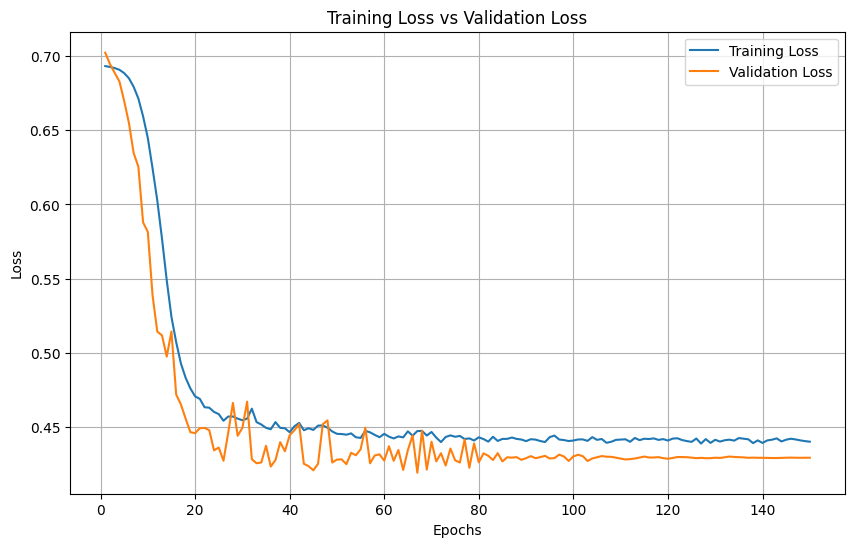

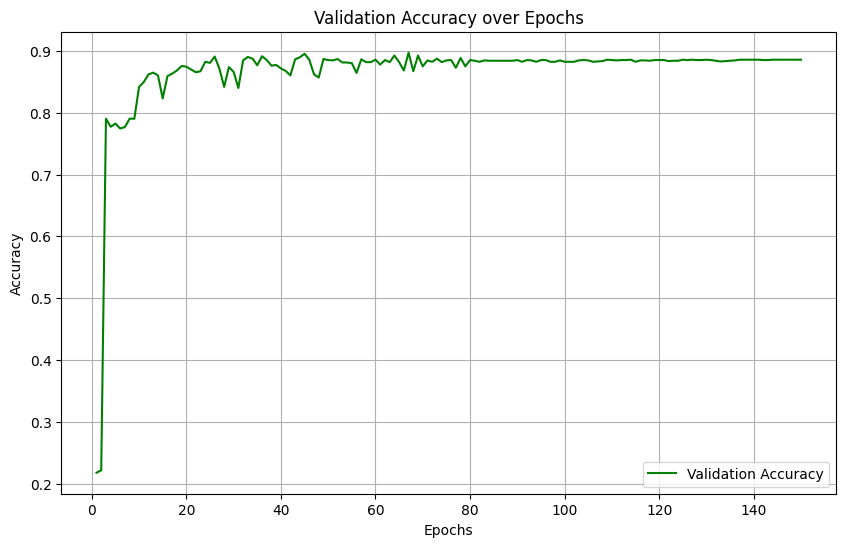

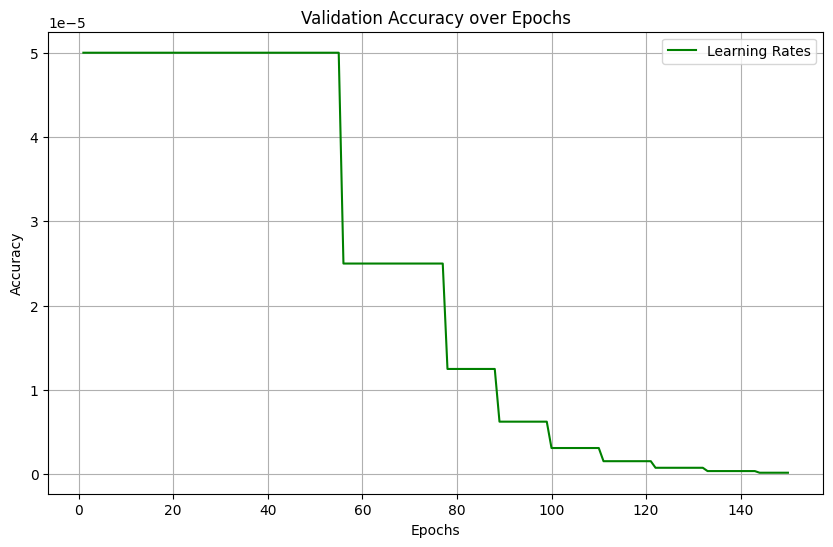

Model for bin 32 saved to 3DCholesterolModels-5A_exp5/model_bin_32.pth
1925 is length of subset grid
Training on bin 33
Bin 33, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6807, Validation Accuracy: 0.7825, Grad Norm: 0.0186, LR: 0.000050
Bin 33, Epoch 11/150, Train Loss: 0.5716, Validation Loss: 0.5218, Validation Accuracy: 0.8446, Grad Norm: 1.1491, LR: 0.000050
Bin 33, Epoch 21/150, Train Loss: 0.4721, Validation Loss: 0.4596, Validation Accuracy: 0.8689, Grad Norm: 5.3684, LR: 0.000050
Bin 33, Epoch 31/150, Train Loss: 0.4572, Validation Loss: 0.4322, Validation Accuracy: 0.8876, Grad Norm: 0.6338, LR: 0.000050
Bin 33, Epoch 41/150, Train Loss: 0.4517, Validation Loss: 0.4544, Validation Accuracy: 0.8593, Grad Norm: 1.9435, LR: 0.000050
Bin 33, Epoch 51/150, Train Loss: 0.4488, Validation Loss: 0.4485, Validation Accuracy: 0.8633, Grad Norm: 2.4490, LR: 0.000025
Bin 33, Epoch 61/150, Train Loss: 0.4484, Validation Loss: 0.4342, Validation Accuracy: 0.8842, Grad Norm: 1.0718

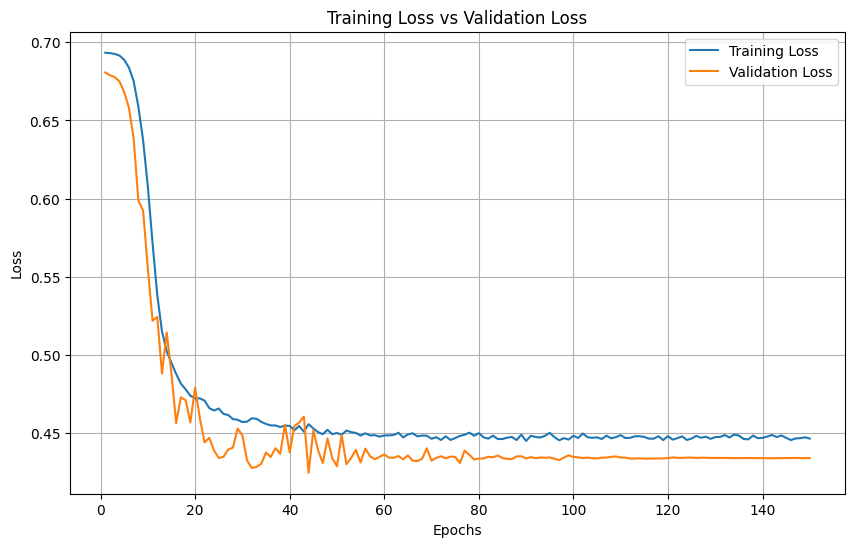

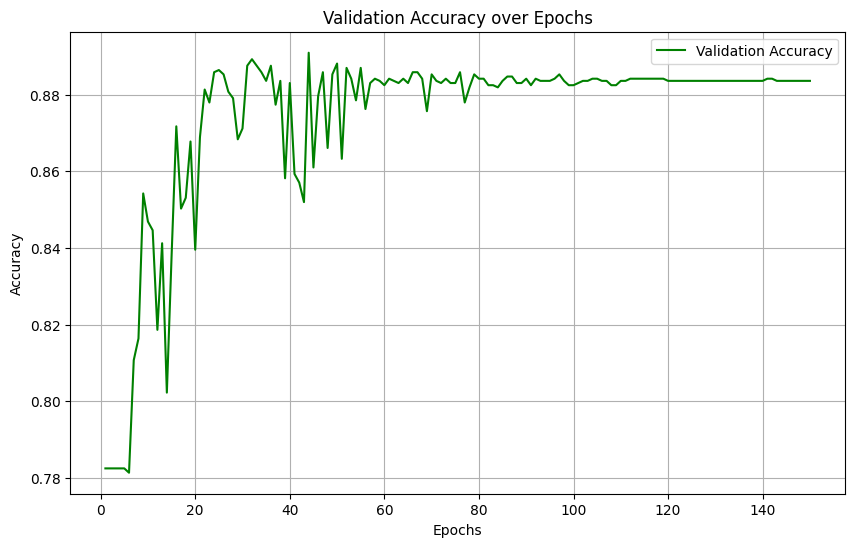

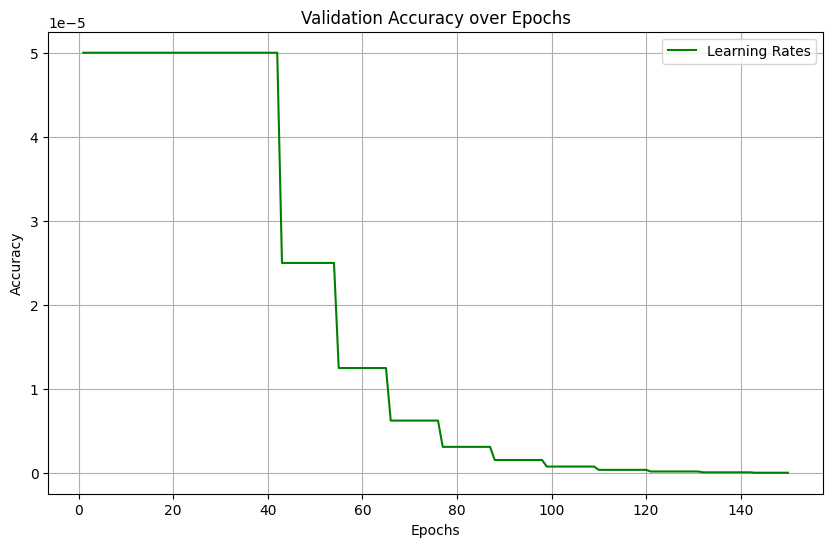

Model for bin 33 saved to 3DCholesterolModels-5A_exp5/model_bin_33.pth
1925 is length of subset grid
Training on bin 34
Bin 34, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6865, Validation Accuracy: 0.7825, Grad Norm: 0.0384, LR: 0.000050
Bin 34, Epoch 11/150, Train Loss: 0.5872, Validation Loss: 0.5179, Validation Accuracy: 0.8593, Grad Norm: 3.1828, LR: 0.000050
Bin 34, Epoch 21/150, Train Loss: 0.4636, Validation Loss: 0.4400, Validation Accuracy: 0.8802, Grad Norm: 0.8388, LR: 0.000050
Bin 34, Epoch 31/150, Train Loss: 0.4530, Validation Loss: 0.4486, Validation Accuracy: 0.8684, Grad Norm: 0.8157, LR: 0.000050
Bin 34, Epoch 41/150, Train Loss: 0.4462, Validation Loss: 0.4351, Validation Accuracy: 0.8836, Grad Norm: 1.8963, LR: 0.000050
Bin 34, Epoch 51/150, Train Loss: 0.4493, Validation Loss: 0.4655, Validation Accuracy: 0.8412, Grad Norm: 6.6247, LR: 0.000050
Bin 34, Epoch 61/150, Train Loss: 0.4412, Validation Loss: 0.4252, Validation Accuracy: 0.8898, Grad Norm: 2.3273

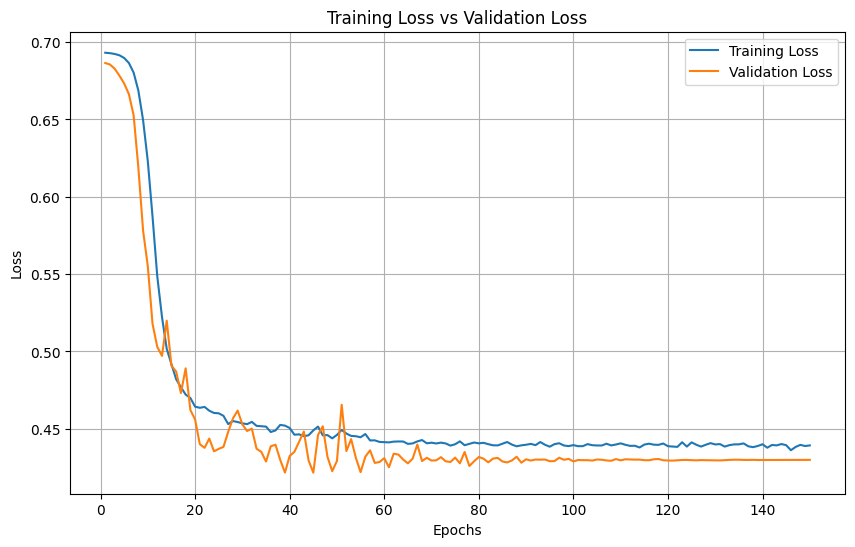

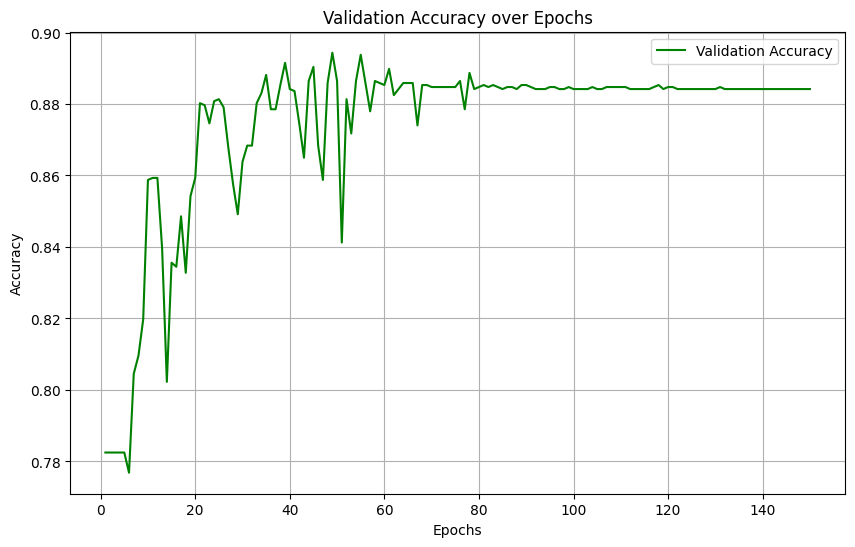

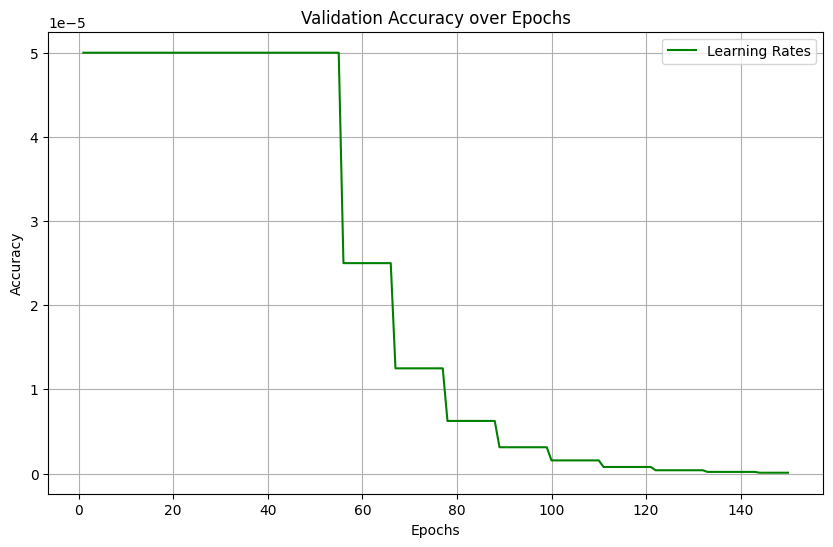

Model for bin 34 saved to 3DCholesterolModels-5A_exp5/model_bin_34.pth
1925 is length of subset grid
Training on bin 35
Bin 35, Epoch 1/150, Train Loss: 0.6935, Validation Loss: 0.6792, Validation Accuracy: 0.7825, Grad Norm: 0.0785, LR: 0.000050
Bin 35, Epoch 11/150, Train Loss: 0.6123, Validation Loss: 0.6021, Validation Accuracy: 0.7994, Grad Norm: 2.8045, LR: 0.000050
Bin 35, Epoch 21/150, Train Loss: 0.4778, Validation Loss: 0.4417, Validation Accuracy: 0.8825, Grad Norm: 4.7244, LR: 0.000050
Bin 35, Epoch 31/150, Train Loss: 0.4629, Validation Loss: 0.4276, Validation Accuracy: 0.8893, Grad Norm: 3.1453, LR: 0.000050
Bin 35, Epoch 41/150, Train Loss: 0.4554, Validation Loss: 0.4562, Validation Accuracy: 0.8576, Grad Norm: 6.1968, LR: 0.000050
Bin 35, Epoch 51/150, Train Loss: 0.4523, Validation Loss: 0.4436, Validation Accuracy: 0.8701, Grad Norm: 1.8862, LR: 0.000025
Bin 35, Epoch 61/150, Train Loss: 0.4510, Validation Loss: 0.4314, Validation Accuracy: 0.8870, Grad Norm: 5.1678

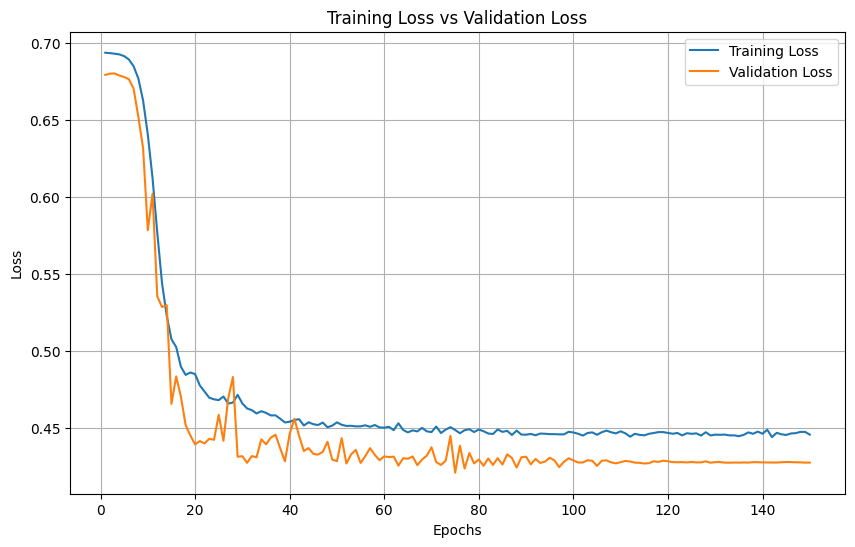

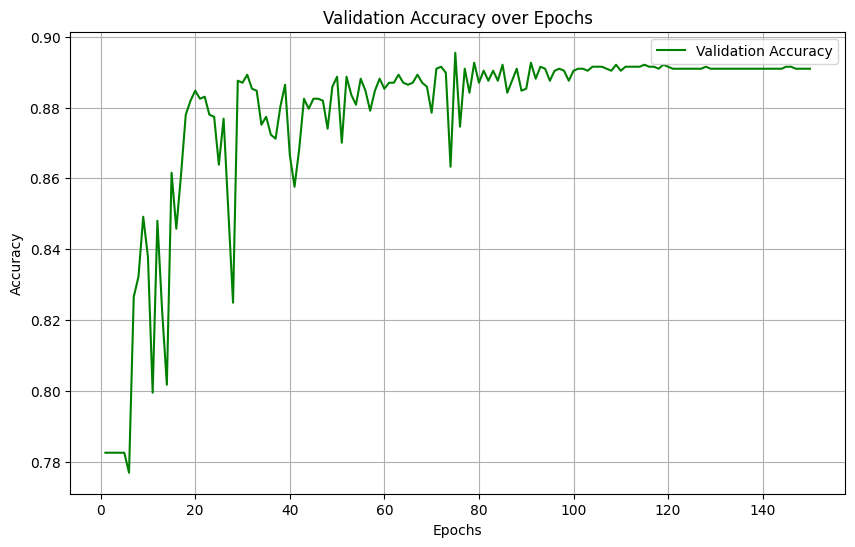

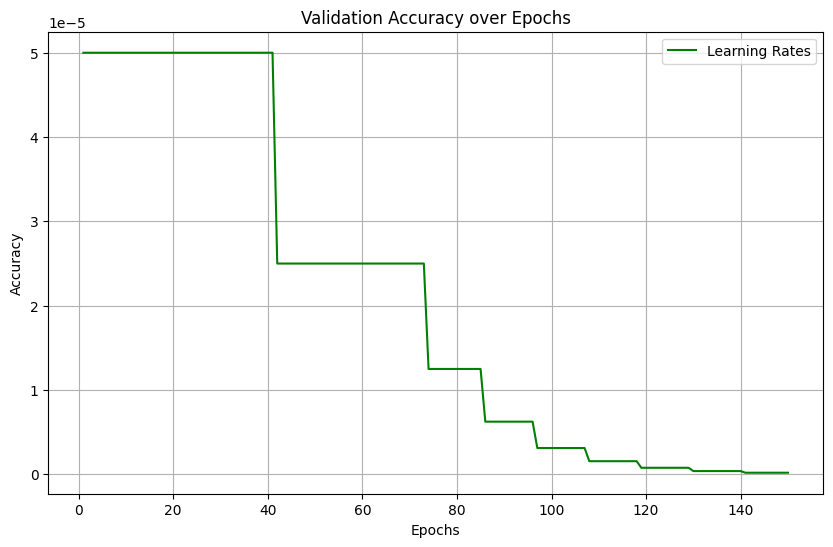

Model for bin 35 saved to 3DCholesterolModels-5A_exp5/model_bin_35.pth
1925 is length of subset grid
Training on bin 36
Bin 36, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7032, Validation Accuracy: 0.2175, Grad Norm: 0.1168, LR: 0.000050
Bin 36, Epoch 11/150, Train Loss: 0.6558, Validation Loss: 0.5983, Validation Accuracy: 0.8345, Grad Norm: 2.6695, LR: 0.000050
Bin 36, Epoch 21/150, Train Loss: 0.4739, Validation Loss: 0.4593, Validation Accuracy: 0.8661, Grad Norm: 5.8329, LR: 0.000050
Bin 36, Epoch 31/150, Train Loss: 0.4512, Validation Loss: 0.4295, Validation Accuracy: 0.8847, Grad Norm: 3.8987, LR: 0.000050
Bin 36, Epoch 41/150, Train Loss: 0.4485, Validation Loss: 0.4549, Validation Accuracy: 0.8565, Grad Norm: 4.2072, LR: 0.000050
Bin 36, Epoch 51/150, Train Loss: 0.4460, Validation Loss: 0.4382, Validation Accuracy: 0.8757, Grad Norm: 6.1016, LR: 0.000050
Bin 36, Epoch 61/150, Train Loss: 0.4391, Validation Loss: 0.4313, Validation Accuracy: 0.8797, Grad Norm: 2.3594

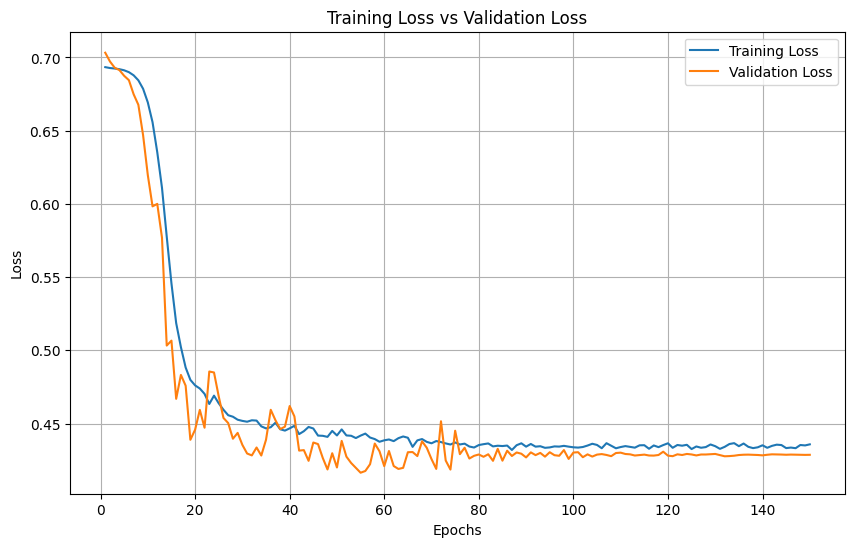

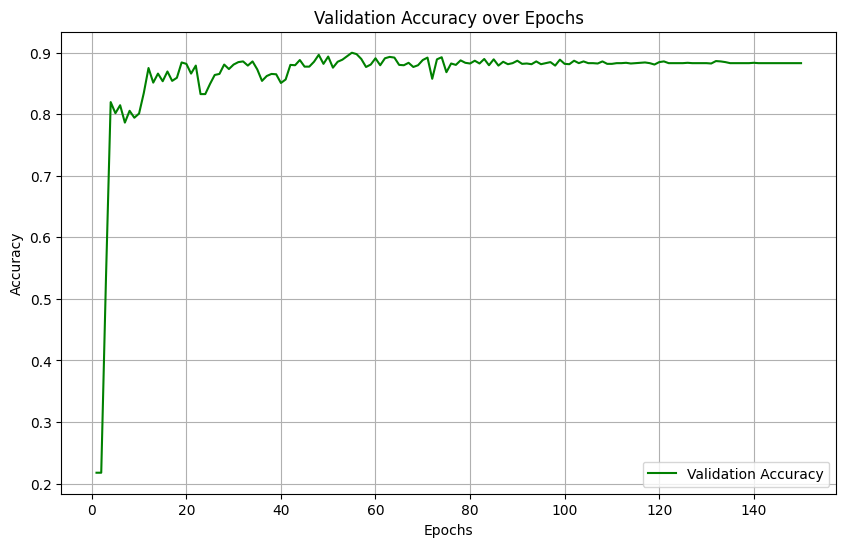

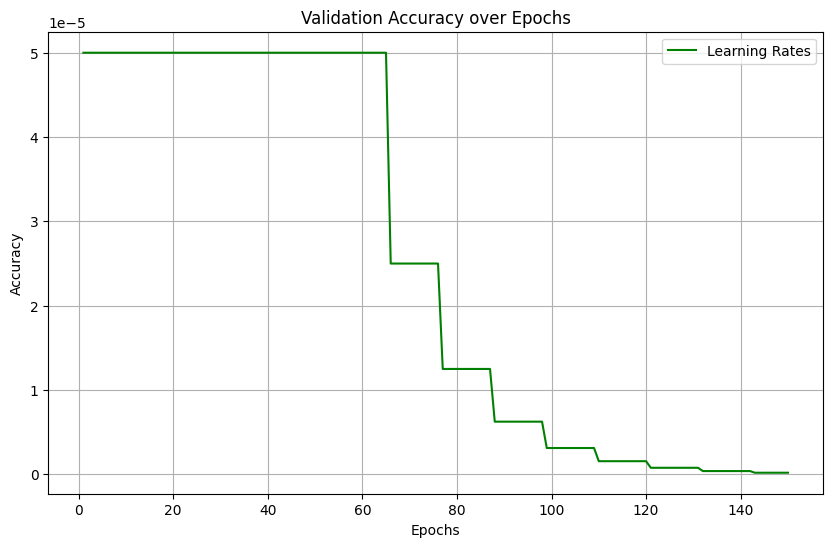

Model for bin 36 saved to 3DCholesterolModels-5A_exp5/model_bin_36.pth
1925 is length of subset grid
Training on bin 37
Bin 37, Epoch 1/150, Train Loss: 0.6934, Validation Loss: 0.6813, Validation Accuracy: 0.7825, Grad Norm: 0.1371, LR: 0.000050
Bin 37, Epoch 11/150, Train Loss: 0.5872, Validation Loss: 0.5159, Validation Accuracy: 0.8644, Grad Norm: 3.5026, LR: 0.000050
Bin 37, Epoch 21/150, Train Loss: 0.4680, Validation Loss: 0.4433, Validation Accuracy: 0.8808, Grad Norm: 5.3909, LR: 0.000050
Bin 37, Epoch 31/150, Train Loss: 0.4596, Validation Loss: 0.4500, Validation Accuracy: 0.8650, Grad Norm: 4.6079, LR: 0.000025
Bin 37, Epoch 41/150, Train Loss: 0.4546, Validation Loss: 0.4308, Validation Accuracy: 0.8842, Grad Norm: 1.2571, LR: 0.000025
Bin 37, Epoch 51/150, Train Loss: 0.4551, Validation Loss: 0.4336, Validation Accuracy: 0.8780, Grad Norm: 3.4002, LR: 0.000013
Bin 37, Epoch 61/150, Train Loss: 0.4525, Validation Loss: 0.4335, Validation Accuracy: 0.8785, Grad Norm: 2.2664

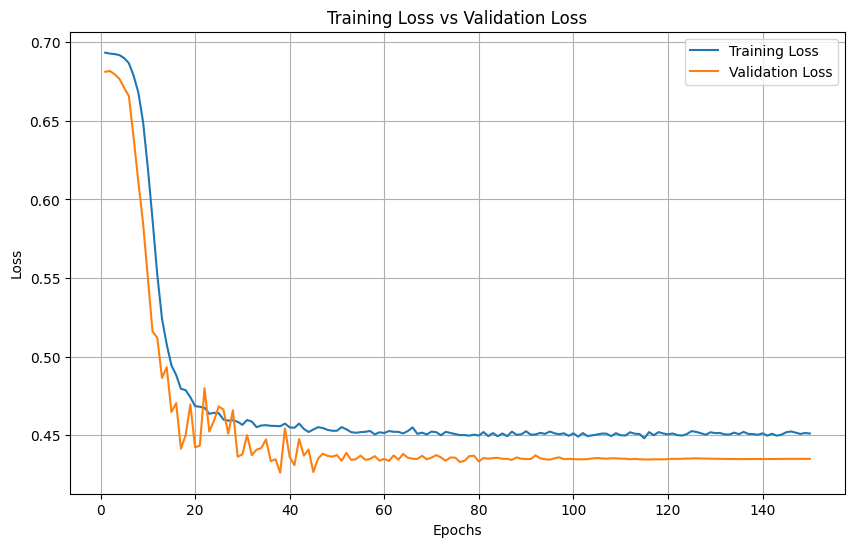

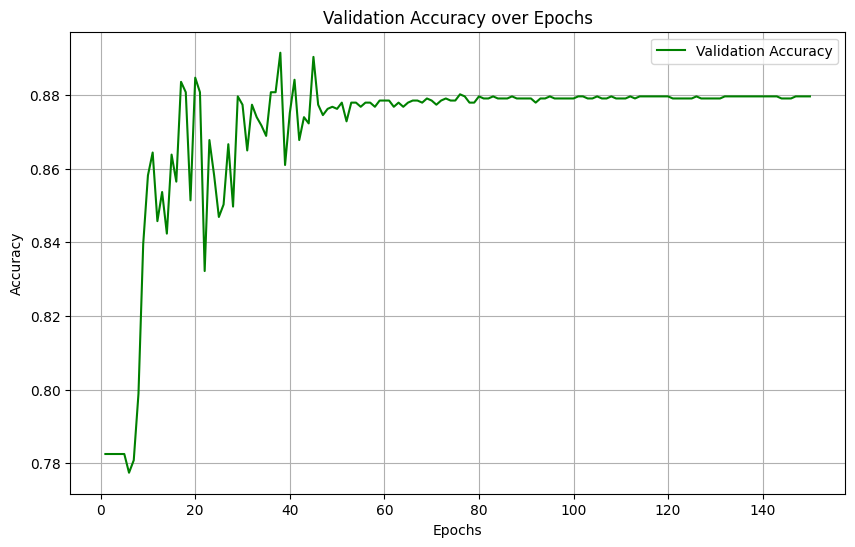

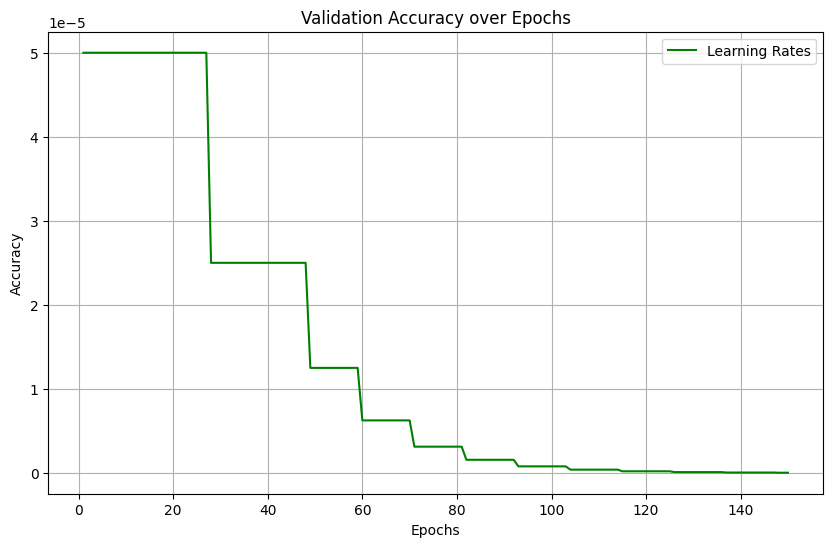

Model for bin 37 saved to 3DCholesterolModels-5A_exp5/model_bin_37.pth
1925 is length of subset grid
Training on bin 38
Bin 38, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6809, Validation Accuracy: 0.7825, Grad Norm: 0.0277, LR: 0.000050
Bin 38, Epoch 11/150, Train Loss: 0.6043, Validation Loss: 0.5556, Validation Accuracy: 0.8469, Grad Norm: 4.8744, LR: 0.000050
Bin 38, Epoch 21/150, Train Loss: 0.4690, Validation Loss: 0.4786, Validation Accuracy: 0.8452, Grad Norm: 2.9066, LR: 0.000050
Bin 38, Epoch 31/150, Train Loss: 0.4514, Validation Loss: 0.4341, Validation Accuracy: 0.8808, Grad Norm: 5.8296, LR: 0.000050
Bin 38, Epoch 41/150, Train Loss: 0.4445, Validation Loss: 0.4373, Validation Accuracy: 0.8757, Grad Norm: 2.1459, LR: 0.000050
Bin 38, Epoch 51/150, Train Loss: 0.4450, Validation Loss: 0.4369, Validation Accuracy: 0.8774, Grad Norm: 1.3120, LR: 0.000050
Bin 38, Epoch 61/150, Train Loss: 0.4459, Validation Loss: 0.4214, Validation Accuracy: 0.8904, Grad Norm: 6.5466

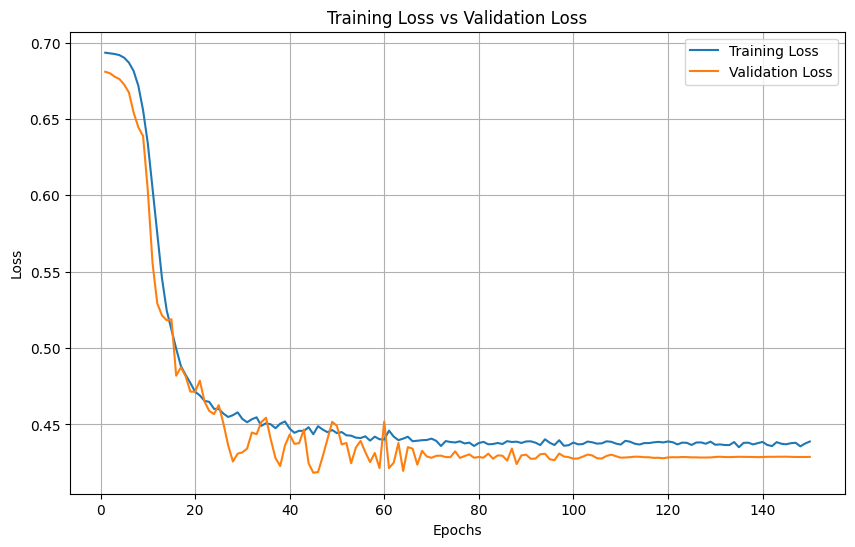

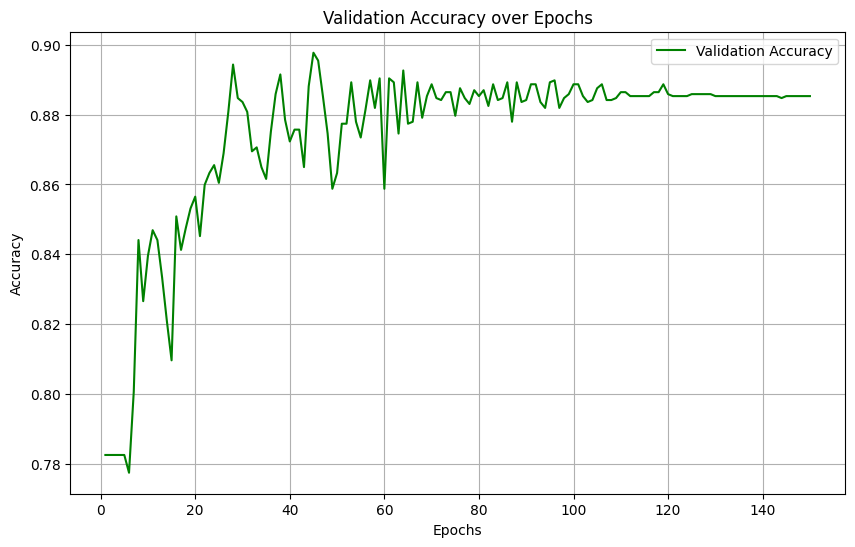

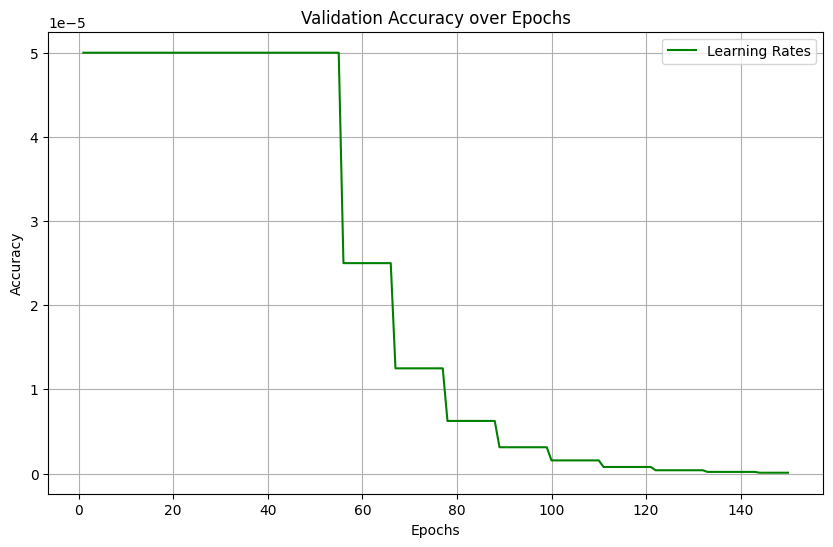

Model for bin 38 saved to 3DCholesterolModels-5A_exp5/model_bin_38.pth
1925 is length of subset grid
Training on bin 39
Bin 39, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6931, Validation Accuracy: 0.4768, Grad Norm: 0.0373, LR: 0.000050
Bin 39, Epoch 11/150, Train Loss: 0.6357, Validation Loss: 0.5758, Validation Accuracy: 0.8497, Grad Norm: 2.2076, LR: 0.000050
Bin 39, Epoch 21/150, Train Loss: 0.4865, Validation Loss: 0.5095, Validation Accuracy: 0.8073, Grad Norm: 1.4113, LR: 0.000050
Bin 39, Epoch 31/150, Train Loss: 0.4684, Validation Loss: 0.4566, Validation Accuracy: 0.8616, Grad Norm: 5.3448, LR: 0.000050
Bin 39, Epoch 41/150, Train Loss: 0.4537, Validation Loss: 0.4261, Validation Accuracy: 0.8910, Grad Norm: 0.3114, LR: 0.000050
Bin 39, Epoch 51/150, Train Loss: 0.4510, Validation Loss: 0.4364, Validation Accuracy: 0.8774, Grad Norm: 1.8389, LR: 0.000050
Bin 39, Epoch 61/150, Train Loss: 0.4462, Validation Loss: 0.4329, Validation Accuracy: 0.8825, Grad Norm: 2.8792

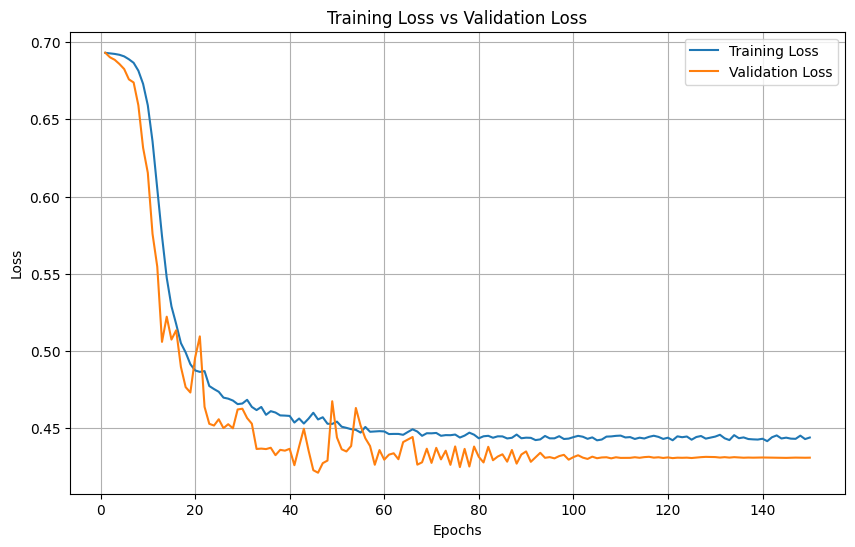

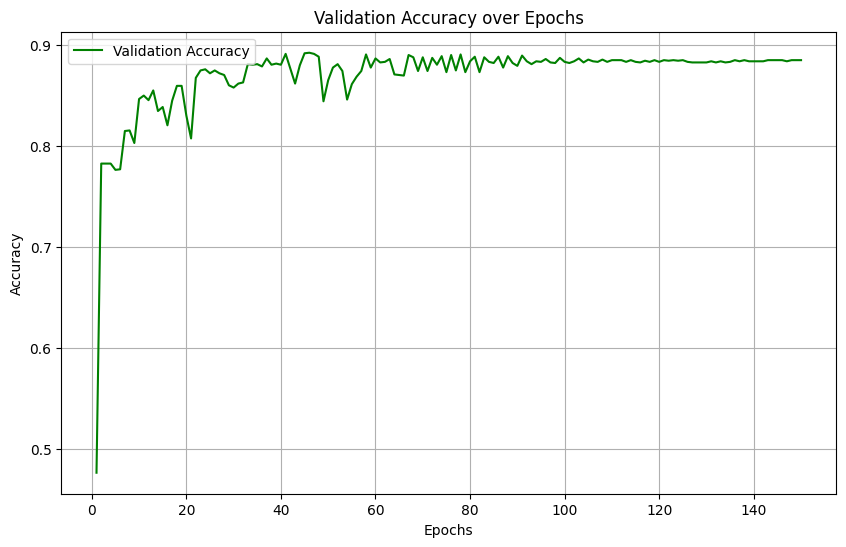

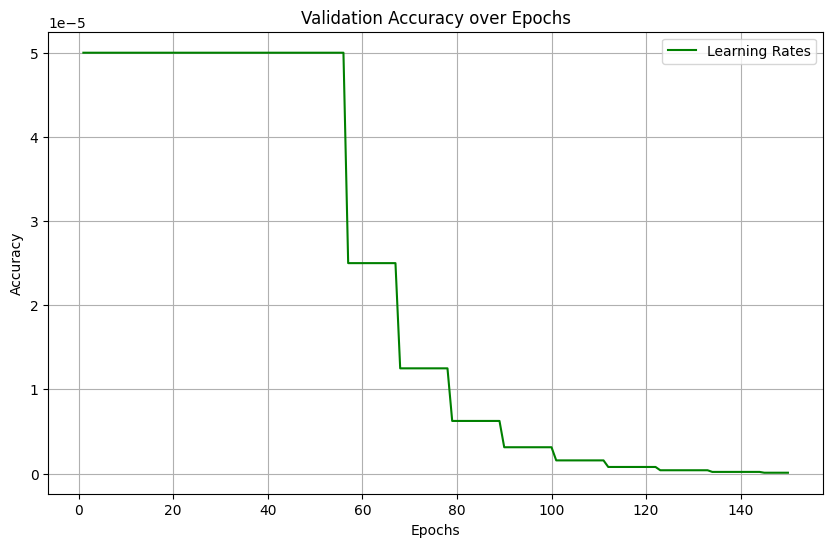

Model for bin 39 saved to 3DCholesterolModels-5A_exp5/model_bin_39.pth
1925 is length of subset grid
Training on bin 40
Bin 40, Epoch 1/150, Train Loss: 0.6932, Validation Loss: 0.6992, Validation Accuracy: 0.2175, Grad Norm: 0.1090, LR: 0.000050
Bin 40, Epoch 11/150, Train Loss: 0.6246, Validation Loss: 0.5858, Validation Accuracy: 0.8395, Grad Norm: 5.8894, LR: 0.000050
Bin 40, Epoch 21/150, Train Loss: 0.4953, Validation Loss: 0.4624, Validation Accuracy: 0.8638, Grad Norm: 3.5678, LR: 0.000050
Bin 40, Epoch 31/150, Train Loss: 0.4705, Validation Loss: 0.4556, Validation Accuracy: 0.8610, Grad Norm: 1.5144, LR: 0.000050
Bin 40, Epoch 41/150, Train Loss: 0.4634, Validation Loss: 0.4418, Validation Accuracy: 0.8768, Grad Norm: 6.0697, LR: 0.000025
Bin 40, Epoch 51/150, Train Loss: 0.4609, Validation Loss: 0.4345, Validation Accuracy: 0.8842, Grad Norm: 1.1408, LR: 0.000025
Bin 40, Epoch 61/150, Train Loss: 0.4566, Validation Loss: 0.4351, Validation Accuracy: 0.8819, Grad Norm: 0.3692

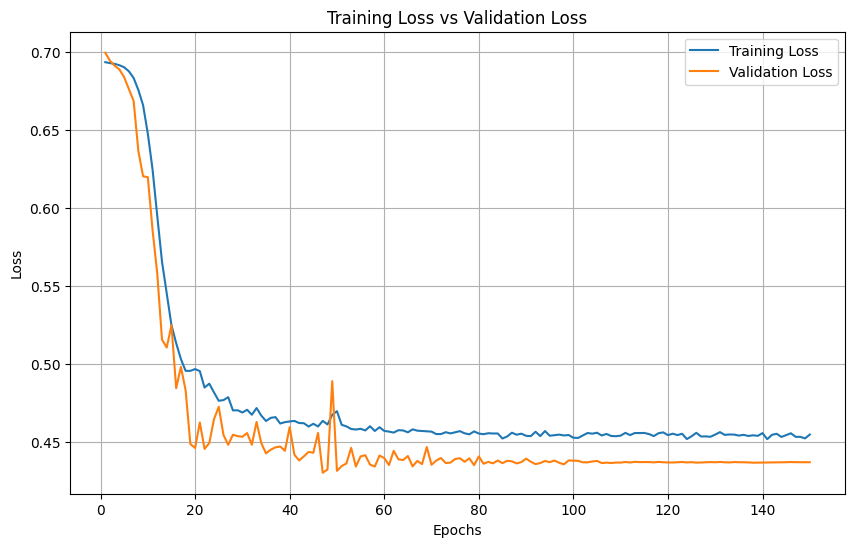

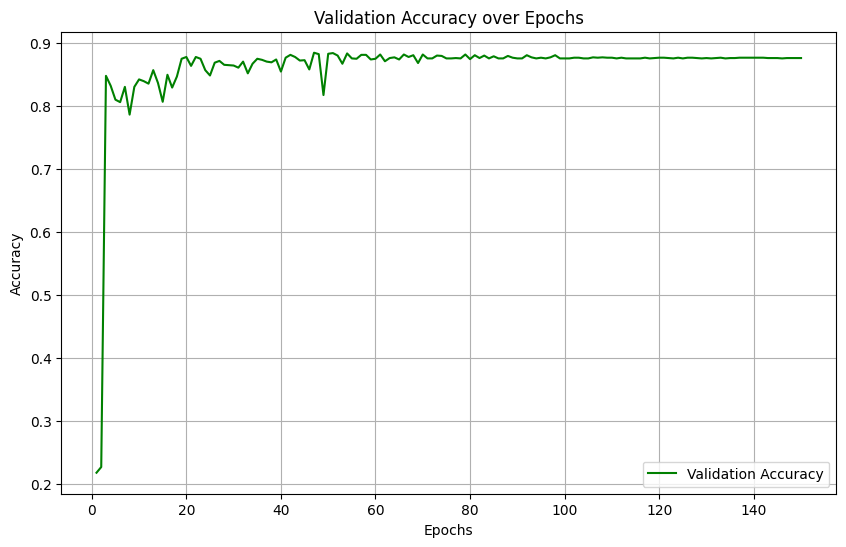

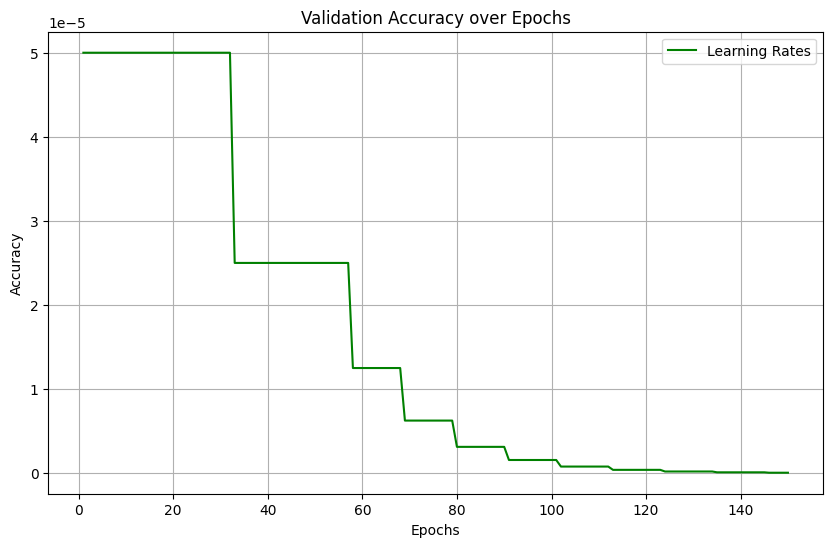

Model for bin 40 saved to 3DCholesterolModels-5A_exp5/model_bin_40.pth
1925 is length of subset grid
Training on bin 41
Bin 41, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.6770, Validation Accuracy: 0.7825, Grad Norm: 0.0492, LR: 0.000050
Bin 41, Epoch 11/150, Train Loss: 0.5377, Validation Loss: 0.5258, Validation Accuracy: 0.8260, Grad Norm: 0.9240, LR: 0.000050
Bin 41, Epoch 21/150, Train Loss: 0.4630, Validation Loss: 0.4507, Validation Accuracy: 0.8701, Grad Norm: 2.1274, LR: 0.000050
Bin 41, Epoch 31/150, Train Loss: 0.4523, Validation Loss: 0.4263, Validation Accuracy: 0.8887, Grad Norm: 1.2328, LR: 0.000050
Bin 41, Epoch 41/150, Train Loss: 0.4434, Validation Loss: 0.4375, Validation Accuracy: 0.8751, Grad Norm: 2.7897, LR: 0.000050
Bin 41, Epoch 51/150, Train Loss: 0.4461, Validation Loss: 0.4381, Validation Accuracy: 0.8751, Grad Norm: 2.2254, LR: 0.000025
Bin 41, Epoch 61/150, Train Loss: 0.4439, Validation Loss: 0.4292, Validation Accuracy: 0.8904, Grad Norm: 2.2691

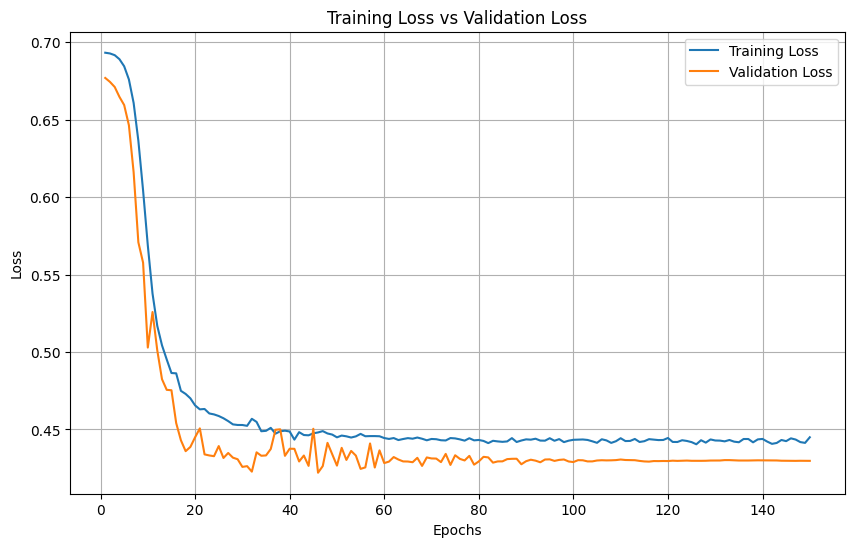

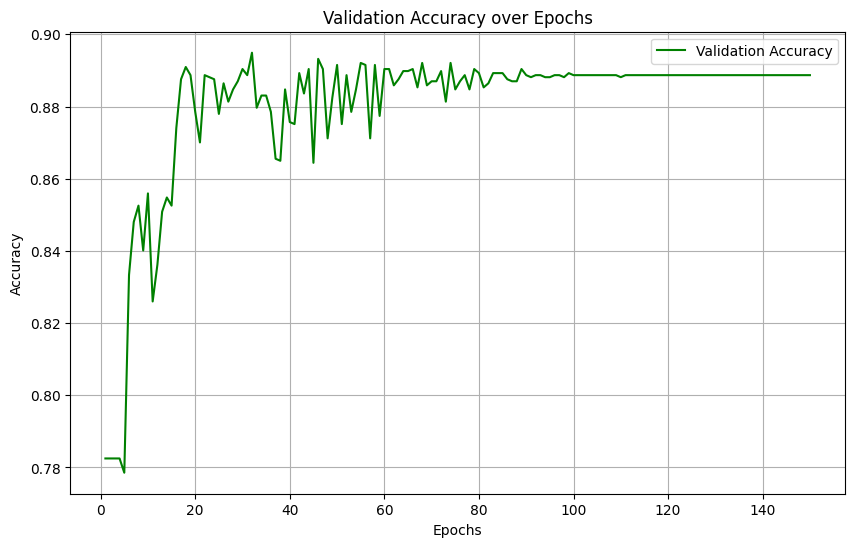

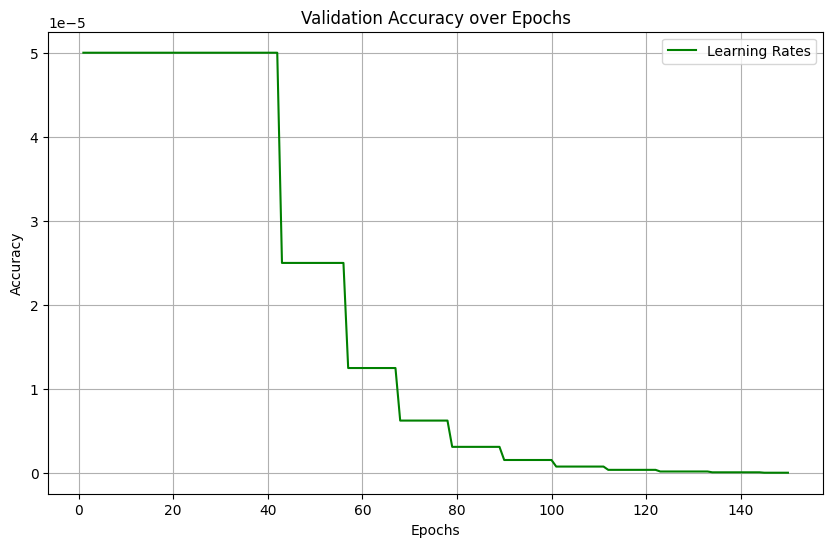

Model for bin 41 saved to 3DCholesterolModels-5A_exp5/model_bin_41.pth
1925 is length of subset grid
Training on bin 42
Bin 42, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6943, Validation Accuracy: 0.2175, Grad Norm: 0.1152, LR: 0.000050
Bin 42, Epoch 11/150, Train Loss: 0.6035, Validation Loss: 0.5429, Validation Accuracy: 0.8605, Grad Norm: 1.4414, LR: 0.000050
Bin 42, Epoch 21/150, Train Loss: 0.4698, Validation Loss: 0.4443, Validation Accuracy: 0.8831, Grad Norm: 4.4041, LR: 0.000050
Bin 42, Epoch 31/150, Train Loss: 0.4548, Validation Loss: 0.4447, Validation Accuracy: 0.8740, Grad Norm: 3.2660, LR: 0.000050
Bin 42, Epoch 41/150, Train Loss: 0.4488, Validation Loss: 0.4360, Validation Accuracy: 0.8785, Grad Norm: 0.5885, LR: 0.000025
Bin 42, Epoch 51/150, Train Loss: 0.4470, Validation Loss: 0.4255, Validation Accuracy: 0.8887, Grad Norm: 1.2790, LR: 0.000025
Bin 42, Epoch 61/150, Train Loss: 0.4471, Validation Loss: 0.4312, Validation Accuracy: 0.8825, Grad Norm: 1.4679

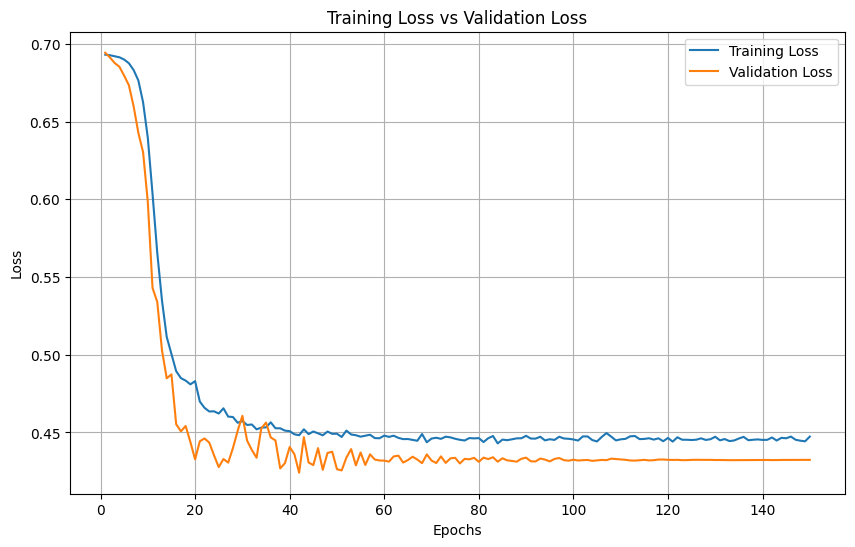

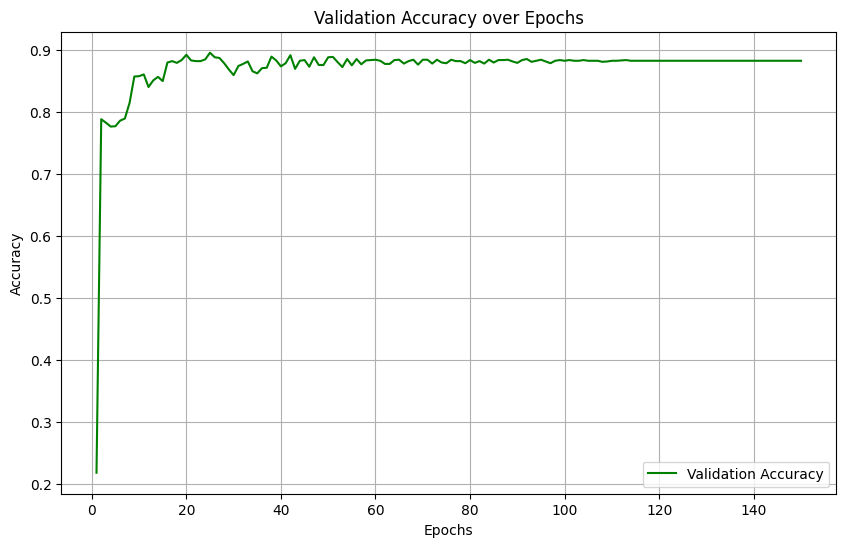

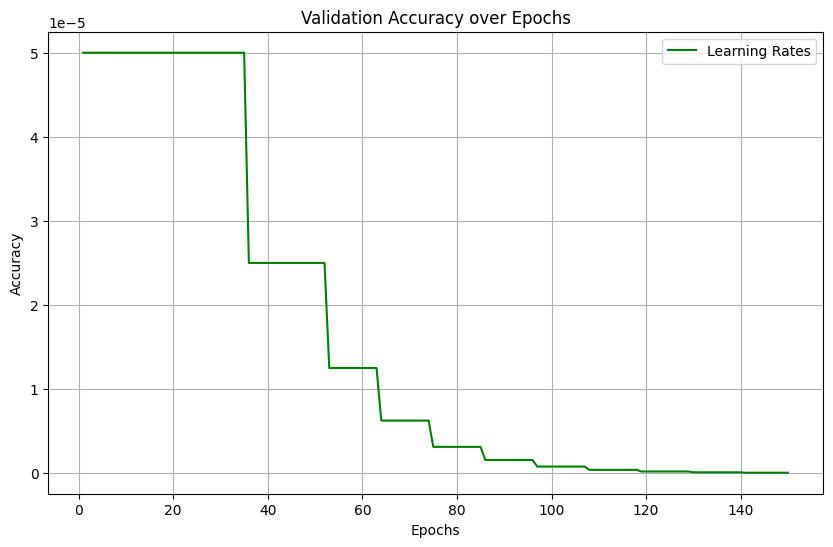

Model for bin 42 saved to 3DCholesterolModels-5A_exp5/model_bin_42.pth
1925 is length of subset grid
Training on bin 43
Bin 43, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6980, Validation Accuracy: 0.2175, Grad Norm: 0.0478, LR: 0.000050
Bin 43, Epoch 11/150, Train Loss: 0.6082, Validation Loss: 0.5474, Validation Accuracy: 0.8621, Grad Norm: 2.5883, LR: 0.000050
Bin 43, Epoch 21/150, Train Loss: 0.4661, Validation Loss: 0.4500, Validation Accuracy: 0.8701, Grad Norm: 1.9834, LR: 0.000050
Bin 43, Epoch 31/150, Train Loss: 0.4542, Validation Loss: 0.4606, Validation Accuracy: 0.8525, Grad Norm: 0.6233, LR: 0.000050
Bin 43, Epoch 41/150, Train Loss: 0.4459, Validation Loss: 0.4272, Validation Accuracy: 0.8893, Grad Norm: 0.5768, LR: 0.000025
Bin 43, Epoch 51/150, Train Loss: 0.4426, Validation Loss: 0.4312, Validation Accuracy: 0.8859, Grad Norm: 6.4172, LR: 0.000025
Bin 43, Epoch 61/150, Train Loss: 0.4399, Validation Loss: 0.4326, Validation Accuracy: 0.8836, Grad Norm: 3.0930

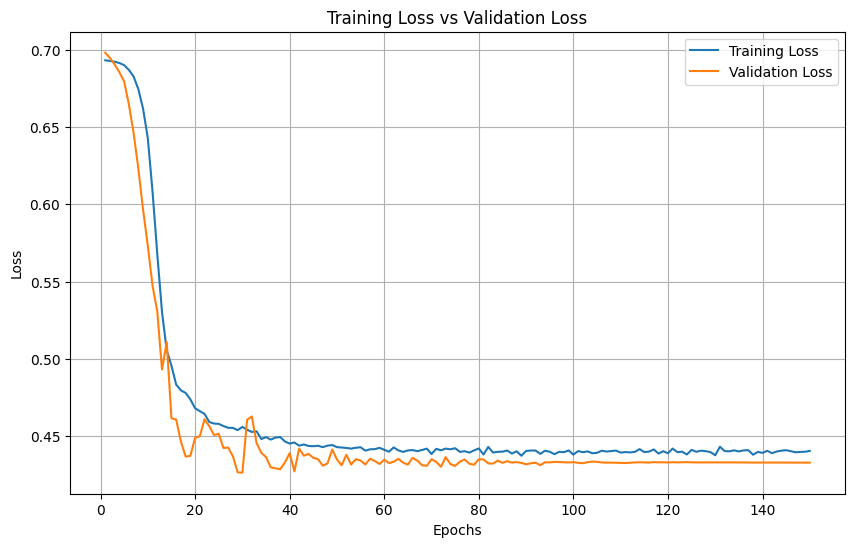

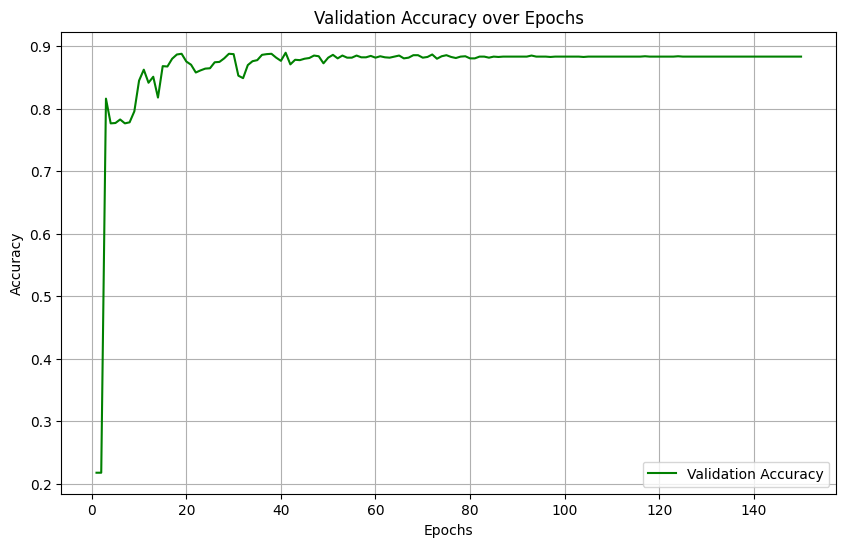

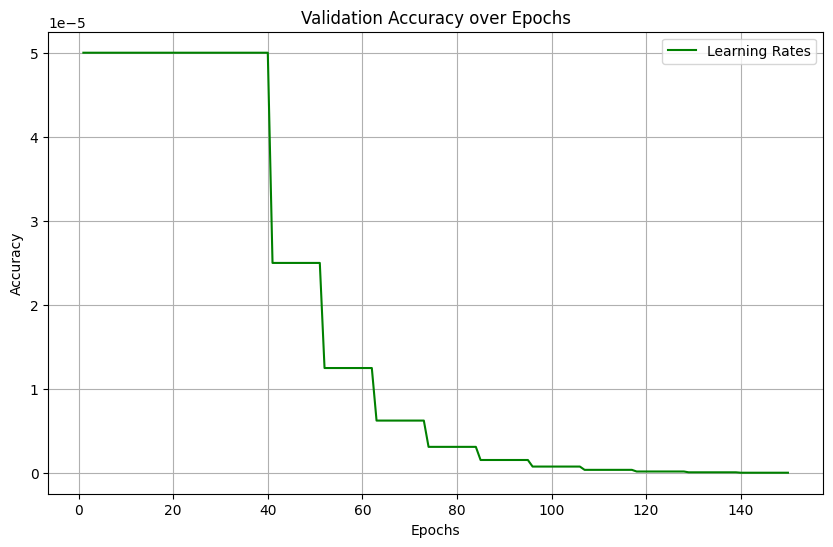

Model for bin 43 saved to 3DCholesterolModels-5A_exp5/model_bin_43.pth
1925 is length of subset grid
Training on bin 44
Bin 44, Epoch 1/150, Train Loss: 0.6936, Validation Loss: 0.7082, Validation Accuracy: 0.2175, Grad Norm: 0.0831, LR: 0.000050
Bin 44, Epoch 11/150, Train Loss: 0.6470, Validation Loss: 0.5678, Validation Accuracy: 0.8085, Grad Norm: 1.2865, LR: 0.000050
Bin 44, Epoch 21/150, Train Loss: 0.4813, Validation Loss: 0.4680, Validation Accuracy: 0.8514, Grad Norm: 3.1317, LR: 0.000050
Bin 44, Epoch 31/150, Train Loss: 0.4693, Validation Loss: 0.4523, Validation Accuracy: 0.8644, Grad Norm: 0.7011, LR: 0.000050
Bin 44, Epoch 41/150, Train Loss: 0.4558, Validation Loss: 0.4670, Validation Accuracy: 0.8463, Grad Norm: 6.1841, LR: 0.000050
Bin 44, Epoch 51/150, Train Loss: 0.4565, Validation Loss: 0.4268, Validation Accuracy: 0.8864, Grad Norm: 1.8803, LR: 0.000050
Bin 44, Epoch 61/150, Train Loss: 0.4489, Validation Loss: 0.4398, Validation Accuracy: 0.8757, Grad Norm: 1.5900

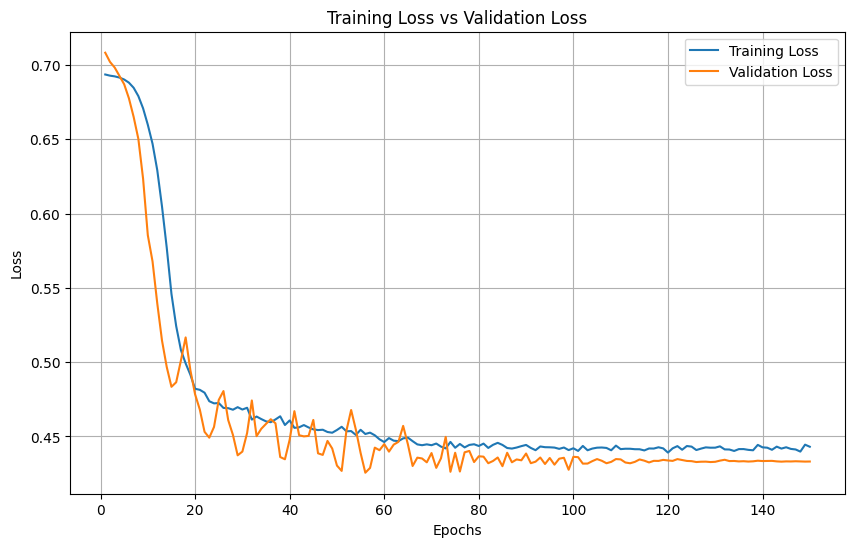

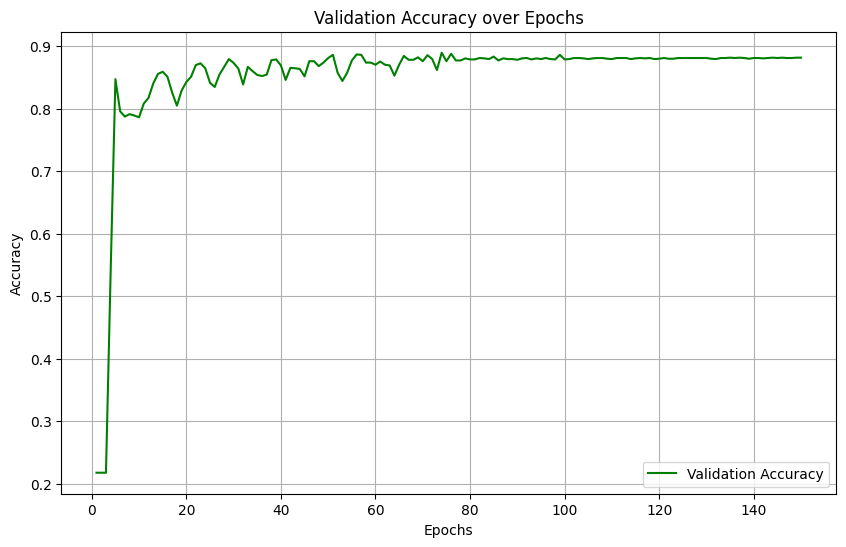

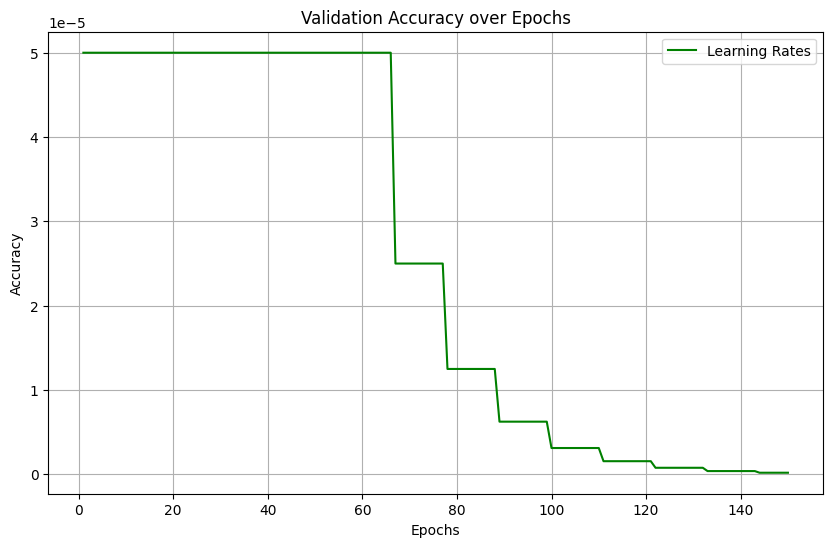

Model for bin 44 saved to 3DCholesterolModels-5A_exp5/model_bin_44.pth
1925 is length of subset grid
Training on bin 45
Bin 45, Epoch 1/150, Train Loss: 0.6930, Validation Loss: 0.6958, Validation Accuracy: 0.2175, Grad Norm: 0.0359, LR: 0.000050
Bin 45, Epoch 11/150, Train Loss: 0.5862, Validation Loss: 0.5197, Validation Accuracy: 0.8706, Grad Norm: 0.8415, LR: 0.000050
Bin 45, Epoch 21/150, Train Loss: 0.4618, Validation Loss: 0.4329, Validation Accuracy: 0.8904, Grad Norm: 2.3374, LR: 0.000050
Bin 45, Epoch 31/150, Train Loss: 0.4522, Validation Loss: 0.4366, Validation Accuracy: 0.8751, Grad Norm: 1.1469, LR: 0.000050
Bin 45, Epoch 41/150, Train Loss: 0.4467, Validation Loss: 0.4400, Validation Accuracy: 0.8723, Grad Norm: 3.0618, LR: 0.000025
Bin 45, Epoch 51/150, Train Loss: 0.4472, Validation Loss: 0.4312, Validation Accuracy: 0.8808, Grad Norm: 2.9334, LR: 0.000013
Bin 45, Epoch 61/150, Train Loss: 0.4452, Validation Loss: 0.4333, Validation Accuracy: 0.8780, Grad Norm: 2.2730

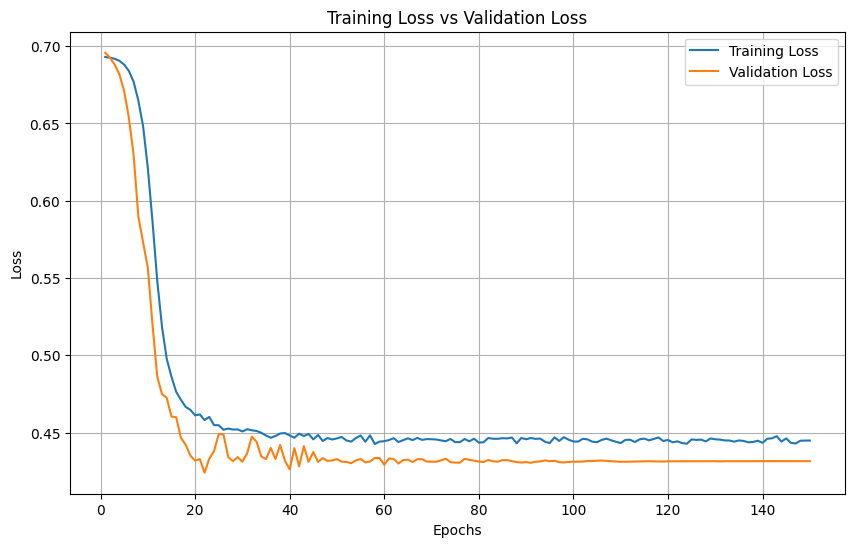

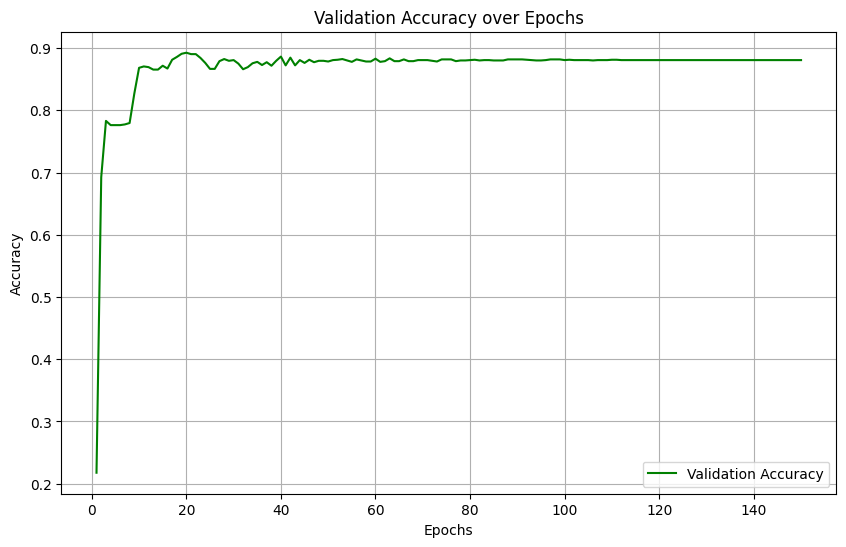

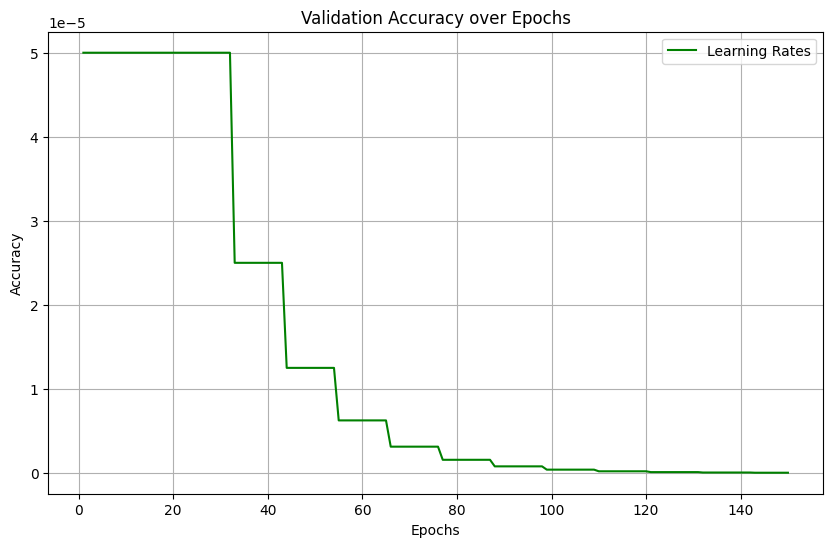

Model for bin 45 saved to 3DCholesterolModels-5A_exp5/model_bin_45.pth
1925 is length of subset grid
Training on bin 46
Bin 46, Epoch 1/150, Train Loss: 0.6936, Validation Loss: 0.6765, Validation Accuracy: 0.7825, Grad Norm: 0.0286, LR: 0.000050
Bin 46, Epoch 11/150, Train Loss: 0.6254, Validation Loss: 0.5975, Validation Accuracy: 0.8429, Grad Norm: 3.7339, LR: 0.000050
Bin 46, Epoch 21/150, Train Loss: 0.4703, Validation Loss: 0.4538, Validation Accuracy: 0.8638, Grad Norm: 0.6167, LR: 0.000050
Bin 46, Epoch 31/150, Train Loss: 0.4558, Validation Loss: 0.4421, Validation Accuracy: 0.8718, Grad Norm: 1.6224, LR: 0.000050
Bin 46, Epoch 41/150, Train Loss: 0.4558, Validation Loss: 0.4574, Validation Accuracy: 0.8497, Grad Norm: 4.5676, LR: 0.000050
Bin 46, Epoch 51/150, Train Loss: 0.4475, Validation Loss: 0.4296, Validation Accuracy: 0.8831, Grad Norm: 4.5536, LR: 0.000050
Bin 46, Epoch 61/150, Train Loss: 0.4475, Validation Loss: 0.4273, Validation Accuracy: 0.8842, Grad Norm: 1.9523

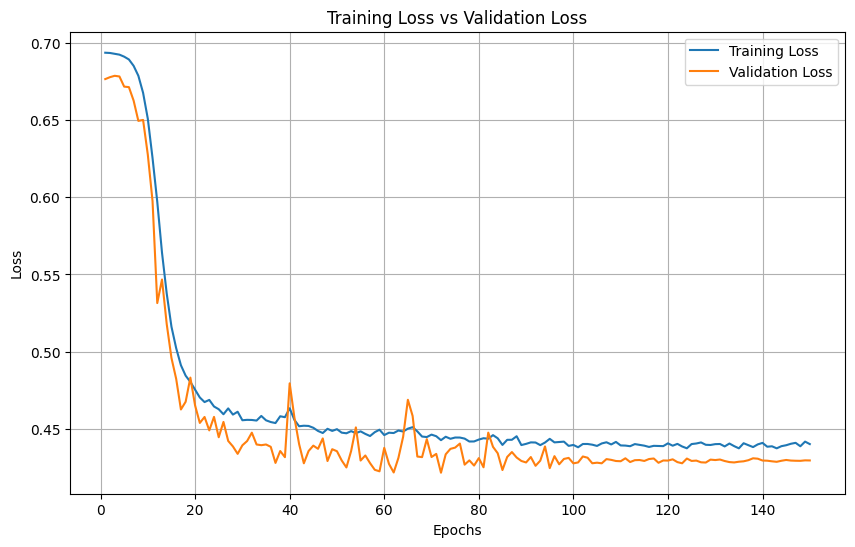

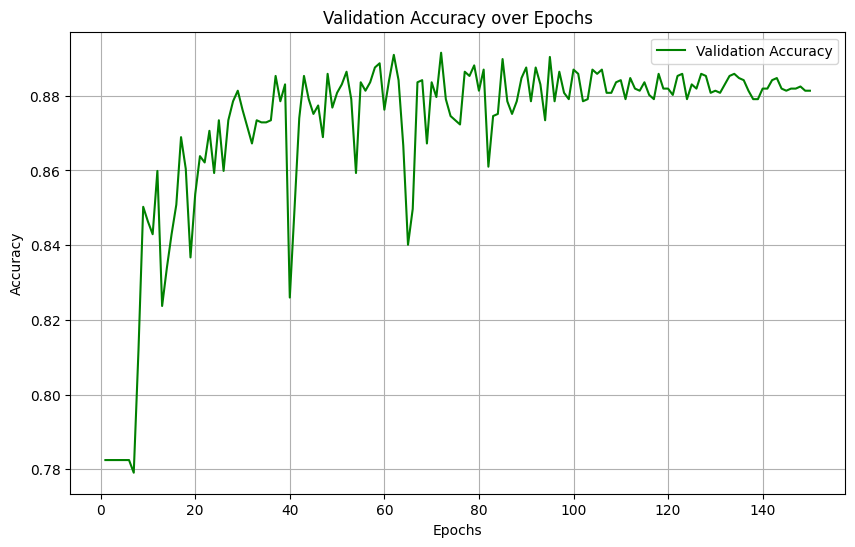

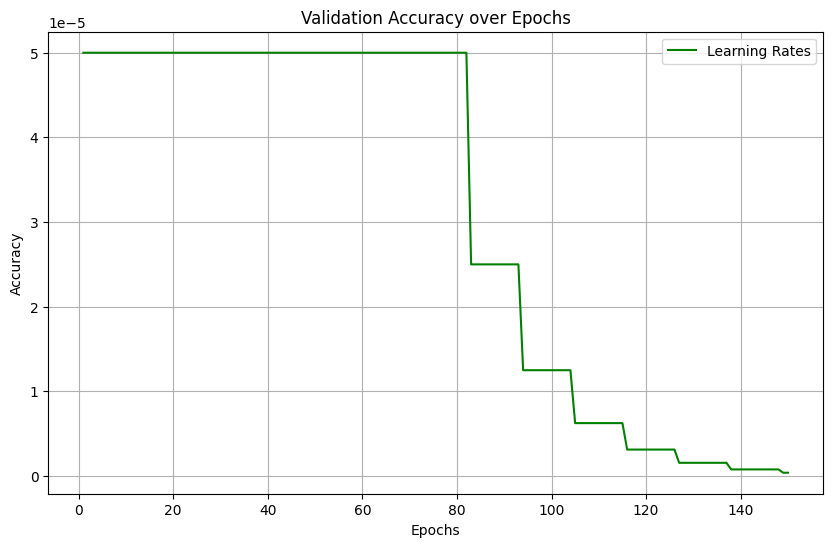

Model for bin 46 saved to 3DCholesterolModels-5A_exp5/model_bin_46.pth
1925 is length of subset grid
Training on bin 47
Bin 47, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6945, Validation Accuracy: 0.2175, Grad Norm: 0.0097, LR: 0.000050
Bin 47, Epoch 11/150, Train Loss: 0.6052, Validation Loss: 0.5600, Validation Accuracy: 0.8576, Grad Norm: 1.2404, LR: 0.000050
Bin 47, Epoch 21/150, Train Loss: 0.4636, Validation Loss: 0.4533, Validation Accuracy: 0.8667, Grad Norm: 4.2613, LR: 0.000050
Bin 47, Epoch 31/150, Train Loss: 0.4514, Validation Loss: 0.4294, Validation Accuracy: 0.8876, Grad Norm: 4.3070, LR: 0.000050
Bin 47, Epoch 41/150, Train Loss: 0.4493, Validation Loss: 0.4396, Validation Accuracy: 0.8751, Grad Norm: 4.0959, LR: 0.000050
Bin 47, Epoch 51/150, Train Loss: 0.4460, Validation Loss: 0.4375, Validation Accuracy: 0.8763, Grad Norm: 2.6351, LR: 0.000025
Bin 47, Epoch 61/150, Train Loss: 0.4463, Validation Loss: 0.4328, Validation Accuracy: 0.8791, Grad Norm: 0.4020

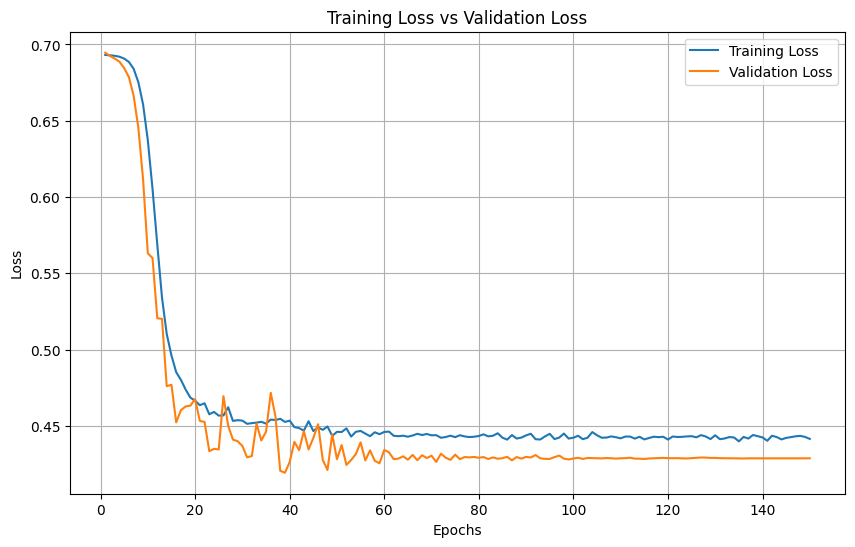

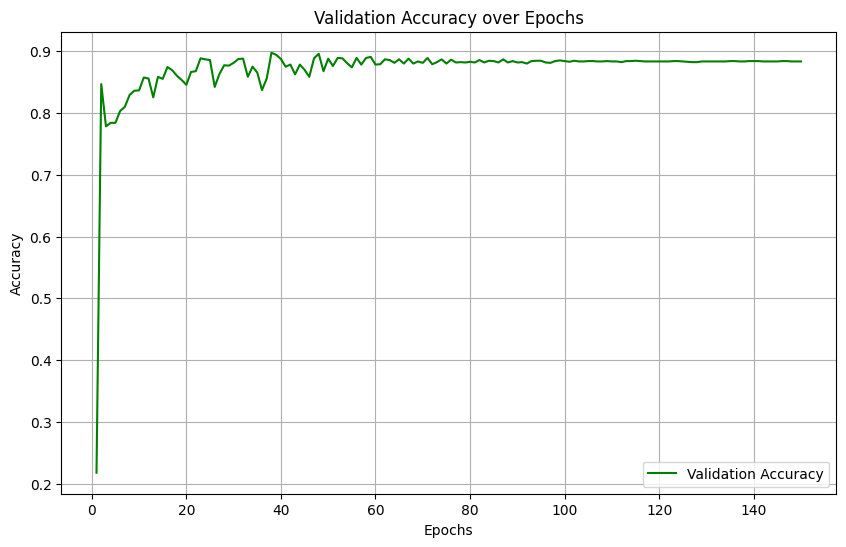

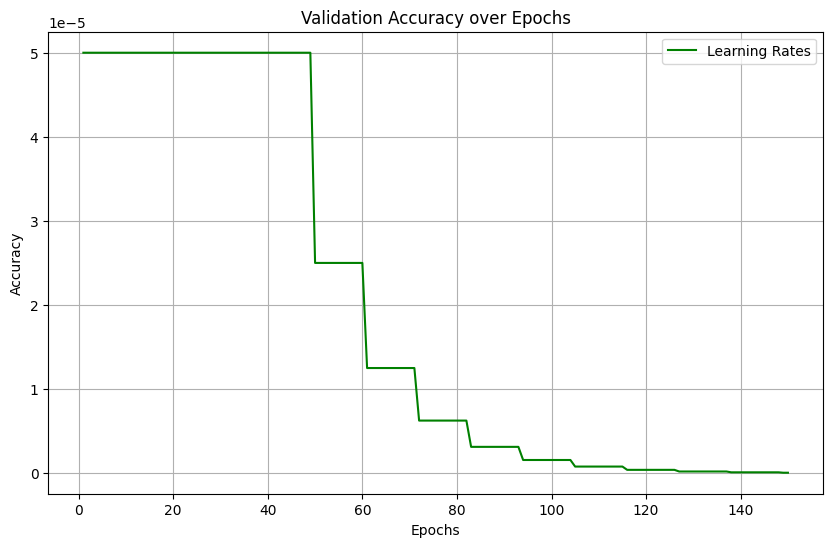

Model for bin 47 saved to 3DCholesterolModels-5A_exp5/model_bin_47.pth
1925 is length of subset grid
Training on bin 48
Bin 48, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6881, Validation Accuracy: 0.7825, Grad Norm: 0.0752, LR: 0.000050
Bin 48, Epoch 11/150, Train Loss: 0.6196, Validation Loss: 0.5930, Validation Accuracy: 0.8305, Grad Norm: 3.7641, LR: 0.000050
Bin 48, Epoch 21/150, Train Loss: 0.4777, Validation Loss: 0.4492, Validation Accuracy: 0.8814, Grad Norm: 1.1426, LR: 0.000050
Bin 48, Epoch 31/150, Train Loss: 0.4642, Validation Loss: 0.4446, Validation Accuracy: 0.8757, Grad Norm: 4.5910, LR: 0.000025
Bin 48, Epoch 41/150, Train Loss: 0.4600, Validation Loss: 0.4425, Validation Accuracy: 0.8757, Grad Norm: 2.7503, LR: 0.000025
Bin 48, Epoch 51/150, Train Loss: 0.4607, Validation Loss: 0.4352, Validation Accuracy: 0.8791, Grad Norm: 1.1208, LR: 0.000013
Bin 48, Epoch 61/150, Train Loss: 0.4571, Validation Loss: 0.4317, Validation Accuracy: 0.8842, Grad Norm: 4.0449

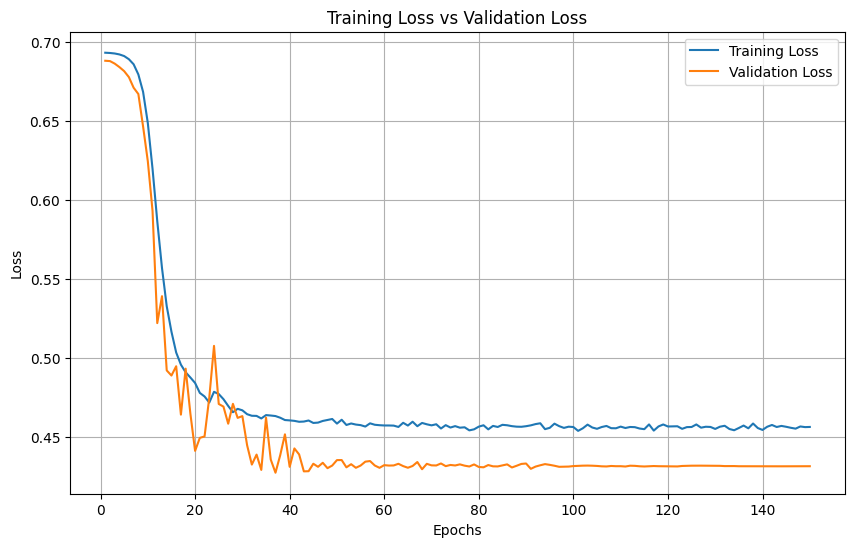

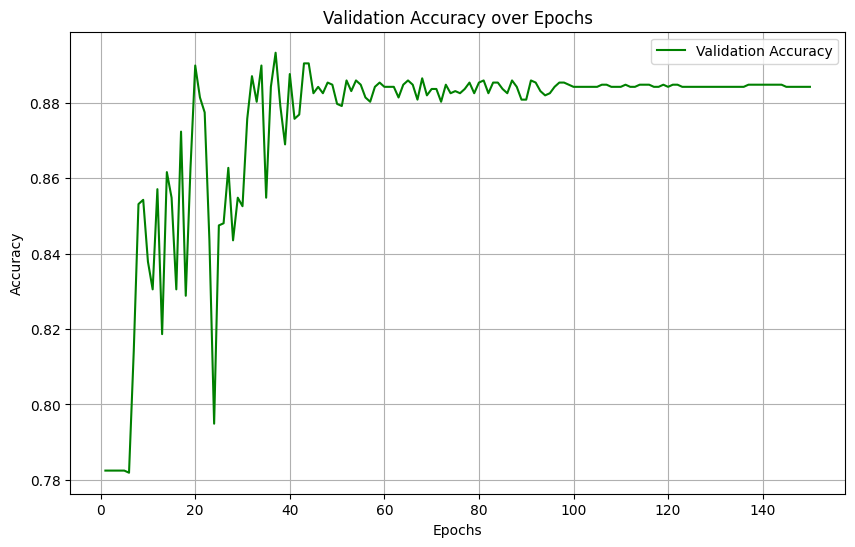

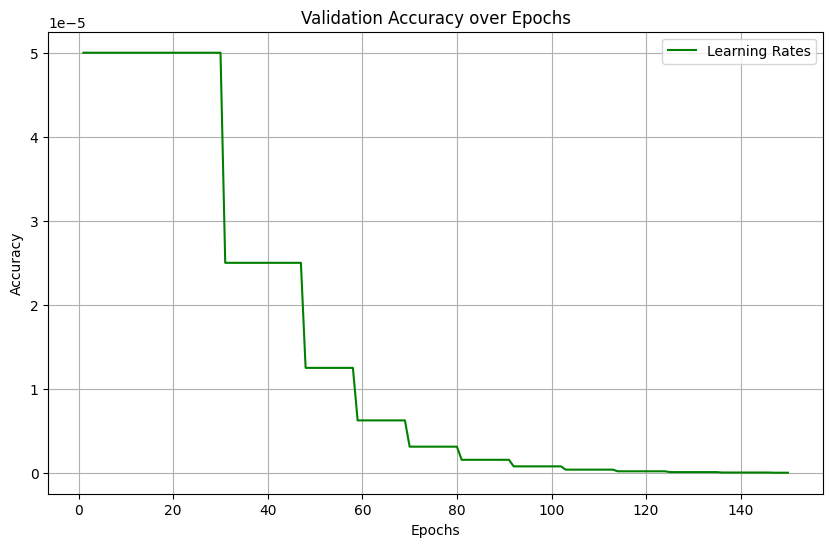

Model for bin 48 saved to 3DCholesterolModels-5A_exp5/model_bin_48.pth
1925 is length of subset grid
Training on bin 49
Bin 49, Epoch 1/150, Train Loss: 0.6933, Validation Loss: 0.7021, Validation Accuracy: 0.2175, Grad Norm: 0.0908, LR: 0.000050
Bin 49, Epoch 11/150, Train Loss: 0.5930, Validation Loss: 0.5613, Validation Accuracy: 0.8316, Grad Norm: 5.8248, LR: 0.000050
Bin 49, Epoch 21/150, Train Loss: 0.4669, Validation Loss: 0.4518, Validation Accuracy: 0.8718, Grad Norm: 3.5982, LR: 0.000050
Bin 49, Epoch 31/150, Train Loss: 0.4538, Validation Loss: 0.4259, Validation Accuracy: 0.8932, Grad Norm: 2.2265, LR: 0.000050
Bin 49, Epoch 41/150, Train Loss: 0.4516, Validation Loss: 0.4211, Validation Accuracy: 0.8955, Grad Norm: 1.6624, LR: 0.000050
Bin 49, Epoch 51/150, Train Loss: 0.4505, Validation Loss: 0.4167, Validation Accuracy: 0.9006, Grad Norm: 1.3630, LR: 0.000050
Bin 49, Epoch 61/150, Train Loss: 0.4460, Validation Loss: 0.4208, Validation Accuracy: 0.8949, Grad Norm: 2.2199

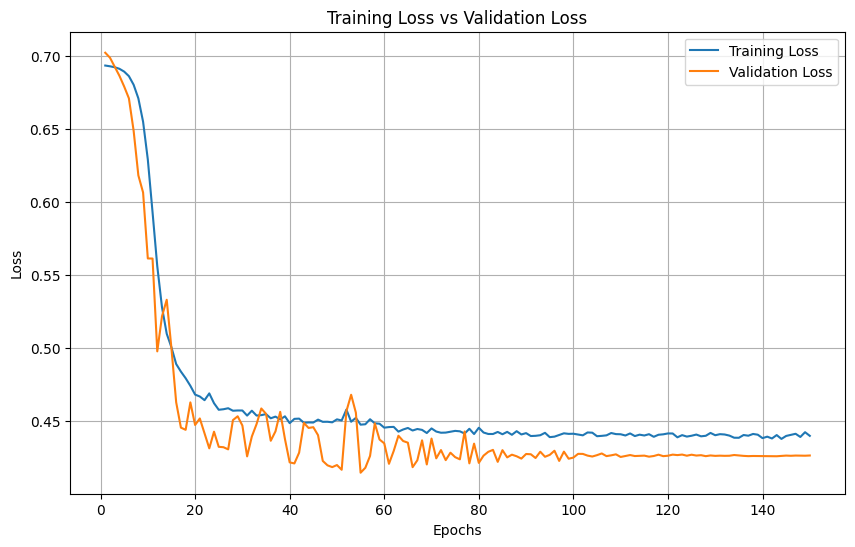

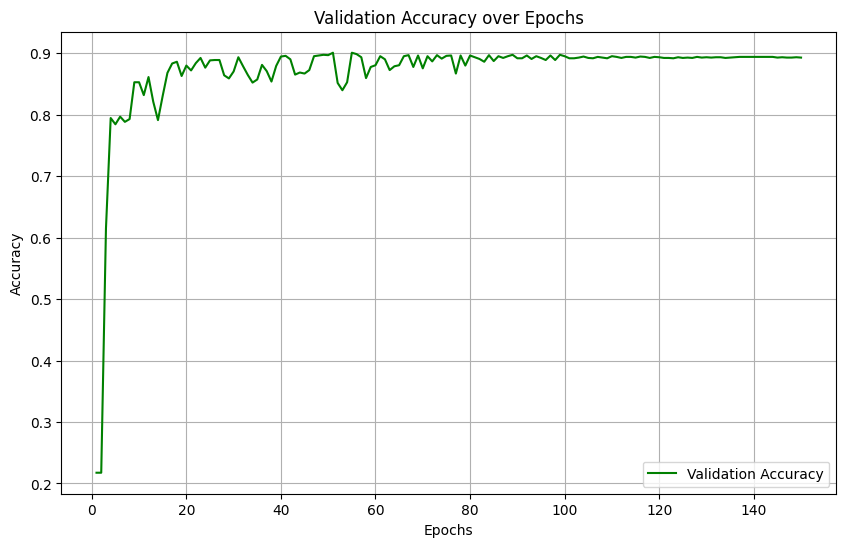

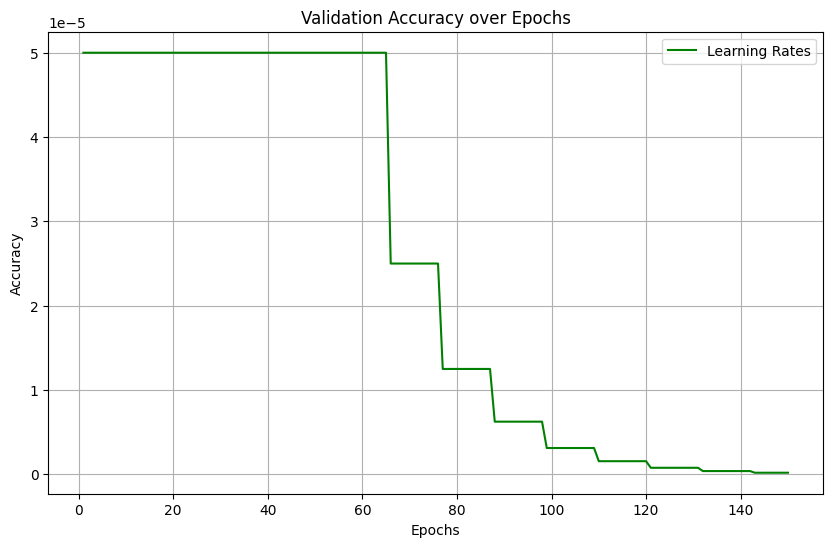

Model for bin 49 saved to 3DCholesterolModels-5A_exp5/model_bin_49.pth
1925 is length of subset grid
Training on bin 50
Bin 50, Epoch 1/150, Train Loss: 0.6931, Validation Loss: 0.6978, Validation Accuracy: 0.2175, Grad Norm: 0.1154, LR: 0.000050
Bin 50, Epoch 11/150, Train Loss: 0.6160, Validation Loss: 0.5592, Validation Accuracy: 0.8650, Grad Norm: 1.7678, LR: 0.000050
Bin 50, Epoch 21/150, Train Loss: 0.4716, Validation Loss: 0.4934, Validation Accuracy: 0.8215, Grad Norm: 1.7490, LR: 0.000050
Bin 50, Epoch 31/150, Train Loss: 0.4587, Validation Loss: 0.4403, Validation Accuracy: 0.8757, Grad Norm: 4.5574, LR: 0.000050
Bin 50, Epoch 41/150, Train Loss: 0.4550, Validation Loss: 0.4305, Validation Accuracy: 0.8825, Grad Norm: 4.4422, LR: 0.000050
Bin 50, Epoch 51/150, Train Loss: 0.4493, Validation Loss: 0.4580, Validation Accuracy: 0.8542, Grad Norm: 4.8712, LR: 0.000050
Bin 50, Epoch 61/150, Train Loss: 0.4479, Validation Loss: 0.4338, Validation Accuracy: 0.8825, Grad Norm: 6.1286

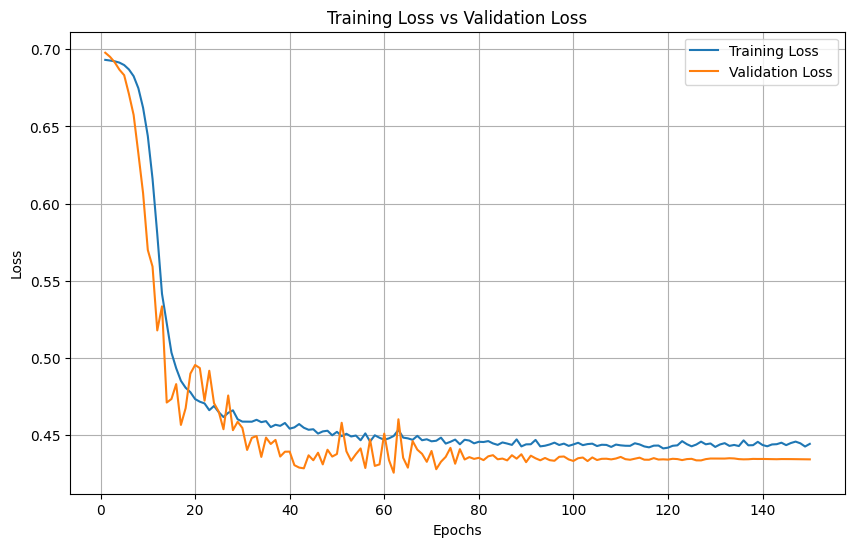

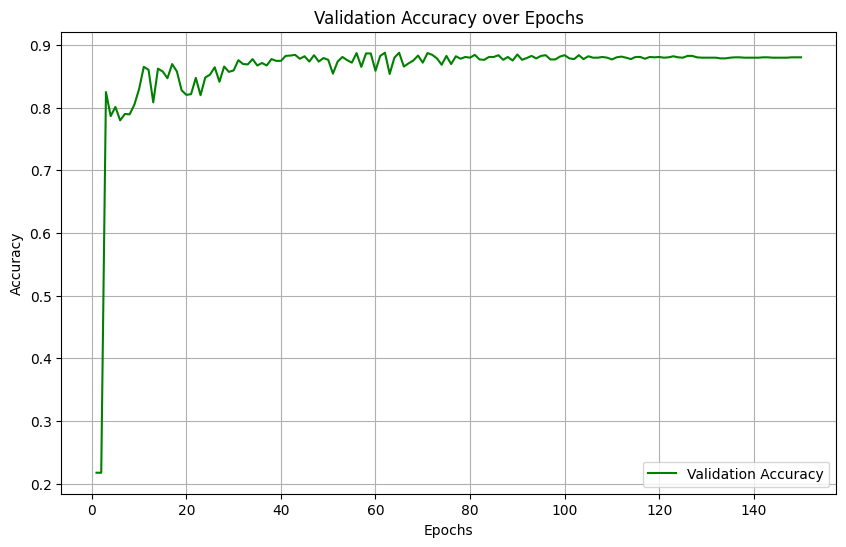

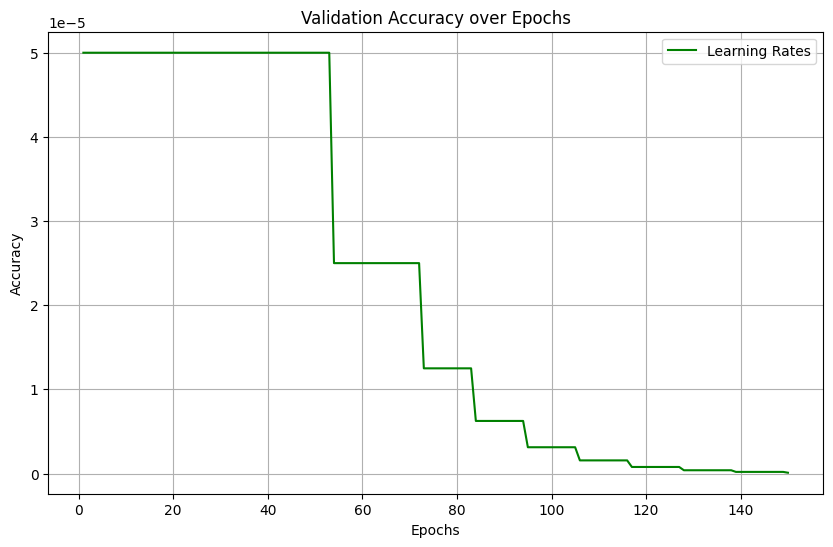

Model for bin 50 saved to 3DCholesterolModels-5A_exp5/model_bin_50.pth
Training complete.


In [6]:
import os

# Training loop
epochs = 150
batch_size = 512

validation_dataset = GridDataset(validation_grids)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for i in range(0, 50):
    k = i + 1
    file_data = {}
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-grid-5A_exp5/k_subsets/subset_{k}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        # Load the numpy array and convert it to a PyTorch tensor
        grid = np.load(file)
        grid_tensor = torch.tensor(grid, dtype=torch.float32).permute(3, 0, 1, 2)  # Fix input format
        file_data[file] = {'label': 0, 'grid_tensor': grid_tensor} # 0 means unlabeled
    subset_grid = file_data
    print(len(subset_grid), "is length of subset grid")
    
    bin = {**positive_grids, **subset_grid} # merged
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # specify to run on 3 gpu, run on scrum, convert to .py 
    
    # Initialize the model
    criterion = nn.CrossEntropyLoss()
    
    # Define paths for saving models
    save_dir = "3DCholesterolModels-5A_exp5"
    os.makedirs(save_dir, exist_ok=True)
    
    model = CNN3D().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4) # maybe try momentum 0.9
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, threshold=1e-4)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.90)  # Reduce LR every 10 epochs
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-6)
    
    print(f"Training on bin {k}")
    dataset = GridDataset(bin)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    train_losses = []
    validation_losses = []
    validation_accuracies = []
    learning_rates = []
    
    for epoch in range(epochs):
        epoch_loss, grad_norm = train_model(model, dataloader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, validation_dataloader, criterion, device)
        scheduler.step(validation_loss)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        learning_rates.append(current_lr)
    
        if epoch % 10 == 0:
            print(
                f"Bin {k}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}, "
                f"Validation Accuracy: {validation_accuracy:.4f}, Grad Norm: {grad_norm:.4f}, "
                f"LR: {current_lr:.6f}"
            )
            
    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{k}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {k} saved to {model_path}")

print("Training complete.")

# 